# Description

This notebook utilizes different methods to sift through all gene correlations across all tissues (which is a huge number) to find relevant examples that highlight the advantages of CCC.

# Modules

In [389]:
from pathlib import Path

import pandas as pd

from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from ccc import conf
from ccc.coef import ccc
from ccc.coef.impl_gpu import ccc as ccc_gpu

# Settings

# Paths

In [3]:
BASE_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu/base/")
GTEX_DIR = BASE_DIR / "data/gtex"

In [4]:
# TISSUE_DIR = BASE_DIR / "data_by_tissue"
# assert TISSUE_DIR.exists()

TISSUE_DIR = GTEX_DIR / "gene_selection/all"
assert TISSUE_DIR.exists()

In [5]:
MANUSCRIPT_DIR = Path("/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript")
FIGURES_DIR = MANUSCRIPT_DIR / "content" / "images"
OUTPUT_FIGURE_DIR = (
    FIGURES_DIR
    / "gene_pairs"
)
OUTPUT_FIGURE_DIR.mkdir(parents=True, exist_ok=True)
display(OUTPUT_FIGURE_DIR)

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs')

# Data

## GTEx metadata

In [6]:
gtex_metadata = pd.read_pickle(GTEX_DIR / "gtex_v8-sample_metadata.pkl")

In [7]:
gtex_metadata.shape

(22951, 262)

In [8]:
gtex_metadata.head()

SUBJID      COHORT     SEX  AGE  RACE  \
SAMPID                                                                     
GTEX-1117F-0003-SM-58Q7G       GTEX-1117F  Postmortem  Female   66     2   
GTEX-1117F-0003-SM-5DWSB       GTEX-1117F  Postmortem  Female   66     2   
GTEX-1117F-0003-SM-6WBT7       GTEX-1117F  Postmortem  Female   66     2   
GTEX-1117F-0011-R10a-SM-AHZ7F  GTEX-1117F  Postmortem  Female   66     2   
GTEX-1117F-0011-R10b-SM-CYKQ8  GTEX-1117F  Postmortem  Female   66     2   

                               ETHNCTY  HGHT HGHTU   WGHT WGHTU  ...  \
SAMPID                                                           ...   
GTEX-1117F-0003-SM-58Q7G             0  66.0    in  199.0    lb  ...   
GTEX-1117F-0003-SM-5DWSB             0  66.0    in  199.0    lb  ...   
GTEX-1117F-0003-SM-6WBT7             0  66.0    in  199.0    lb  ...   
GTEX-1117F-0011-R10a-SM-AHZ7F        0  66.0    in  199.0    lb  ...   
GTEX-1117F-0011-R10b-SM-CYKQ8        0  66.0    in  199.0    lb  ...   

                               SME1ANTI SMSPLTRD SMBSMMRT  SME1SNSE SME1PCTS  \
SAMPID                                                                         
GTEX-1117F-0003-SM-58Q7G            NaN      NaN      NaN       NaN      NaN   
GTEX-1117F-0003-SM-5DWSB            NaN      NaN      NaN       NaN      NaN   
GTEX-1117F-0003-SM-6WBT7            NaN      NaN      NaN       NaN      NaN   
GTEX-1117F-0011-R10a-SM-AHZ7F       NaN      NaN      NaN       NaN      NaN   
GTEX-1117F-0011-R10b-SM-CYKQ8       NaN      NaN      NaN       NaN      NaN   

                               SMRRNART SME1MPRT  SMNUM5CD SMDPMPRT SME2PCTS  
SAMPID                                                                        
GTEX-1117F-0003-SM-58Q7G            NaN      NaN       NaN      NaN      NaN  
GTEX-1117F-0003-SM-5DWSB            NaN      NaN       NaN      NaN      NaN  
GTEX-1117F-0003-SM-6WBT7            NaN      NaN       NaN      NaN      NaN  
GTEX-1117F-0011-R10a-SM-AHZ7F       NaN      NaN       NaN      NaN      NaN  
GTEX-1117F-0011-R10b-SM-CYKQ8       NaN      NaN       NaN      NaN      NaN  

[5 rows x 262 columns]

## Gene Ensembl ID -> Symbol mapping

In [9]:
gene_map = pd.read_pickle(GTEX_DIR / "gtex_gene_id_symbol_mappings.pkl")

In [10]:
gene_map = gene_map.set_index("gene_ens_id")["gene_symbol"].to_dict()

In [11]:
assert gene_map["ENSG00000145309.5"] == "CABS1"

## Gene pair intersections

In [17]:
# gene_pairs = pd.read_pickle(BASE_DIR / "gene_pair_intersections" / "gene_pair_intersections-gtex_v8-whole_blood-var_pc_log2.pkl")

In [18]:
# gene_pairs.shape

In [19]:
# gene_pairs.head()

## Tissue thresholds

In [23]:
tissue_thres = {
    tissue_name: pd.read_pickle(BASE_DIR / "data/gtex/tissue_thresholds" / f"{tissue_name}-null_coefs_percentiles.pkl")
    for tissue_name in ("whole_blood", "adipose_subcutaneous")
}

In [24]:
tissue_thres["whole_blood"].shape

(108, 3)

In [25]:
tissue_thres["whole_blood"].tail(28)

ccc   pearson  spearman
0.800000  0.016566  0.013113  0.047494
0.810000  0.017147  0.013445  0.048574
0.820000  0.017752  0.013802  0.049690
0.830000  0.018386  0.014190  0.050855
0.840000  0.019049  0.014611  0.052074
0.850000  0.019749  0.015078  0.053348
0.860000  0.020485  0.015600  0.054689
0.870000  0.021264  0.016188  0.056110
0.880000  0.022094  0.016868  0.057615
0.890000  0.022986  0.017672  0.059221
0.900000  0.023941  0.018653  0.060951
0.910000  0.024981  0.019909  0.062826
0.920000  0.026120  0.021604  0.064880
0.930000  0.027379  0.024068  0.067151
0.940000  0.028800  0.027911  0.069709
0.950000  0.030434  0.033877  0.072644
0.960000  0.032369  0.042785  0.076121
0.970000  0.034774  0.056604  0.080426
0.980000  0.038005  0.081378  0.086210
0.990000  0.043179  0.142259  0.095444
0.999000  0.058178  0.521345  0.121845
0.999900  0.071066  0.858359  0.144172
0.999990  0.082599  0.975152  0.163920
0.999999  0.093050  0.997194  0.182336
1.000000  0.102588  0.999210  0.197816
1.000000  0.104259  0.999418  0.208119
1.000000  0.104268  0.999491  0.215371
1.000000  0.104269  0.999499  0.216096

In [26]:
tissue_thres["whole_blood"].tail(21).index

Index([              0.87,               0.88,               0.89,
                      0.9,               0.91,               0.92,
                     0.93, 0.9400000000000001, 0.9500000000000001,
                     0.96,               0.97,               0.98,
                     0.99,              0.999,             0.9999,
                  0.99999,           0.999999,          0.9999999,
               0.99999999,        0.999999999,       0.9999999999],
      dtype='float64')

In [27]:
c_high = {
    tissue_name: tissue_data.loc[0.99, "ccc"]
    for tissue_name, tissue_data in tissue_thres.items()
}

p_low = {
    tissue_name: tissue_data.loc[0.80, "pearson"]
    for tissue_name, tissue_data in tissue_thres.items()
}

s_low = {
    tissue_name: tissue_data.loc[0.80, "spearman"]
    for tissue_name, tissue_data in tissue_thres.items()
}

In [28]:
c_high

{'whole_blood': 0.04317856218665836,
 'adipose_subcutaneous': 0.03674546629190445}

In [29]:
p_low

{'whole_blood': 0.013112879092968526,
 'adipose_subcutaneous': 0.020378650099533976}

In [30]:
s_low

{'whole_blood': 0.04749446200470309,
 'adipose_subcutaneous': 0.04988284673936714}

# Plotting functions

In [31]:
def get_tissue_file(name):
    """
    Given a part of a tissue name, it returns a file path to the
    expression data for that tissue in GTEx. It fails if more than
    one files are found.

    Args:
        name: a string with the tissue name (or a part of it).

    Returns:
        A Path object pointing to the gene expression file for the
        given tissue.
    """
    tissue_files = []
    for f in TISSUE_DIR.glob("*.pkl"):
        if name in f.name:
            tissue_files.append(f)

    assert len(tissue_files) == 1
    return tissue_files[0]

In [32]:
# testing
_tmp = get_tissue_file("whole_blood")
assert _tmp.exists()

In [33]:
def simplify_tissue_name(tissue_name):
    return f"{tissue_name[0].upper()}{tissue_name[1:].replace('_', ' ')}"

In [34]:
assert simplify_tissue_name("whole_blood") == "Whole blood"
assert simplify_tissue_name("uterus") == "Uterus"

In [35]:
def plot_gene_pair(
    tissue_name, gene0, gene1, hue=None, hue_is_categorical=None, hue_include_categories=None, kind="hex", ylim=None, bins="log", plot=True, **kwargs,
):
    """
    It plots (joint plot) a gene pair from the given tissue. It saves the plot
    for the manuscript.
    """
    # merge gene expression with metadata
    tissue_file = get_tissue_file(tissue_name)
    tissue_data = pd.read_pickle(tissue_file).T[[gene0, gene1]]
    display(f"Tissue data: {tissue_data.shape}")

    if hue is not None:
        tissue_data = pd.merge(
            tissue_data,
            gtex_metadata,
            how="inner",
            left_index=True,
            right_index=True,
            validate="one_to_one",
        )

        tissue_data = tissue_data.dropna(subset=[hue])
    
        display(f"Tissue data with metadata: {tissue_data.shape}")

    # get gene symbols
    gene0_symbol, gene1_symbol = gene_map[gene0], gene_map[gene1]
    display((gene0_symbol, gene1_symbol))

    # compute correlations for this gene pair
    _clustermatch = ccc(tissue_data[gene0], tissue_data[gene1])
    _pearson = pearsonr(tissue_data[gene0], tissue_data[gene1])[0]
    _spearman = spearmanr(tissue_data[gene0], tissue_data[gene1])[0]

    _title = f"{simplify_tissue_name(tissue_name)}\n$c={_clustermatch:.2f}$  $p={_pearson:.2f}$  $s={_spearman:.2f}$"

    other_args = {
        "kind": kind,  # if hue is None else "scatter",
        "rasterized": True,
    } | kwargs
    # if hue is None:
    #     other_args["bins"] = bins
    # else:
    #     other_args["hue_order"] = ["Male", "Female"]

    if hue_is_categorical:
        if isinstance(hue_include_categories, (list, tuple)):
            print(tissue_data.shape)
            tissue_data = tissue_data[tissue_data[hue].isin(hue_include_categories)]
            print(tissue_data.shape)
        tissue_data[hue] = tissue_data[hue].astype("category")

    if not plot:
        return tissue_data, None

    with sns.plotting_context("paper", font_scale=1.5):
        p = sns.jointplot(
            data=tissue_data,
            x=gene0,
            y=gene1,
            hue=hue,
            **other_args,
            # ylim=(0, 500),
        )

        if ylim is not None:
            p.ax_joint.set_ylim(ylim)

        gene_x_id = p.ax_joint.get_xlabel()
        gene_x_symbol = gene_map[gene_x_id]
        p.ax_joint.set_xlabel(f"{gene_x_symbol}\n{gene_x_id}", fontstyle="italic")

        gene_y_id = p.ax_joint.get_ylabel()
        gene_y_symbol = gene_map[gene_y_id]
        p.ax_joint.set_ylabel(f"{gene_y_symbol}\n{gene_y_id}", fontstyle="italic")

        p.fig.suptitle(_title)

        # save
        output_file = (
            OUTPUT_FIGURE_DIR
            / f"gtex_{tissue_name}-{gene_x_symbol}_vs_{gene_y_symbol}.svg"
        )
        display(output_file)

        plt.savefig(
            output_file,
            bbox_inches="tight",
            dpi=300,
            facecolor="white",
        )

    return tissue_data, p

# **Gene pair 1**: Whole blood, RASSF2 - CYTIP

In [37]:
tissue = "whole_blood"
gene0_id, gene1_id = "ENSG00000101265.15", "ENSG00000115165.9"

In [38]:
_tissue_data, _p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    plot=False,
    hue="SEX", # force getting metadata
)

'Tissue data: (755, 2)'

'Tissue data with metadata: (755, 264)'

('RASSF2', 'CYTIP')

In [39]:
_tissue_data["COHORT"].value_counts()

COHORT
Postmortem           388
Organ Donor (OPO)    356
Surgical              11
Name: count, dtype: int64

'Tissue data: (755, 2)'

'Tissue data with metadata: (755, 264)'

('RASSF2', 'CYTIP')

(755, 264)
(744, 264)


PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RASSF2_vs_CYTIP.svg')

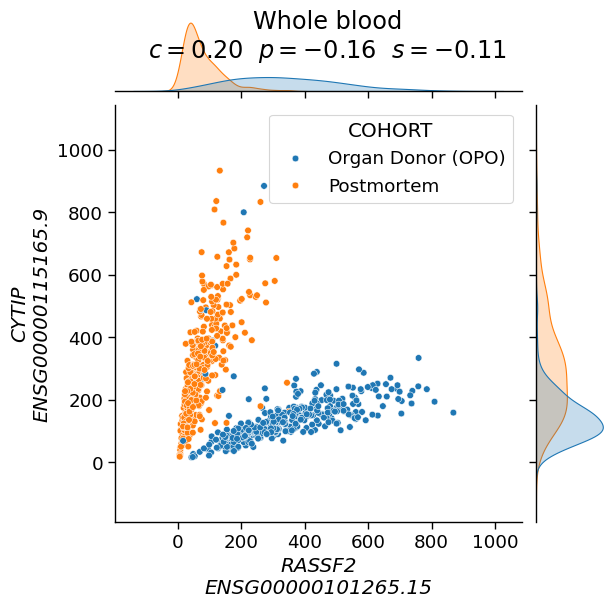

In [40]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue="COHORT",
    hue_is_categorical=True,
    hue_include_categories=["Organ Donor (OPO)", "Postmortem"],
    kind="scatter",
)

'Tissue data: (755, 2)'

'Tissue data with metadata: (755, 264)'

('RASSF2', 'CYTIP')

(755, 264)
(744, 264)


PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-RASSF2_vs_CYTIP.svg')

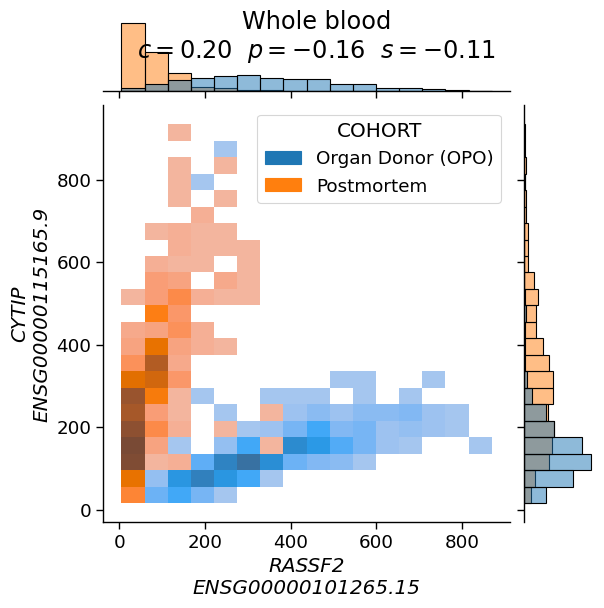

In [41]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue="COHORT",
    hue_is_categorical=True,
    hue_include_categories=["Organ Donor (OPO)", "Postmortem"],
    kind="hist",
)

# Exploring top gene pairs using tissue thresholds

## Adipose subcutaneous

In [42]:
tissue = "adipose_subcutaneous"

In [43]:
gene_pairs = pd.read_pickle(BASE_DIR / f"data/gtex/similarity_matrices/all/gtex_v8_data_{tissue}-var_pc_log2-all.pkl")

In [44]:
gene_pairs.shape

(1460025703, 3)

In [45]:
gene_pairs.head()

ccc   pearson  spearman
ENSG00000149968.11 ENSG00000129824.15  0.092407  0.142700  0.404541
ENSG00000134184.12 ENSG00000129824.15  0.007263  0.044830  0.016876
                   ENSG00000149968.11  0.004570  0.007866  0.062561
ENSG00000224114.1  ENSG00000129824.15  0.011841  0.086182  0.102783
                   ENSG00000149968.11  0.009171  0.010735  0.063599

In [46]:
top_gp = gene_pairs[
    (gene_pairs["ccc"] > c_high[tissue])
    & (gene_pairs["pearson"] < p_low[tissue])
    & (gene_pairs["spearman"] < s_low[tissue])
].sort_values("ccc", ascending=False)

In [47]:
top_gp.shape

(1854478, 3)

In [48]:
top_gp.head()

ccc   pearson  spearman
ENSG00000273906.1  ENSG00000198848.12  0.085938  0.000309  0.000484
ENSG00000239210.2  ENSG00000223273.1   0.084595  0.006535  0.045349
ENSG00000104763.18 ENSG00000092377.13  0.083740  0.003389  0.046326
ENSG00000122787.14 ENSG00000284564.1   0.080933  0.019760  0.039337
ENSG00000145826.8  ENSG00000236216.5   0.079407  0.005009  0.046265

ccc         0.072571
pearson     0.013512
spearman    0.043793
Name: (ENSG00000224321.1, ENSG00000273906.1), dtype: float16

'Tissue data: (663, 2)'

('RPL12P14', 'RP11-115H13.1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_adipose_subcutaneous-RPL12P14_vs_RP11-115H13.1.svg')

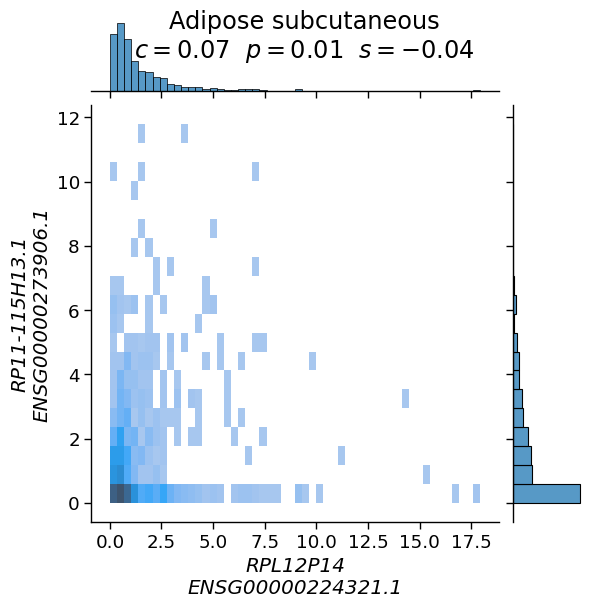

In [49]:
gp_i = top_gp.iloc[14]#.iloc[14]
gene0_id, gene1_id = gp_i.name
display(gp_i)

_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    # hue="RACE",
    # hue_is_categorical=True,
    # hue_include_categories=[0.0, 1.0],
    kind="hist",
)

## Whole blood

In [50]:
tissue = "whole_blood"

In [51]:
gene_pairs = pd.read_pickle(BASE_DIR / f"data/gtex/similarity_matrices/all/gtex_v8_data_{tissue}-var_pc_log2-all.pkl")

In [52]:
gene_pairs.shape

(1420258456, 3)

In [53]:
gene_pairs.head()

ccc   pearson  spearman
ENSG00000135245.9  ENSG00000169429.10  0.780273  0.571777  0.854004
ENSG00000163631.16 ENSG00000169429.10  0.401611  0.126953  0.709473
                   ENSG00000135245.9   0.429199  0.110596  0.675781
ENSG00000277632.1  ENSG00000169429.10  0.789551  0.456543  0.850586
                   ENSG00000135245.9   0.780273  0.438965  0.834473

In [54]:
top_gp = gene_pairs[
    (gene_pairs["ccc"] > c_high[tissue])
    & (gene_pairs["pearson"] < p_low[tissue])
    & (gene_pairs["spearman"] < s_low[tissue])
].sort_values("ccc", ascending=False)

In [55]:
top_gp.shape

(140585, 3)

In [56]:
top_gp.head()

ccc   pearson  spearman
ENSG00000101347.8  ENSG00000143507.17  0.160156  0.010674  0.037170
ENSG00000148153.13 ENSG00000125812.15  0.149048  0.003677  0.034729
ENSG00000174796.12 ENSG00000125812.15  0.144043  0.003780  0.040649
ENSG00000089639.10 ENSG00000100226.15  0.139160  0.010674  0.047150
ENSG00000234511.8  ENSG00000179456.10  0.136230  0.001462  0.037811

ccc         0.160156
pearson     0.010674
spearman    0.037170
Name: (ENSG00000101347.8, ENSG00000143507.17), dtype: float16

'Tissue data: (755, 2)'

('SAMHD1', 'DUSP10')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-SAMHD1_vs_DUSP10.svg')

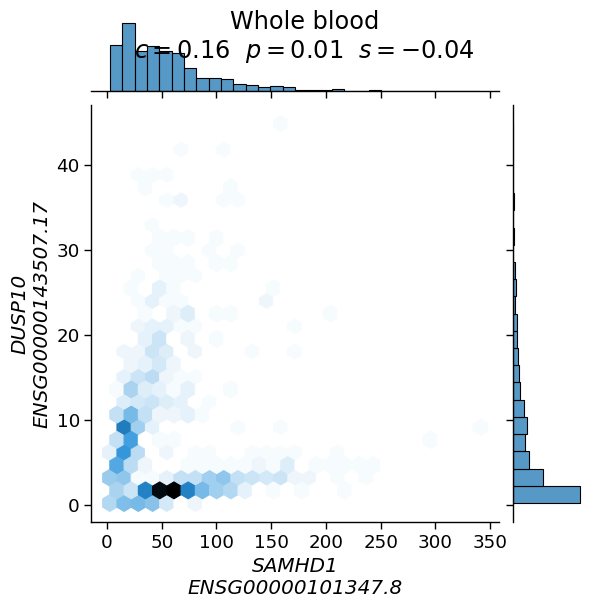

In [65]:
gp_i = top_gp.iloc[0]
gene0_id, gene1_id = gp_i.name
display(gp_i)

_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    # hue="RACE",
    # hue_is_categorical=True,
    # hue_include_categories=[0.0, 1.0],
    # kind="hist",
)

'Tissue data: (755, 2)'

'Tissue data with metadata: (755, 264)'

('SAMHD1', 'DUSP10')

(755, 264)
(744, 264)


PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_whole_blood-SAMHD1_vs_DUSP10.svg')

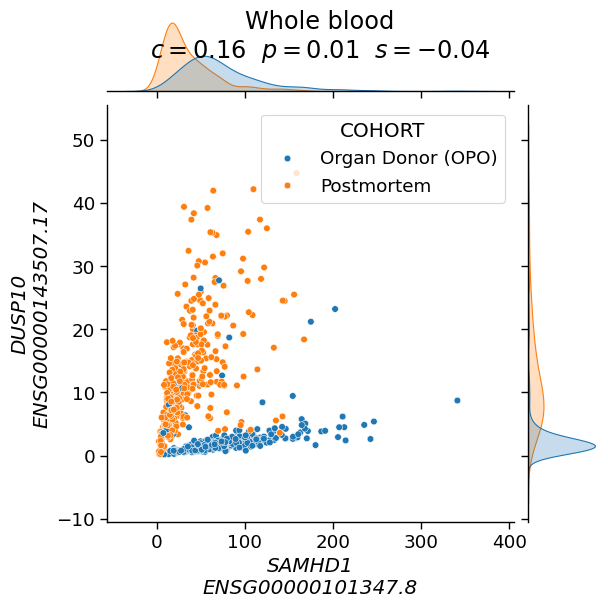

In [66]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue="COHORT",
    hue_is_categorical=True,
    hue_include_categories=["Organ Donor (OPO)", "Postmortem"],
    kind="scatter",
)

# Exploring top gene pairs using metadata correlation data

## Load combined gene pairs with metadata

In [67]:
gene_pairs = pd.read_pickle(
    BASE_DIR / "results/top_gene_pair_correlation/top_100_gene_pairs/combined_c-high-p-low-s-low_top_100_gene_pairs_with_metadata.pkl"
)

In [68]:
gene_pairs.shape

(5400, 50)

In [69]:
gene_pairs

tissue               gene1               gene2  \
0     adipose_subcutaneous   ENSG00000273906.1  ENSG00000198848.12   
1     adipose_subcutaneous   ENSG00000214045.3   ENSG00000259121.2   
2     adipose_subcutaneous   ENSG00000267762.1   ENSG00000257084.1   
3     adipose_subcutaneous   ENSG00000172482.4   ENSG00000273906.1   
4     adipose_subcutaneous   ENSG00000125965.8   ENSG00000273906.1   
...                    ...                 ...                 ...   
5395           whole_blood   ENSG00000116574.5   ENSG00000123689.5   
5396           whole_blood  ENSG00000135535.15  ENSG00000125812.15   
5397           whole_blood  ENSG00000100714.15   ENSG00000182544.8   
5398           whole_blood   ENSG00000257594.3   ENSG00000231721.6   
5399           whole_blood  ENSG00000204152.10  ENSG00000034533.11   

      Gene 1 Symbol  Gene 2 Symbol  Pearson (high)  Pearson (low)  \
0     RP11-115H13.1           CES1           False           True   
1       RP6-186E3.1  RP11-545M17.2           False           True   
2      RP11-426J5.2      U47924.27           False           True   
3              AGXT  RP11-115H13.1           False           True   
4              GDF5  RP11-115H13.1           False           True   
...             ...            ...             ...            ...   
5395           RHOU           G0S2           False           True   
5396          CD164           GZF1           False           True   
5397         MTHFD1          MFSD5           False           True   
5398         GALNT4      LINC-PINT           False           True   
5399        TIMM23B          ASTE1           False           True   

      Spearman (high)  Spearman (low)  Clustermatch (high)  ...  \
0               False            True                 True  ...   
1               False            True                 True  ...   
2               False            True                 True  ...   
3               False            True                 True  ...   
4               False            True                 True  ...   
...               ...             ...                  ...  ...   
5395            False            True                 True  ...   
5396            False            True                 True  ...   
5397            False            True                 True  ...   
5398            False            True                 True  ...   
5399            False            True                 True  ...   

      gene2_top3_metadata  gene2_top3_ccc  gene2_top3_pvalue  \
0                SMTSISCH        0.086909           0.000100   
1                 DTHHRDY        0.041375           0.003000   
2                  MHCOPD        0.046250           0.031597   
3                    WGHT        0.090148           0.000100   
4                    WGHT        0.090148           0.000100   
...                   ...             ...                ...   
5395               DTHRFG        0.612235           0.000100   
5396               DTHRFG        0.524278           0.000100   
5397              TRISCHD        0.575427           0.000100   
5398             TRCCLMPD        0.388366           0.000100   
5399              TRISCHD        0.432578           0.000100   

      gene2_top4_metadata  gene2_top4_ccc  gene2_top4_pvalue  \
0                TRDNISCH        0.083355           0.000100   
1                SMMPPDPR        0.041275           0.000100   
2                 MHEURO5        0.040713           0.008199   
3                 TRISCHD        0.040521           0.000100   
4                 TRISCHD        0.040521           0.000100   
...                   ...             ...                ...   
5395             TRCCLMPD        0.603955           0.000100   
5396            TRCHSTIND        0.524274           0.000100   
5397            TRCHSTIND        0.567403           0.000100   
5398               DTHRFG        0.368767           0.000100   
5399             LBCMVTAB        0.425622           0.000100   

      g

In [72]:
low_sample_size_tissues = ("fallopian_tube", "cervix_ectocervix", "cervix_endocervix", "kidney_medulla", "bladder")

In [372]:
import pyensembl

In [373]:
ensembl_data = pyensembl.EnsemblRelease(release=104, species='homo_sapiens')

In [375]:
gene_name = "TP53"
genes = ensembl_data.genes_by_name(gene_name)

In [376]:
genes

[Gene(gene_id='ENSG00000141510', gene_name='TP53', biotype='protein_coding', contig='17', start=7661779, end=7687538, strand='-', genome='GRCh38')]

## SEX

In [188]:
# look for specific metadata variables
gp = gene_pairs[
    (gene_pairs["common_metadata"].str.contains("SEX"))
    & (~gene_pairs["tissue"].isin(low_sample_size_tissues))
].drop(columns=[
    f"{c} ({hl})" for c in ("Clustermatch", "Pearson", "Spearman") for hl in ("high", "low")
]).sort_values("ccc", ascending=False)
display(gp)

tissue               gene1               gene2  \
1800    brain_spinal_cord_cervical_c1  ENSG00000005889.15  ENSG00000131002.11   
700                    brain_amygdala   ENSG00000225470.7   ENSG00000198692.9   
4686   small_intestine_terminal_ileum  ENSG00000005889.15  ENSG00000067048.16   
2000            breast_mammary_tissue   ENSG00000070950.9  ENSG00000183878.15   
900       brain_caudate_basal_ganglia   ENSG00000225470.7  ENSG00000067048.16   
...                               ...                 ...                 ...   
81               adipose_subcutaneous  ENSG00000166033.11   ENSG00000154620.5   
4485  skin_not_sun_exposed_suprapubic  ENSG00000169499.14   ENSG00000237659.1   
4494  skin_not_sun_exposed_suprapubic  ENSG00000130702.15  ENSG00000183878.15   
4553       skin_sun_exposed_lower_leg  ENSG00000163877.10   ENSG00000260197.1   
4594       skin_sun_exposed_lower_leg   ENSG00000184895.7   ENSG00000159455.8   

     Gene 1 Symbol  Gene 2 Symbol       ccc   pearson  spearman  \
1800           ZFX         TXLNGY  0.244263  0.020096  0.045319   
700            JPX         EIF1AY  0.240723  0.011772  0.008095   
4686           ZFX          DDX3Y  0.240601  0.011871  0.030075   
2000         RAD18            UTY  0.230225  0.011086  0.011826   
900            JPX          DDX3Y  0.216797  0.012337  0.004864   
...            ...            ...       ...       ...       ...   
81           HTRA1         TMSB4Y  0.046906  0.004444  0.005074   
4485       PLEKHA2     RNASEH2CP1  0.046783  0.003189  0.003582   
4494         LAMA5            UTY  0.044159  0.001617  0.000335   
4553         SNIP1  RP11-424G14.1  0.043915  0.001238  0.002405   
4594           SRY          LCE2B  0.042328  0.000995  0.004456   

      ccc_pearson_diff  ccc_spearman_diff  ...  gene2_top3_metadata  \
1800          0.224167           0.198944  ...             SMRRNART   
700           0.228951           0.232628  ...                 HGHT   
4686          0.228729           0.210526  ...                 WGHT   
2000          0.219139           0.218399  ...                 WGHT   
900           0.204460           0.211933  ...             SMRRNANM   
...                ...                ...  ...                  ...   
81            0.042461           0.041832  ...                 WGHT   
4485          0.043594           0.043201  ...                 WGHT   
4494          0.042542           0.043823  ...              DTHHRDY   
4553          0.042677           0.041510  ...                 WGHT   
4594          0.041333           0.037872  ...             SMEXPEFF   

      gene2_top3_ccc  gene2_top3_pvalue gene2_top4_metadata  gene2_top4_ccc  \
1800        0.175282             0.0001            SMRRNANM        0.155736   
700         0.165208             0.0001            SMRRNANM        0.141805   
4686        0.137567             0.0001            SMRRNART        0.084988   
2000        0.150229             0.0001            SMNTRNRT        0.141176   
900         0.168528             0.0001                HGHT        0.168486   
...              ...                ...                 ...             ...   
81          0.115891             0.0001             DTHHRDY        0.054572   
4485        0.085221             0.0001             DTHHRDY        0.043326   
4494        0.131231             0.0001            SMTSISCH        0.117127   
4553        0.094498             0.0001            SMNTERRT        0.043388   
4594        0.072554             0.0001            SMTSISCH        0.050090   

      gene2_top4_pvalue gene2_top5_metadata  gene2_top5_ccc  \
1800             0.0001            SMNTRNRT        0.135312   
700              0.0001            SMSPLTRD        0.120524   
4686             0.0002            SMNTRART        0.081532   
2000             0.0001            SMEXPEFF        0.140450   
900              0.0001            SMALTALG        0.118618   
...                 ...                 ...             ...   
81        

tissue                         brain_spinal_cord_cervical_c1
gene1                                     ENSG00000005889.15
gene2                                     ENSG00000131002.11
Gene 1 Symbol                                            ZFX
Gene 2 Symbol                                         TXLNGY
ccc                                                 0.244263
pearson                                             0.020096
spearman                                            0.045319
ccc_pearson_diff                                    0.224167
ccc_spearman_diff                                   0.198944
ccc_combined_distance                               0.423111
ccc_mean_distance                                   0.211555
ccc_max_distance                                    0.224167
gene1_top1_metadata                                 SMRRNART
gene1_top1_ccc                                      0.281239
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (159, 2)'

('ZFX', 'TXLNGY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_spinal_cord_cervical_c1-ZFX_vs_TXLNGY.svg')

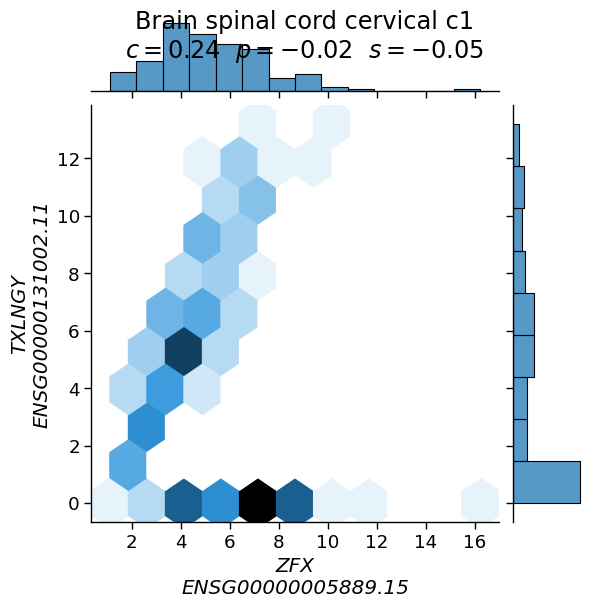

tissue                                        brain_amygdala
gene1                                      ENSG00000225470.7
gene2                                      ENSG00000198692.9
Gene 1 Symbol                                            JPX
Gene 2 Symbol                                         EIF1AY
ccc                                                 0.240723
pearson                                             0.011772
spearman                                            0.008095
ccc_pearson_diff                                    0.228951
ccc_spearman_diff                                   0.232628
ccc_combined_distance                               0.461578
ccc_mean_distance                                   0.230789
ccc_max_distance                                    0.232628
gene1_top1_metadata                                      SEX
gene1_top1_ccc                                      0.184034
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (152, 2)'

('JPX', 'EIF1AY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-JPX_vs_EIF1AY.svg')

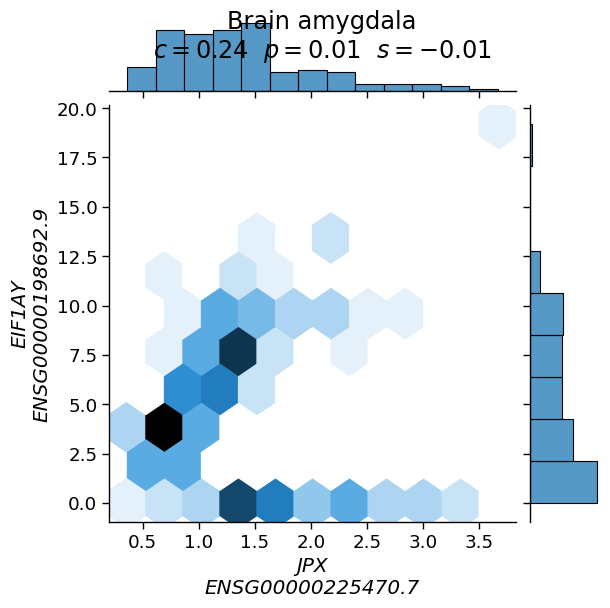

tissue                            small_intestine_terminal_ileum
gene1                                         ENSG00000005889.15
gene2                                         ENSG00000067048.16
Gene 1 Symbol                                                ZFX
Gene 2 Symbol                                              DDX3Y
ccc                                                     0.240601
pearson                                                 0.011871
spearman                                                0.030075
ccc_pearson_diff                                        0.228729
ccc_spearman_diff                                       0.210526
ccc_combined_distance                                   0.439255
ccc_mean_distance                                       0.219627
ccc_max_distance                                        0.228729
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                          0.131855
gene1_top1_pvalue        

'Tissue data: (187, 2)'

('ZFX', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_small_intestine_terminal_ileum-ZFX_vs_DDX3Y.svg')

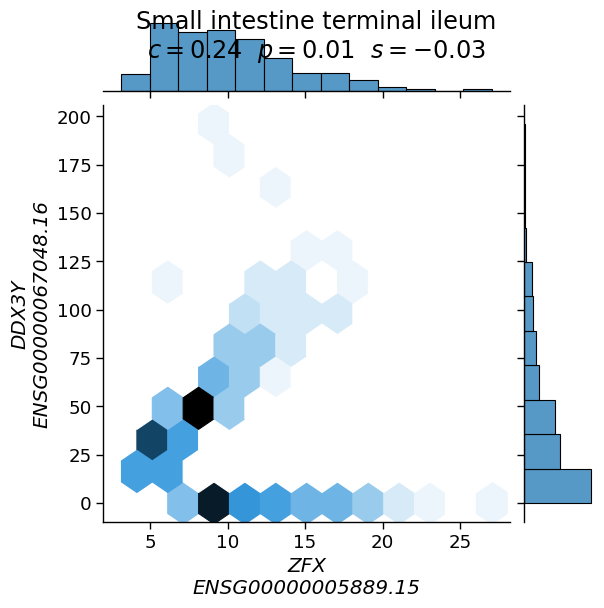

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000070950.9
gene2                                         ENSG00000183878.15
Gene 1 Symbol                                              RAD18
Gene 2 Symbol                                                UTY
ccc                                                     0.230225
pearson                                                 0.011086
spearman                                                0.011826
ccc_pearson_diff                                        0.219139
ccc_spearman_diff                                       0.218399
ccc_combined_distance                                   0.437538
ccc_mean_distance                                       0.218769
ccc_max_distance                                        0.219139
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.400631
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('RAD18', 'UTY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-RAD18_vs_UTY.svg')

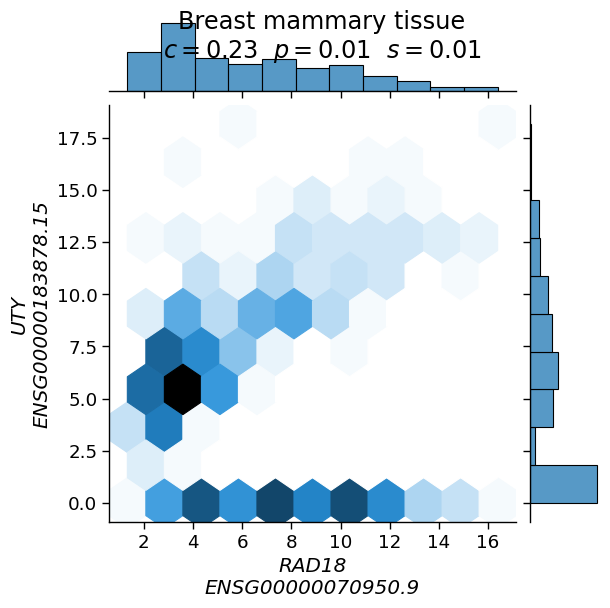

tissue                           brain_caudate_basal_ganglia
gene1                                      ENSG00000225470.7
gene2                                     ENSG00000067048.16
Gene 1 Symbol                                            JPX
Gene 2 Symbol                                          DDX3Y
ccc                                                 0.216797
pearson                                             0.012337
spearman                                            0.004864
ccc_pearson_diff                                     0.20446
ccc_spearman_diff                                   0.211933
ccc_combined_distance                               0.416393
ccc_mean_distance                                   0.208197
ccc_max_distance                                    0.211933
gene1_top1_metadata                                 SMSPLTRD
gene1_top1_ccc                                      0.155254
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (246, 2)'

('JPX', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-JPX_vs_DDX3Y.svg')

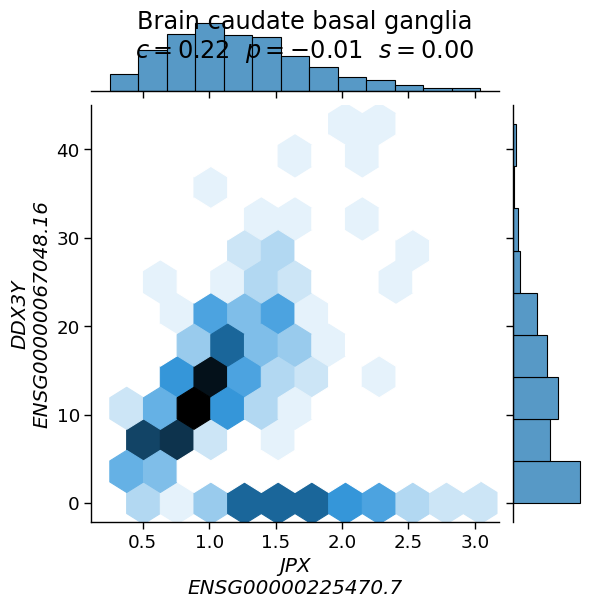

tissue                                           brain_amygdala
gene1                                        ENSG00000206159.10
gene2                                        ENSG00000130021.13
Gene 1 Symbol                                            GYG2P1
Gene 2 Symbol                                              PUDP
ccc                                                    0.212402
pearson                                                0.009995
spearman                                               0.012062
ccc_pearson_diff                                       0.202408
ccc_spearman_diff                                       0.20034
ccc_combined_distance                                  0.402748
ccc_mean_distance                                      0.201374
ccc_max_distance                                       0.202408
gene1_top1_metadata                                         SEX
gene1_top1_ccc                                         0.448938
gene1_top1_pvalue                       

'Tissue data: (152, 2)'

('GYG2P1', 'PUDP')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-GYG2P1_vs_PUDP.svg')

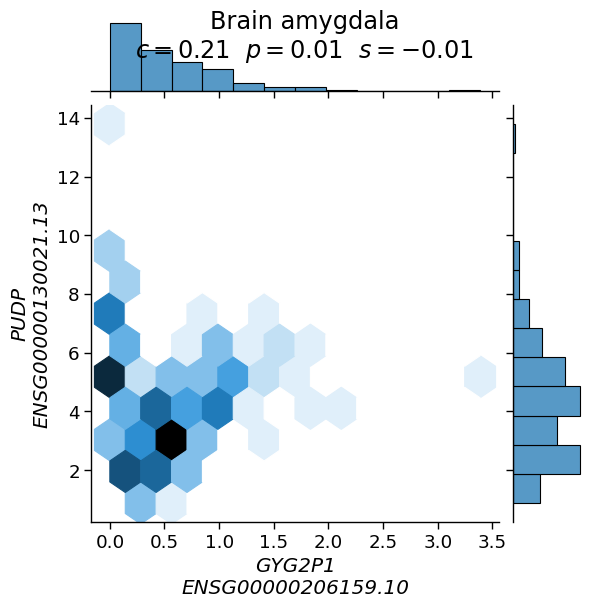

tissue                                             liver
gene1                                 ENSG00000086712.12
gene2                                 ENSG00000067048.16
Gene 1 Symbol                                      TXLNG
Gene 2 Symbol                                      DDX3Y
ccc                                             0.204712
pearson                                         0.022903
spearman                                        0.012558
ccc_pearson_diff                                0.181808
ccc_spearman_diff                               0.192154
ccc_combined_distance                           0.373962
ccc_mean_distance                               0.186981
ccc_max_distance                                0.192154
gene1_top1_metadata                                  SEX
gene1_top1_ccc                                  0.185065
gene1_top1_pvalue                                 0.0001
gene1_top2_metadata                             SMTSISCH
gene1_top2_ccc                 

'Tissue data: (226, 2)'

('TXLNG', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_liver-TXLNG_vs_DDX3Y.svg')

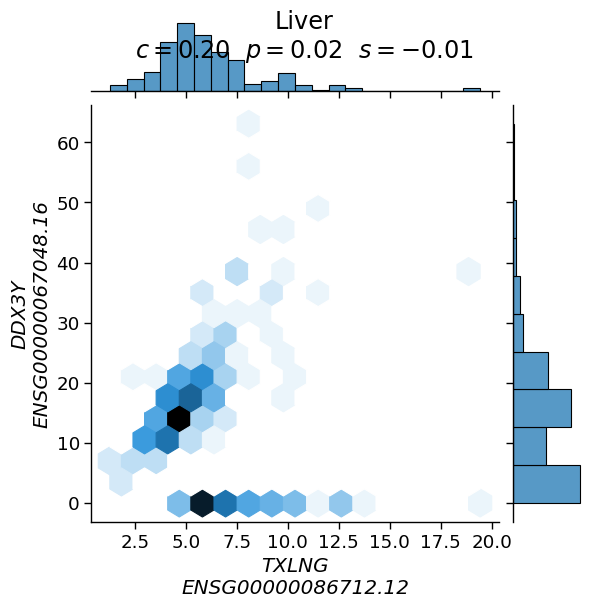

tissue                               brain_caudate_basal_ganglia
gene1                                         ENSG00000005889.15
gene2                                          ENSG00000260197.1
Gene 1 Symbol                                                ZFX
Gene 2 Symbol                                      RP11-424G14.1
ccc                                                     0.203613
pearson                                                 0.023209
spearman                                                0.003611
ccc_pearson_diff                                        0.180405
ccc_spearman_diff                                       0.200003
ccc_combined_distance                                   0.380407
ccc_mean_distance                                       0.190204
ccc_max_distance                                        0.200003
gene1_top1_metadata                                     SMRRNART
gene1_top1_ccc                                          0.211535
gene1_top1_pvalue        

'Tissue data: (246, 2)'

('ZFX', 'RP11-424G14.1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-ZFX_vs_RP11-424G14.1.svg')

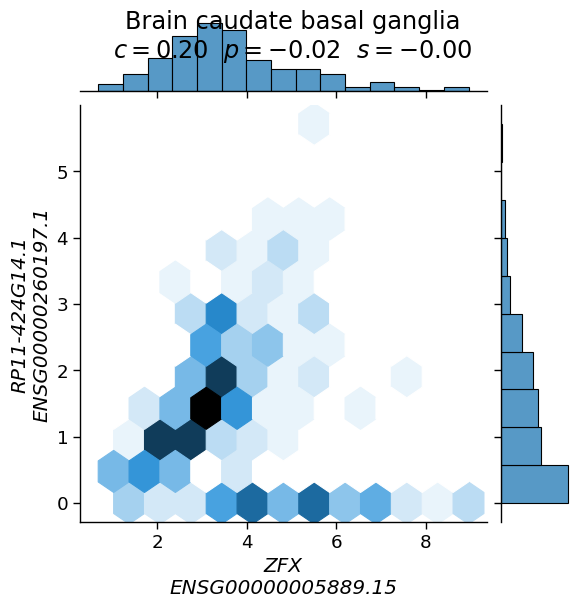

tissue                                   heart_left_ventricle
gene1                                      ENSG00000130021.13
gene2                                      ENSG00000129824.15
Gene 1 Symbol                                            PUDP
Gene 2 Symbol                                          RPS4Y1
ccc                                                  0.196533
pearson                                               0.00037
spearman                                             0.011475
ccc_pearson_diff                                     0.196163
ccc_spearman_diff                                    0.185059
ccc_combined_distance                                0.381222
ccc_mean_distance                                    0.190611
ccc_max_distance                                     0.196163
gene1_top1_metadata                                     SMRIN
gene1_top1_ccc                                       0.494025
gene1_top1_pvalue                                      0.0001
gene1_to

'Tissue data: (432, 2)'

('PUDP', 'RPS4Y1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_heart_left_ventricle-PUDP_vs_RPS4Y1.svg')

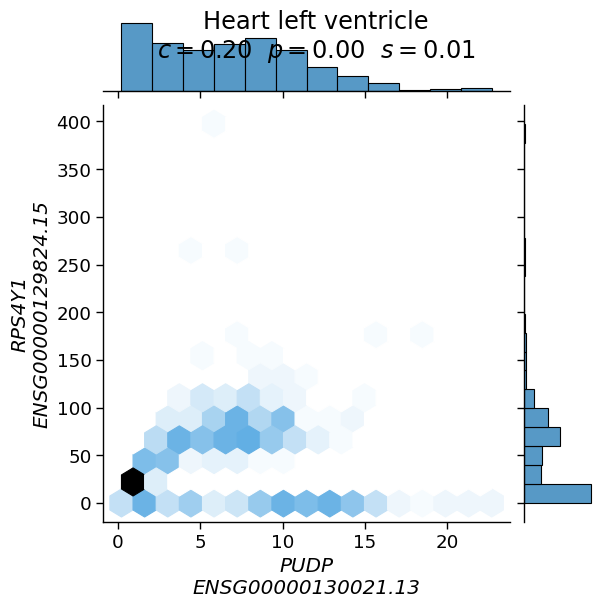

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000187764.11
gene2                                         ENSG00000183878.15
Gene 1 Symbol                                             SEMA4D
Gene 2 Symbol                                                UTY
ccc                                                      0.19397
pearson                                                  0.02005
spearman                                                0.005783
ccc_pearson_diff                                         0.17392
ccc_spearman_diff                                       0.188187
ccc_combined_distance                                   0.362106
ccc_mean_distance                                       0.181053
ccc_max_distance                                        0.188187
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.357552
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('SEMA4D', 'UTY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-SEMA4D_vs_UTY.svg')

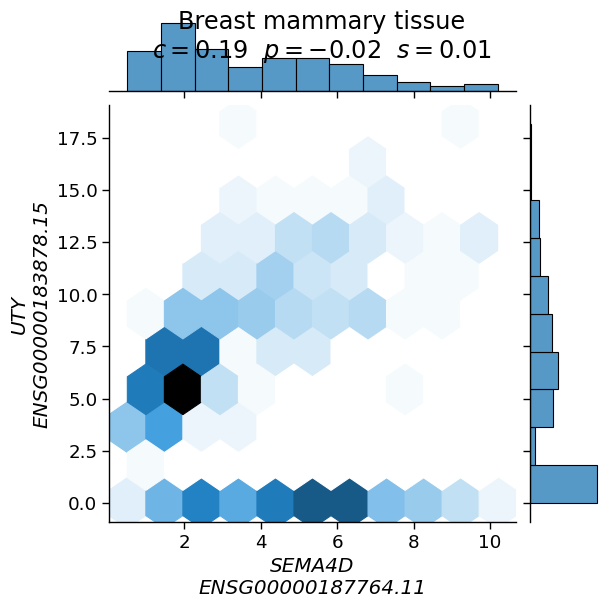

tissue                                        brain_amygdala
gene1                                     ENSG00000126012.11
gene2                                      ENSG00000198692.9
Gene 1 Symbol                                          KDM5C
Gene 2 Symbol                                         EIF1AY
ccc                                                  0.19043
pearson                                             0.022171
spearman                                            0.042694
ccc_pearson_diff                                    0.168259
ccc_spearman_diff                                   0.147736
ccc_combined_distance                               0.315994
ccc_mean_distance                                   0.157997
ccc_max_distance                                    0.168259
gene1_top1_metadata                                 SMRRNART
gene1_top1_ccc                                      0.330748
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (152, 2)'

('KDM5C', 'EIF1AY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-KDM5C_vs_EIF1AY.svg')

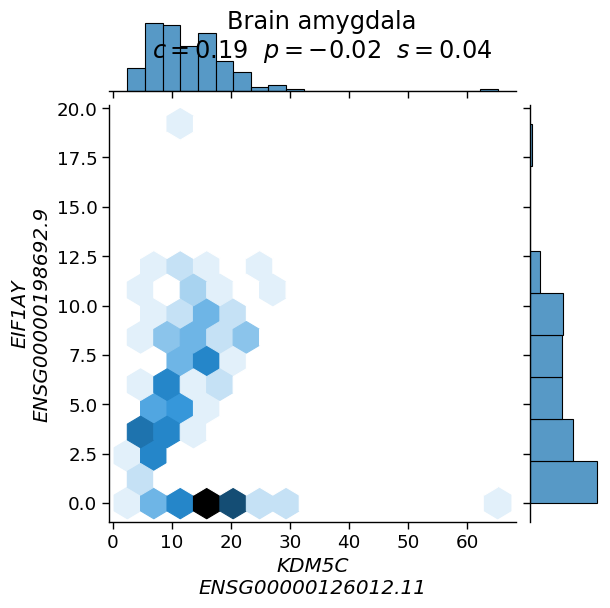

tissue                                  esophagus_mucosa
gene1                                 ENSG00000086712.12
gene2                                 ENSG00000067048.16
Gene 1 Symbol                                      TXLNG
Gene 2 Symbol                                      DDX3Y
ccc                                             0.190063
pearson                                         0.016754
spearman                                         0.01944
ccc_pearson_diff                                0.173309
ccc_spearman_diff                               0.170624
ccc_combined_distance                           0.343933
ccc_mean_distance                               0.171967
ccc_max_distance                                0.173309
gene1_top1_metadata                                 HGHT
gene1_top1_ccc                                  0.111928
gene1_top1_pvalue                                 0.0001
gene1_top2_metadata                                  SEX
gene1_top2_ccc                 

'Tissue data: (555, 2)'

('TXLNG', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_mucosa-TXLNG_vs_DDX3Y.svg')

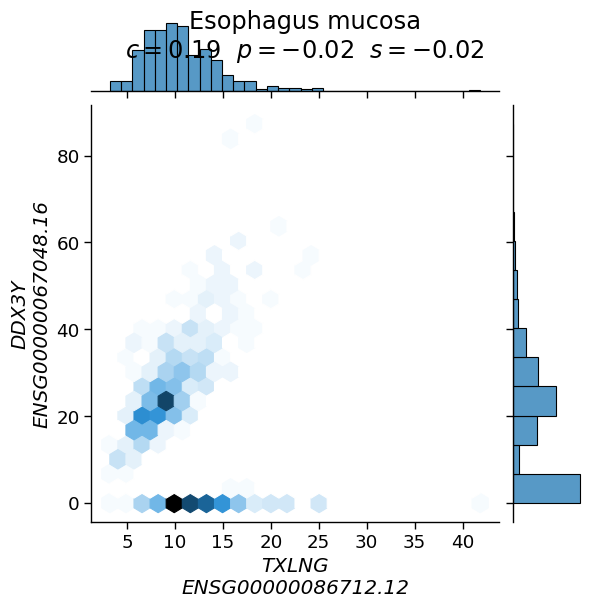

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000154620.5
gene2                                          ENSG00000176387.6
Gene 1 Symbol                                             TMSB4Y
Gene 2 Symbol                                            HSD11B2
ccc                                                     0.188599
pearson                                                 0.007217
spearman                                                0.004772
ccc_pearson_diff                                        0.181381
ccc_spearman_diff                                       0.183826
ccc_combined_distance                                   0.365208
ccc_mean_distance                                       0.182604
ccc_max_distance                                        0.183826
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TMSB4Y', 'HSD11B2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TMSB4Y_vs_HSD11B2.svg')

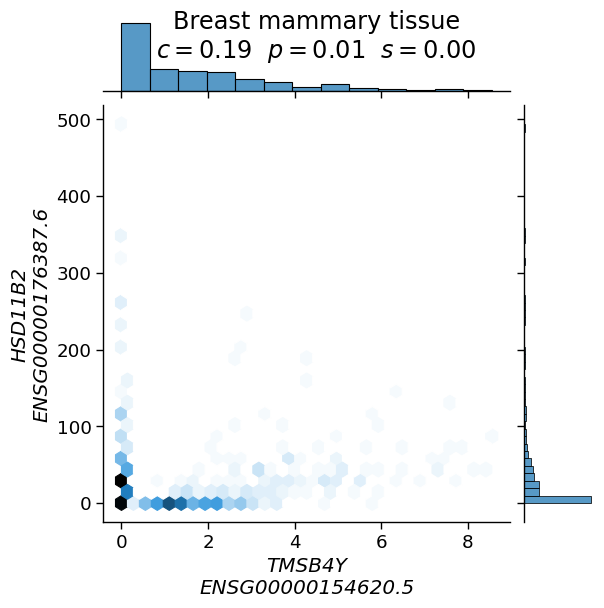

tissue                                 brain_hypothalamus
gene1                                  ENSG00000005889.15
gene2                                  ENSG00000012817.15
Gene 1 Symbol                                         ZFX
Gene 2 Symbol                                       KDM5D
ccc                                              0.187866
pearson                                          0.032166
spearman                                         0.020416
ccc_pearson_diff                                 0.155701
ccc_spearman_diff                                 0.16745
ccc_combined_distance                            0.323151
ccc_mean_distance                                0.161575
ccc_max_distance                                  0.16745
gene1_top1_metadata                              SMRRNART
gene1_top1_ccc                                   0.177163
gene1_top1_pvalue                                  0.0001
gene1_top2_metadata                              SMRRNANM
gene1_top2_ccc

'Tissue data: (202, 2)'

('ZFX', 'KDM5D')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hypothalamus-ZFX_vs_KDM5D.svg')

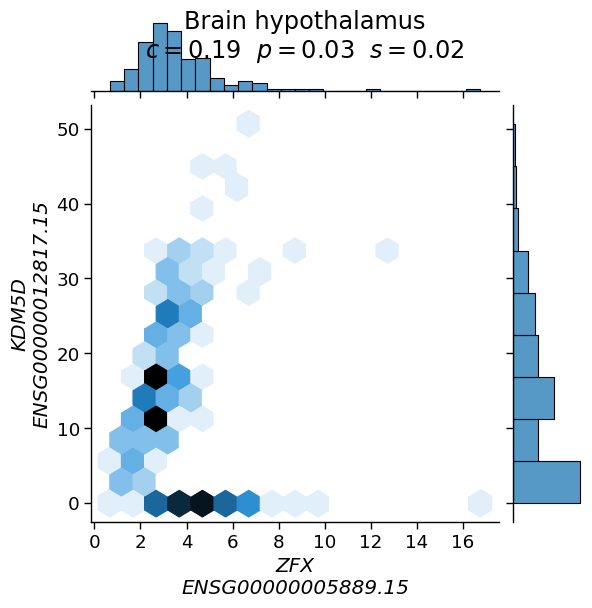

tissue                                          muscle_skeletal
gene1                                         ENSG00000215301.9
gene2                                        ENSG00000067646.11
Gene 1 Symbol                                             DDX3X
Gene 2 Symbol                                               ZFY
ccc                                                    0.187012
pearson                                                0.001592
spearman                                               0.017578
ccc_pearson_diff                                        0.18542
ccc_spearman_diff                                      0.169434
ccc_combined_distance                                  0.354854
ccc_mean_distance                                      0.177427
ccc_max_distance                                        0.18542
gene1_top1_metadata                                     DTHHRDY
gene1_top1_ccc                                         0.166511
gene1_top1_pvalue                       

'Tissue data: (803, 2)'

('DDX3X', 'ZFY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_muscle_skeletal-DDX3X_vs_ZFY.svg')

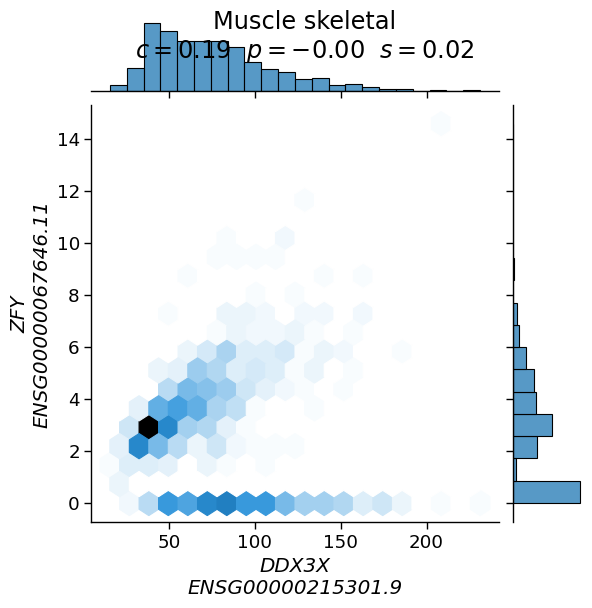

tissue                                              brain_cortex
gene1                                         ENSG00000130741.10
gene2                                         ENSG00000067646.11
Gene 1 Symbol                                             EIF2S3
Gene 2 Symbol                                                ZFY
ccc                                                     0.185669
pearson                                                 0.001101
spearman                                                0.030106
ccc_pearson_diff                                        0.184567
ccc_spearman_diff                                       0.155563
ccc_combined_distance                                   0.340131
ccc_mean_distance                                       0.170065
ccc_max_distance                                        0.184567
gene1_top1_metadata                                     SMRRNART
gene1_top1_ccc                                          0.141318
gene1_top1_pvalue        

'Tissue data: (255, 2)'

('EIF2S3', 'ZFY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_cortex-EIF2S3_vs_ZFY.svg')

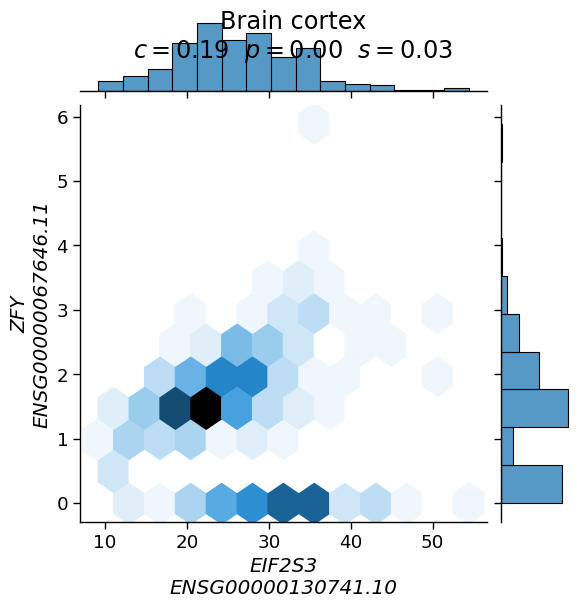

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000154620.5
gene2                                         ENSG00000103044.10
Gene 1 Symbol                                             TMSB4Y
Gene 2 Symbol                                               HAS3
ccc                                                     0.178833
pearson                                                 0.012642
spearman                                                0.025253
ccc_pearson_diff                                        0.166191
ccc_spearman_diff                                        0.15358
ccc_combined_distance                                   0.319771
ccc_mean_distance                                       0.159885
ccc_max_distance                                        0.166191
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TMSB4Y', 'HAS3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TMSB4Y_vs_HAS3.svg')

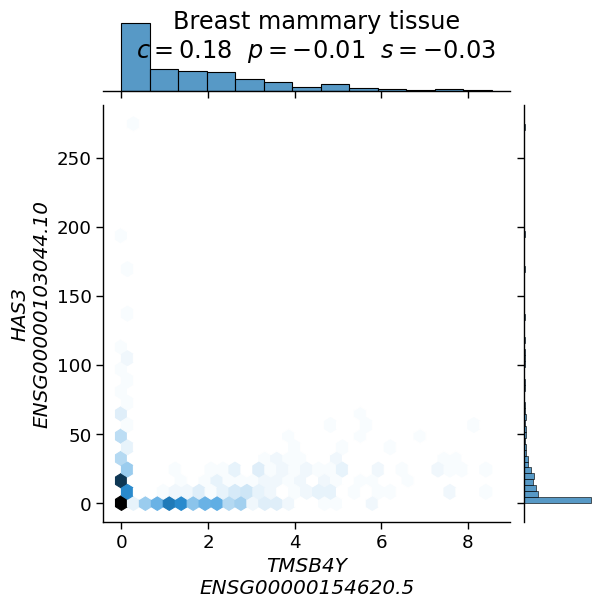

tissue                                            brain_amygdala
gene1                                          ENSG00000241859.6
gene2                                         ENSG00000147050.14
Gene 1 Symbol                                             ANOS2P
Gene 2 Symbol                                              KDM6A
ccc                                                     0.175781
pearson                                                 0.016678
spearman                                                0.008362
ccc_pearson_diff                                        0.159103
ccc_spearman_diff                                       0.167419
ccc_combined_distance                                   0.326523
ccc_mean_distance                                       0.163261
ccc_max_distance                                        0.167419
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                          0.448938
gene1_top1_pvalue        

'Tissue data: (152, 2)'

('ANOS2P', 'KDM6A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-ANOS2P_vs_KDM6A.svg')

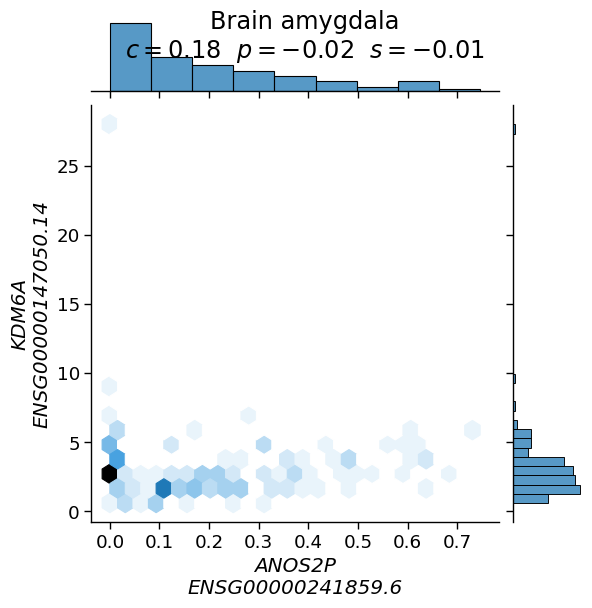

tissue                          cells_ebvtransformed_lymphocytes
gene1                                         ENSG00000130741.10
gene2                                         ENSG00000067048.16
Gene 1 Symbol                                             EIF2S3
Gene 2 Symbol                                              DDX3Y
ccc                                                     0.171753
pearson                                                   0.0084
spearman                                                0.009415
ccc_pearson_diff                                        0.163353
ccc_spearman_diff                                       0.162338
ccc_combined_distance                                   0.325691
ccc_mean_distance                                       0.162846
ccc_max_distance                                        0.163353
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                          0.098801
gene1_top1_pvalue        

'Tissue data: (174, 2)'

('EIF2S3', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_cells_ebvtransformed_lymphocytes-EIF2S3_vs_DDX3Y.svg')

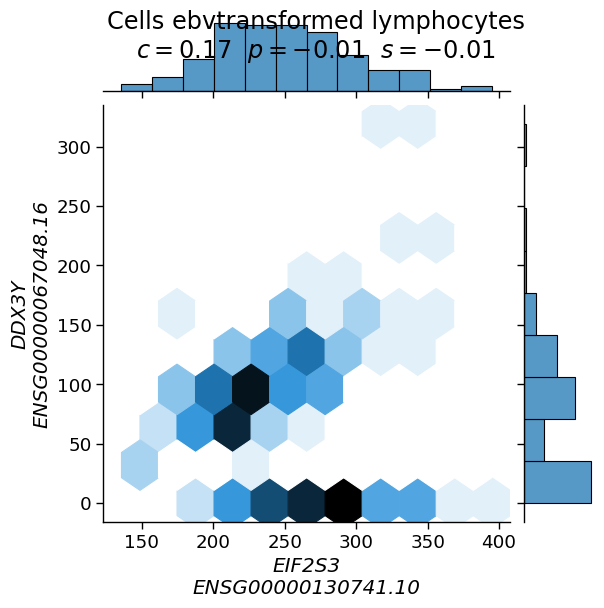

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000225302.2
gene2                                         ENSG00000183878.15
Gene 1 Symbol                                       RP11-539I5.1
Gene 2 Symbol                                                UTY
ccc                                                     0.171509
pearson                                                 0.011444
spearman                                                0.011322
ccc_pearson_diff                                        0.160065
ccc_spearman_diff                                       0.160187
ccc_combined_distance                                   0.320251
ccc_mean_distance                                       0.160126
ccc_max_distance                                        0.160187
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.347163
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('RP11-539I5.1', 'UTY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-RP11-539I5.1_vs_UTY.svg')

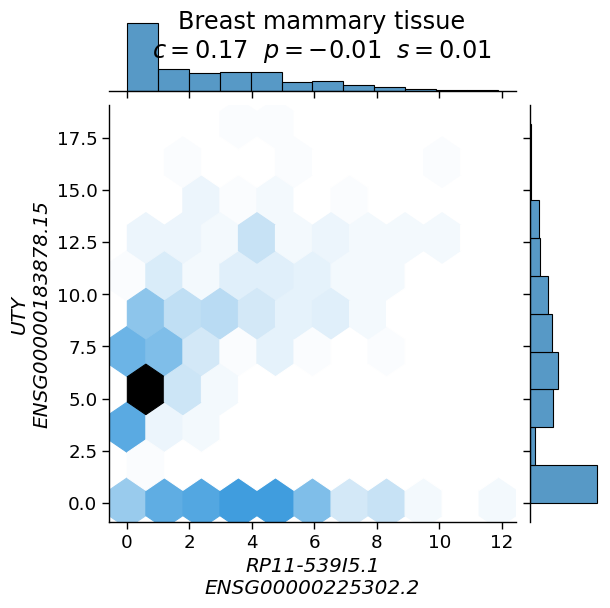

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000204060.6
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                              FOXO6
Gene 2 Symbol                                             TTTY15
ccc                                                     0.170532
pearson                                                 0.008942
spearman                                                0.004467
ccc_pearson_diff                                        0.161591
ccc_spearman_diff                                       0.166065
ccc_combined_distance                                   0.327656
ccc_mean_distance                                       0.163828
ccc_max_distance                                        0.166065
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                           0.24293
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('FOXO6', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-FOXO6_vs_TTTY15.svg')

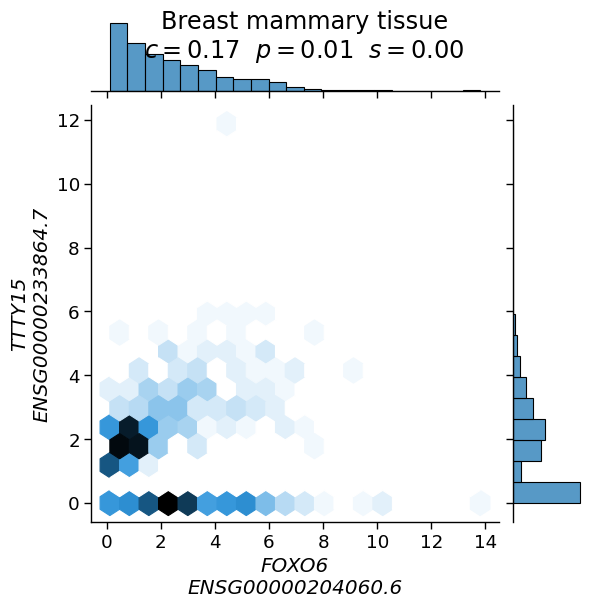

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000241127.7
gene2                                         ENSG00000129824.15
Gene 1 Symbol                                             YAE1D1
Gene 2 Symbol                                             RPS4Y1
ccc                                                     0.170532
pearson                                                 0.012024
spearman                                                0.019073
ccc_pearson_diff                                        0.158508
ccc_spearman_diff                                       0.151459
ccc_combined_distance                                   0.309967
ccc_mean_distance                                       0.154984
ccc_max_distance                                        0.158508
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                           0.18619
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('YAE1D1', 'RPS4Y1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-YAE1D1_vs_RPS4Y1.svg')

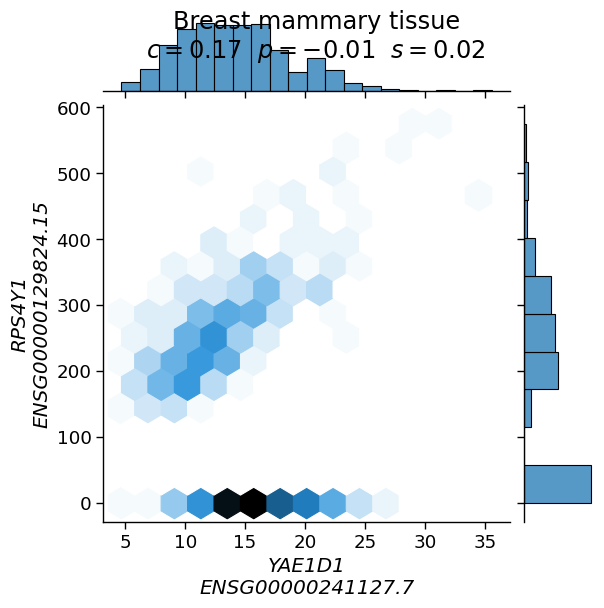

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000197978.9
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                           GOLGA6L9
Gene 2 Symbol                                             TTTY15
ccc                                                     0.170044
pearson                                                 0.012421
spearman                                                0.030716
ccc_pearson_diff                                        0.157623
ccc_spearman_diff                                       0.139328
ccc_combined_distance                                   0.296951
ccc_mean_distance                                       0.148476
ccc_max_distance                                        0.157623
gene1_top1_metadata                                     SMEXNCRT
gene1_top1_ccc                                          0.288025
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('GOLGA6L9', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-GOLGA6L9_vs_TTTY15.svg')

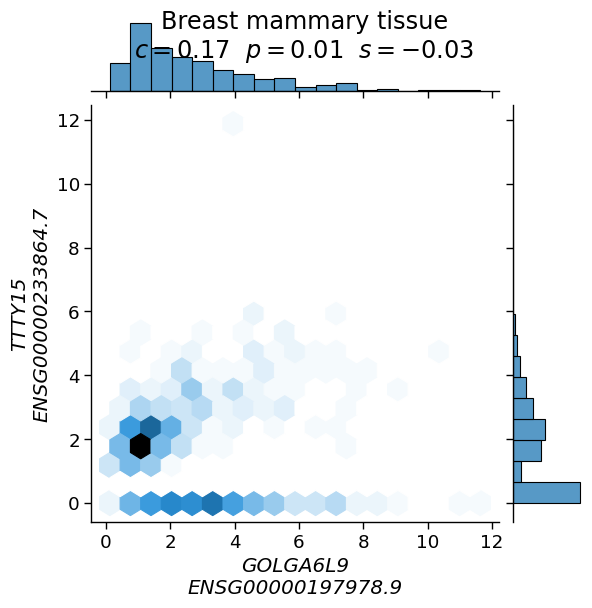

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000184949.15
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                            FAM227A
Gene 2 Symbol                                             TTTY15
ccc                                                     0.169678
pearson                                                 0.011292
spearman                                                0.023132
ccc_pearson_diff                                        0.158386
ccc_spearman_diff                                       0.146545
ccc_combined_distance                                   0.304932
ccc_mean_distance                                       0.152466
ccc_max_distance                                        0.158386
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.357552
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('FAM227A', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-FAM227A_vs_TTTY15.svg')

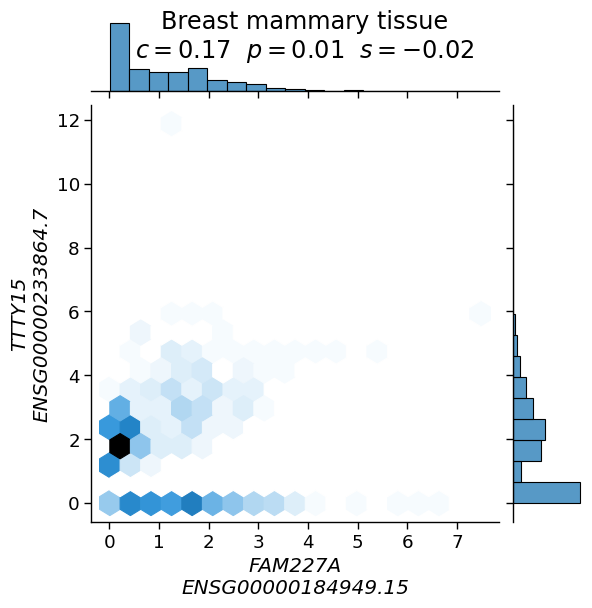

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000183317.16
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                             EPHA10
Gene 2 Symbol                                             TTTY15
ccc                                                     0.167114
pearson                                                 0.006912
spearman                                                0.030884
ccc_pearson_diff                                        0.160202
ccc_spearman_diff                                        0.13623
ccc_combined_distance                                   0.296432
ccc_mean_distance                                       0.148216
ccc_max_distance                                        0.160202
gene1_top1_metadata                                     SMNTRART
gene1_top1_ccc                                             0.312
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('EPHA10', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-EPHA10_vs_TTTY15.svg')

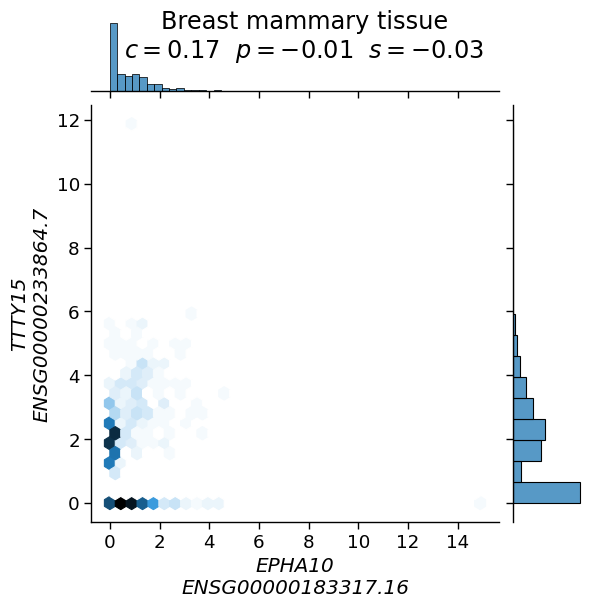

tissue                                heart_atrial_appendage
gene1                                     ENSG00000126012.11
gene2                                     ENSG00000067048.16
Gene 1 Symbol                                          KDM5C
Gene 2 Symbol                                          DDX3Y
ccc                                                  0.16626
pearson                                             0.012108
spearman                                            0.009262
ccc_pearson_diff                                    0.154152
ccc_spearman_diff                                   0.156998
ccc_combined_distance                                0.31115
ccc_mean_distance                                   0.155575
ccc_max_distance                                    0.156998
gene1_top1_metadata                                      SEX
gene1_top1_ccc                                      0.106216
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (429, 2)'

('KDM5C', 'DDX3Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_heart_atrial_appendage-KDM5C_vs_DDX3Y.svg')

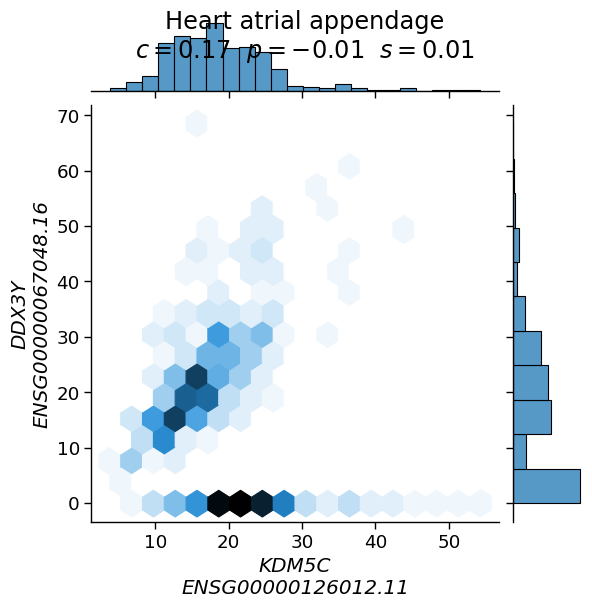

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000233864.7
gene2                                          ENSG00000134716.9
Gene 1 Symbol                                             TTTY15
Gene 2 Symbol                                             CYP2J2
ccc                                                     0.165894
pearson                                                 0.004978
spearman                                                0.025085
ccc_pearson_diff                                        0.160915
ccc_spearman_diff                                       0.140808
ccc_combined_distance                                   0.301723
ccc_mean_distance                                       0.150862
ccc_max_distance                                        0.160915
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TTTY15', 'CYP2J2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TTTY15_vs_CYP2J2.svg')

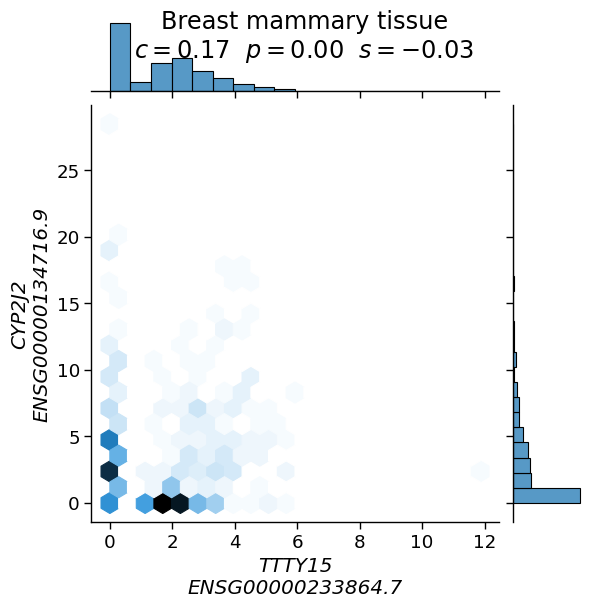

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000233864.7
gene2                                         ENSG00000114993.16
Gene 1 Symbol                                             TTTY15
Gene 2 Symbol                                               RTKN
ccc                                                     0.165894
pearson                                                 0.014977
spearman                                                0.019424
ccc_pearson_diff                                        0.150917
ccc_spearman_diff                                       0.146469
ccc_combined_distance                                   0.297386
ccc_mean_distance                                       0.148693
ccc_max_distance                                        0.150917
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TTTY15', 'RTKN')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TTTY15_vs_RTKN.svg')

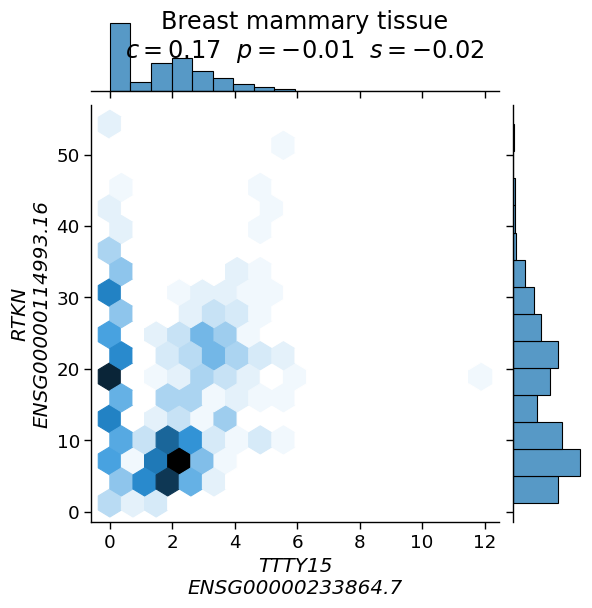

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000233864.7
gene2                                          ENSG00000112796.9
Gene 1 Symbol                                             TTTY15
Gene 2 Symbol                                              ENPP5
ccc                                                     0.164795
pearson                                                 0.013741
spearman                                                0.001875
ccc_pearson_diff                                        0.151054
ccc_spearman_diff                                        0.16292
ccc_combined_distance                                   0.313974
ccc_mean_distance                                       0.156987
ccc_max_distance                                         0.16292
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TTTY15', 'ENPP5')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TTTY15_vs_ENPP5.svg')

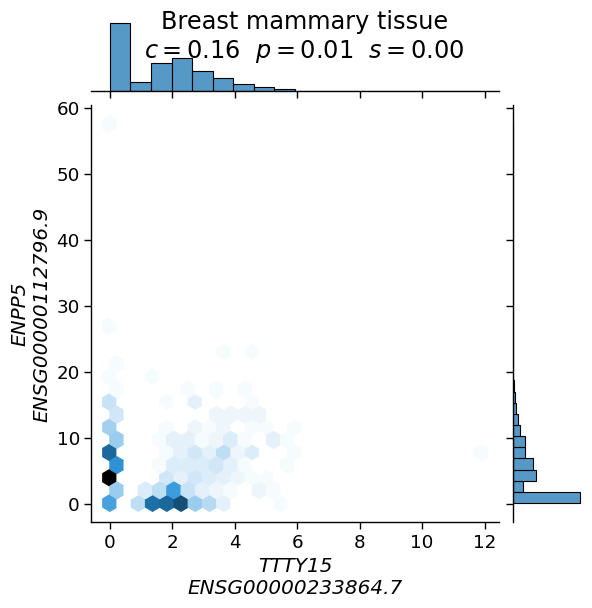

tissue                                      colon_transverse
gene1                                      ENSG00000224060.3
gene2                                     ENSG00000129824.15
Gene 1 Symbol                                         ARSEP1
Gene 2 Symbol                                         RPS4Y1
ccc                                                 0.164673
pearson                                             0.011841
spearman                                            0.017548
ccc_pearson_diff                                    0.152832
ccc_spearman_diff                                   0.147125
ccc_combined_distance                               0.299957
ccc_mean_distance                                   0.149979
ccc_max_distance                                    0.152832
gene1_top1_metadata                                      SEX
gene1_top1_ccc                                      0.100474
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (406, 2)'

('ARSEP1', 'RPS4Y1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_colon_transverse-ARSEP1_vs_RPS4Y1.svg')

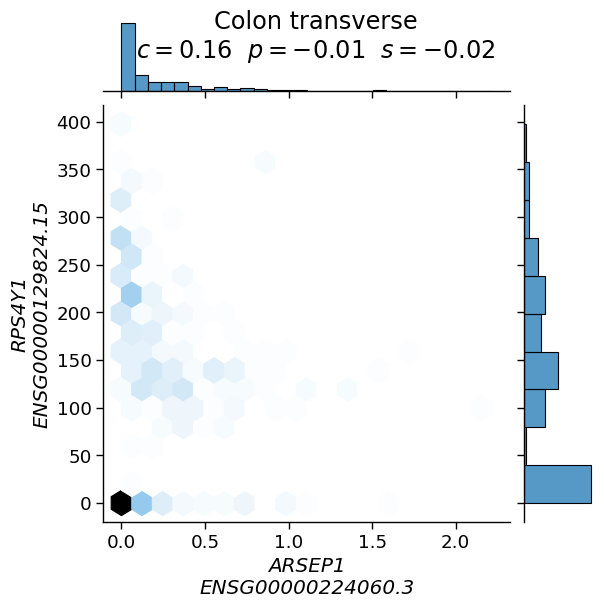

tissue                               brain_putamen_basal_ganglia
gene1                                          ENSG00000227289.1
gene2                                         ENSG00000005889.15
Gene 1 Symbol                                             HSFY3P
Gene 2 Symbol                                                ZFX
ccc                                                     0.164551
pearson                                                 0.004356
spearman                                                0.014458
ccc_pearson_diff                                        0.160194
ccc_spearman_diff                                       0.150093
ccc_combined_distance                                   0.310287
ccc_mean_distance                                       0.155144
ccc_max_distance                                        0.160194
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                          0.284324
gene1_top1_pvalue        

'Tissue data: (205, 2)'

('HSFY3P', 'ZFX')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_putamen_basal_ganglia-HSFY3P_vs_ZFX.svg')

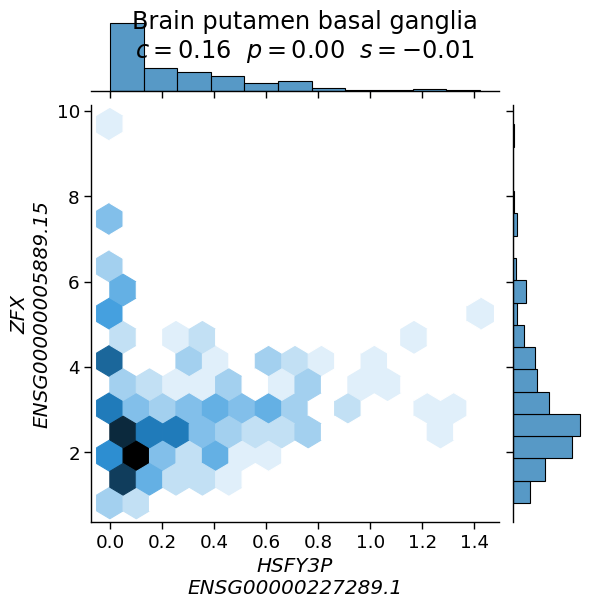

tissue                                            brain_amygdala
gene1                                          ENSG00000229236.1
gene2                                         ENSG00000147050.14
Gene 1 Symbol                                             TTTY10
Gene 2 Symbol                                              KDM6A
ccc                                                     0.164185
pearson                                                 0.017868
spearman                                                0.007019
ccc_pearson_diff                                        0.146317
ccc_spearman_diff                                       0.157166
ccc_combined_distance                                   0.303482
ccc_mean_distance                                       0.151741
ccc_max_distance                                        0.157166
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                          0.391259
gene1_top1_pvalue        

'Tissue data: (152, 2)'

('TTTY10', 'KDM6A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-TTTY10_vs_KDM6A.svg')

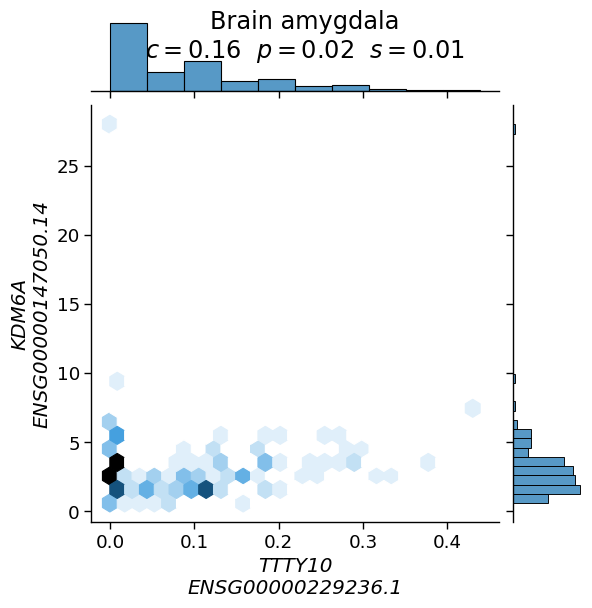

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000259429.5
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                           UBE2Q2P2
Gene 2 Symbol                                             TTTY15
ccc                                                      0.16394
pearson                                                 0.004704
spearman                                                0.022552
ccc_pearson_diff                                        0.159237
ccc_spearman_diff                                       0.141388
ccc_combined_distance                                   0.300625
ccc_mean_distance                                       0.150312
ccc_max_distance                                        0.159237
gene1_top1_metadata                                     SMNTRART
gene1_top1_ccc                                          0.342026
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('UBE2Q2P2', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-UBE2Q2P2_vs_TTTY15.svg')

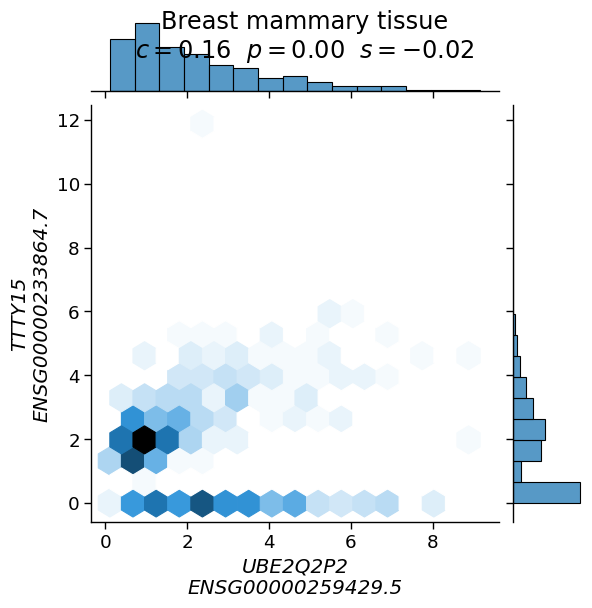

tissue                                      colon_transverse
gene1                                      ENSG00000215301.9
gene2                                     ENSG00000114374.12
Gene 1 Symbol                                          DDX3X
Gene 2 Symbol                                          USP9Y
ccc                                                 0.163696
pearson                                             0.015152
spearman                                            0.013481
ccc_pearson_diff                                    0.148544
ccc_spearman_diff                                   0.150215
ccc_combined_distance                               0.298759
ccc_mean_distance                                    0.14938
ccc_max_distance                                    0.150215
gene1_top1_metadata                                 SMRRNART
gene1_top1_ccc                                      0.173285
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (406, 2)'

('DDX3X', 'USP9Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_colon_transverse-DDX3X_vs_USP9Y.svg')

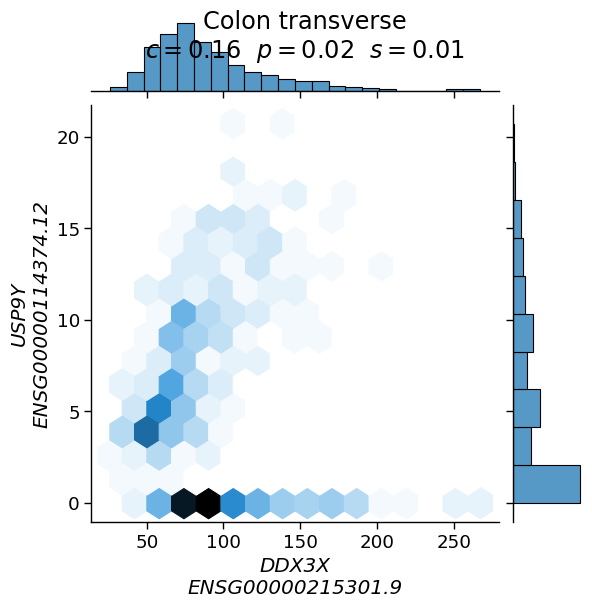

tissue                                  minor_salivary_gland
gene1                                     ENSG00000205664.10
gene2                                     ENSG00000099725.14
Gene 1 Symbol                                  RP11-706O15.1
Gene 2 Symbol                                           PRKY
ccc                                                 0.163574
pearson                                              0.02832
spearman                                            0.039703
ccc_pearson_diff                                    0.135254
ccc_spearman_diff                                   0.123871
ccc_combined_distance                               0.259125
ccc_mean_distance                                   0.129562
ccc_max_distance                                    0.135254
gene1_top1_metadata                                     HGHT
gene1_top1_ccc                                      0.114729
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (162, 2)'

('RP11-706O15.1', 'PRKY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_minor_salivary_gland-RP11-706O15.1_vs_PRKY.svg')

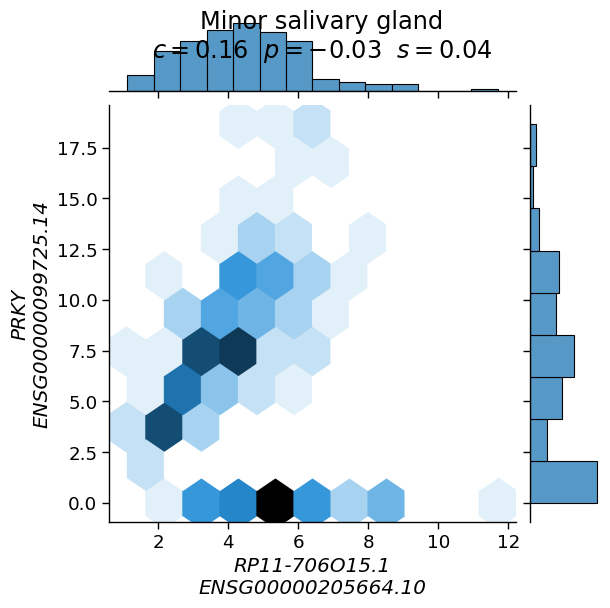

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000133619.17
gene2                                         ENSG00000131002.11
Gene 1 Symbol                                              KRBA1
Gene 2 Symbol                                             TXLNGY
ccc                                                     0.163208
pearson                                                   0.0035
spearman                                                0.025681
ccc_pearson_diff                                        0.159708
ccc_spearman_diff                                       0.137527
ccc_combined_distance                                   0.297235
ccc_mean_distance                                       0.148618
ccc_max_distance                                        0.159708
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.307129
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('KRBA1', 'TXLNGY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-KRBA1_vs_TXLNGY.svg')

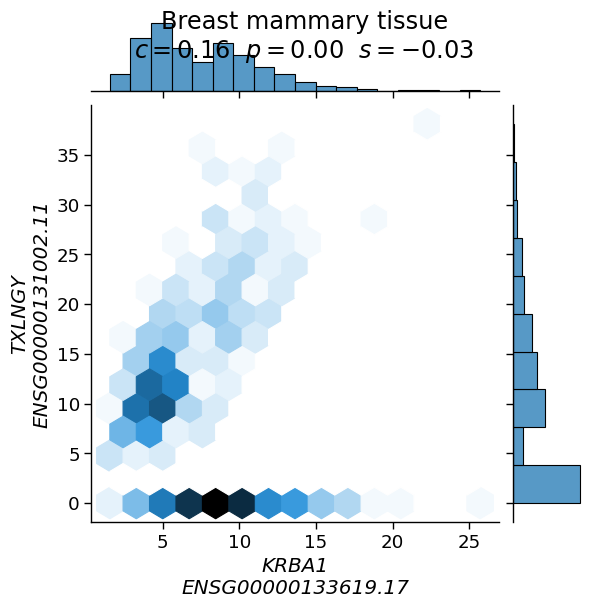

tissue                          brain_spinal_cord_cervical_c1
gene1                                      ENSG00000130021.13
gene2                                      ENSG00000012817.15
Gene 1 Symbol                                            PUDP
Gene 2 Symbol                                           KDM5D
ccc                                                   0.16272
pearson                                              0.033508
spearman                                             0.036285
ccc_pearson_diff                                     0.129211
ccc_spearman_diff                                    0.126434
ccc_combined_distance                                0.255646
ccc_mean_distance                                    0.127823
ccc_max_distance                                     0.129211
gene1_top1_metadata                                  SMRRNART
gene1_top1_ccc                                       0.368178
gene1_top1_pvalue                                      0.0001
gene1_to

'Tissue data: (159, 2)'

('PUDP', 'KDM5D')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_spinal_cord_cervical_c1-PUDP_vs_KDM5D.svg')

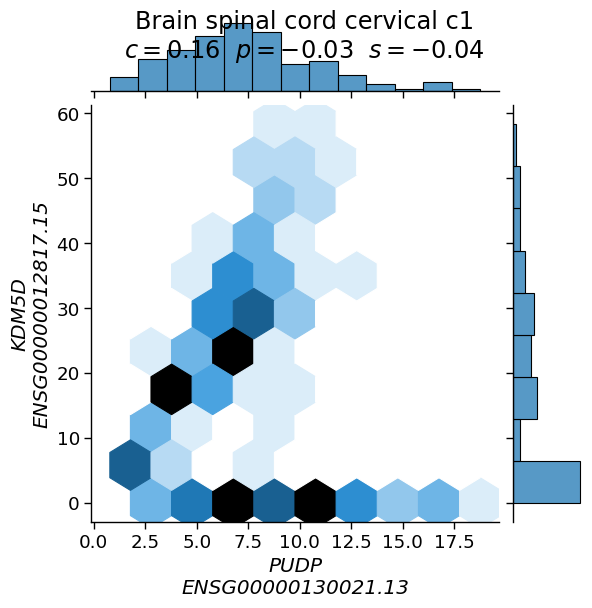

tissue                                           muscle_skeletal
gene1                                          ENSG00000188001.9
gene2                                         ENSG00000131002.11
Gene 1 Symbol                                              TPRG1
Gene 2 Symbol                                             TXLNGY
ccc                                                     0.162598
pearson                                                 0.010269
spearman                                                0.000019
ccc_pearson_diff                                        0.152328
ccc_spearman_diff                                       0.162578
ccc_combined_distance                                   0.314907
ccc_mean_distance                                       0.157453
ccc_max_distance                                        0.162578
gene1_top1_metadata                                     SMNTRART
gene1_top1_ccc                                          0.114479
gene1_top1_pvalue        

'Tissue data: (803, 2)'

('TPRG1', 'TXLNGY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_muscle_skeletal-TPRG1_vs_TXLNGY.svg')

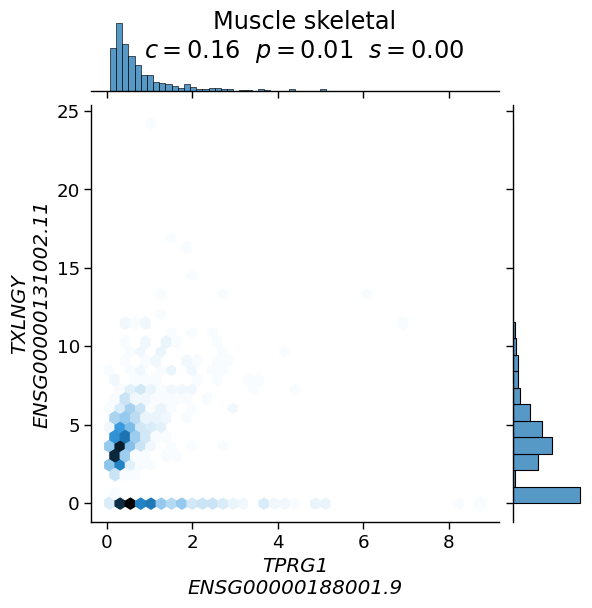

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000233864.7
gene2                                         ENSG00000197077.13
Gene 1 Symbol                                             TTTY15
Gene 2 Symbol                                           KIAA1671
ccc                                                     0.162598
pearson                                                 0.014992
spearman                                                0.003019
ccc_pearson_diff                                        0.147606
ccc_spearman_diff                                       0.159578
ccc_combined_distance                                   0.307184
ccc_mean_distance                                       0.153592
ccc_max_distance                                        0.159578
gene1_top1_metadata                                          SEX
gene1_top1_ccc                                           0.53812
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('TTTY15', 'KIAA1671')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-TTTY15_vs_KIAA1671.svg')

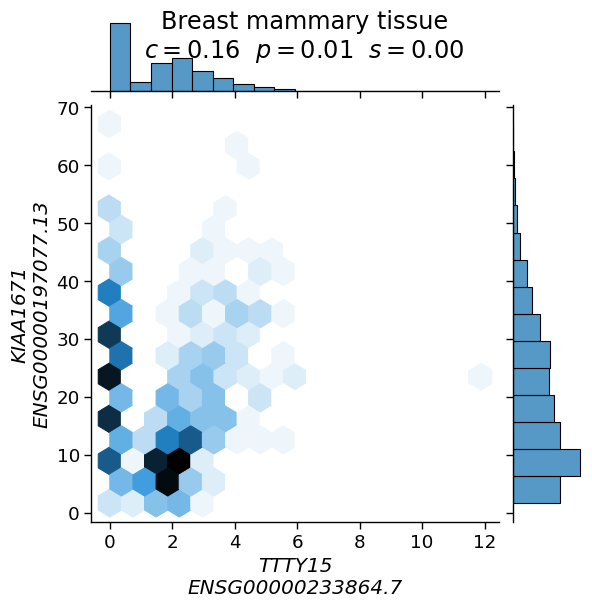

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000066084.12
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                              DIP2B
Gene 2 Symbol                                             TTTY15
ccc                                                     0.162109
pearson                                                  0.02095
spearman                                                0.007179
ccc_pearson_diff                                        0.141159
ccc_spearman_diff                                        0.15493
ccc_combined_distance                                   0.296089
ccc_mean_distance                                       0.148045
ccc_max_distance                                         0.15493
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.316909
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('DIP2B', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-DIP2B_vs_TTTY15.svg')

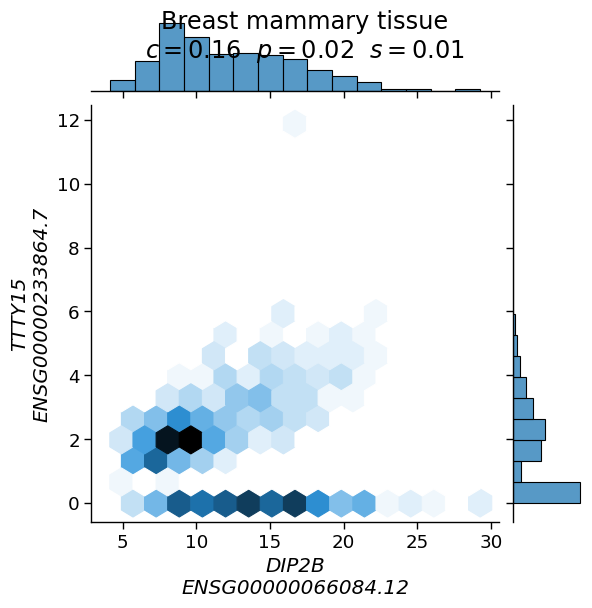

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000100461.17
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                              RBM23
Gene 2 Symbol                                             TTTY15
ccc                                                       0.1604
pearson                                                 0.001309
spearman                                                0.000314
ccc_pearson_diff                                        0.159091
ccc_spearman_diff                                       0.160086
ccc_combined_distance                                   0.319177
ccc_mean_distance                                       0.159589
ccc_max_distance                                        0.160086
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.326842
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('RBM23', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-RBM23_vs_TTTY15.svg')

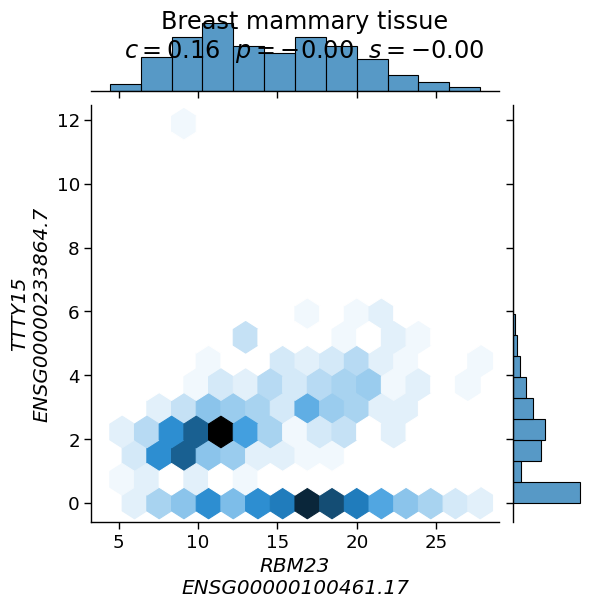

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000198929.12
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                             NOS1AP
Gene 2 Symbol                                             TTTY15
ccc                                                     0.159302
pearson                                                 0.001514
spearman                                                0.019348
ccc_pearson_diff                                        0.157787
ccc_spearman_diff                                       0.139954
ccc_combined_distance                                   0.297741
ccc_mean_distance                                        0.14887
ccc_max_distance                                        0.157787
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.326842
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('NOS1AP', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-NOS1AP_vs_TTTY15.svg')

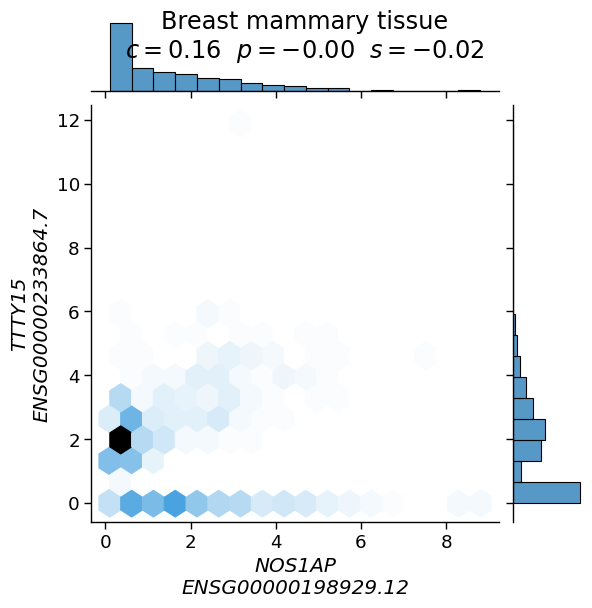

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000243789.10
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                              JMJD7
Gene 2 Symbol                                             TTTY15
ccc                                                     0.158325
pearson                                                 0.006638
spearman                                                0.007404
ccc_pearson_diff                                        0.151688
ccc_spearman_diff                                       0.150921
ccc_combined_distance                                   0.302608
ccc_mean_distance                                       0.151304
ccc_max_distance                                        0.151688
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.307129
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('JMJD7', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-JMJD7_vs_TTTY15.svg')

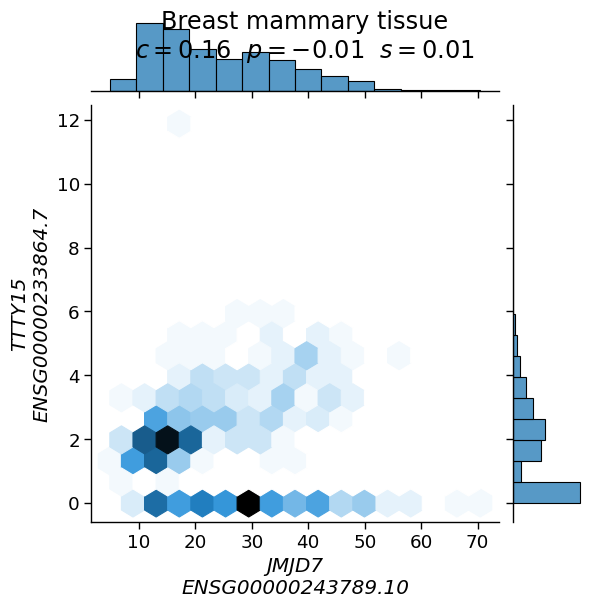

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000131067.16
gene2                                          ENSG00000176728.7
Gene 1 Symbol                                               GGT7
Gene 2 Symbol                                             TTTY14
ccc                                                     0.158325
pearson                                                 0.006626
spearman                                                 0.00655
ccc_pearson_diff                                        0.151699
ccc_spearman_diff                                       0.151775
ccc_combined_distance                                   0.303474
ccc_mean_distance                                       0.151737
ccc_max_distance                                        0.151775
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.316909
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('GGT7', 'TTTY14')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-GGT7_vs_TTTY14.svg')

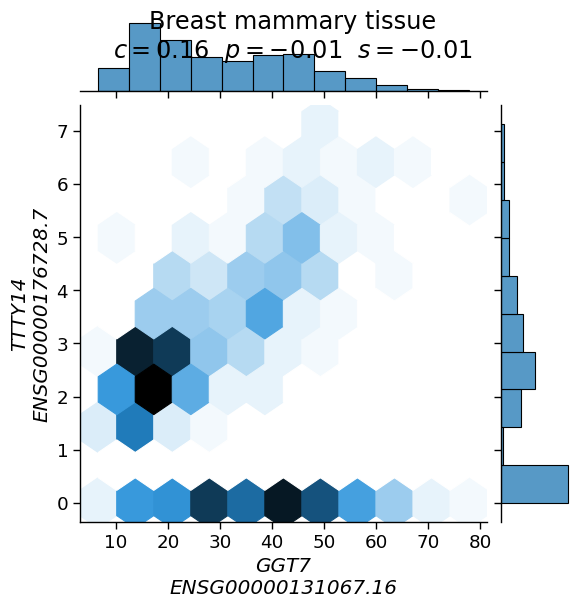

tissue                                     breast_mammary_tissue
gene1                                         ENSG00000140718.20
gene2                                         ENSG00000165246.13
Gene 1 Symbol                                                FTO
Gene 2 Symbol                                             NLGN4Y
ccc                                                     0.157471
pearson                                                 0.007301
spearman                                                0.007267
ccc_pearson_diff                                        0.150169
ccc_spearman_diff                                       0.150204
ccc_combined_distance                                   0.300373
ccc_mean_distance                                       0.150187
ccc_max_distance                                        0.150204
gene1_top1_metadata                                     SMTRSCPT
gene1_top1_ccc                                          0.326842
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('FTO', 'NLGN4Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-FTO_vs_NLGN4Y.svg')

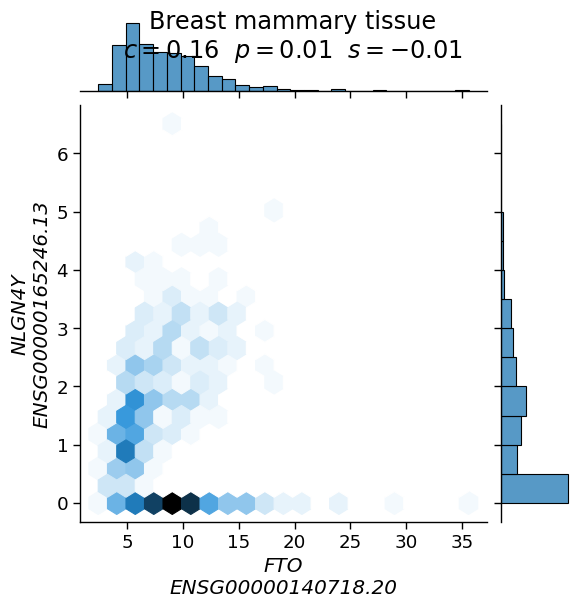

tissue                                 brain_hypothalamus
gene1                                  ENSG00000005889.15
gene2                                   ENSG00000233864.7
Gene 1 Symbol                                         ZFX
Gene 2 Symbol                                      TTTY15
ccc                                               0.15686
pearson                                          0.011818
spearman                                         0.005859
ccc_pearson_diff                                 0.145042
ccc_spearman_diff                                0.151001
ccc_combined_distance                            0.296043
ccc_mean_distance                                0.148022
ccc_max_distance                                 0.151001
gene1_top1_metadata                              SMRRNART
gene1_top1_ccc                                   0.177163
gene1_top1_pvalue                                  0.0001
gene1_top2_metadata                              SMRRNANM
gene1_top2_ccc

'Tissue data: (202, 2)'

('ZFX', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hypothalamus-ZFX_vs_TTTY15.svg')

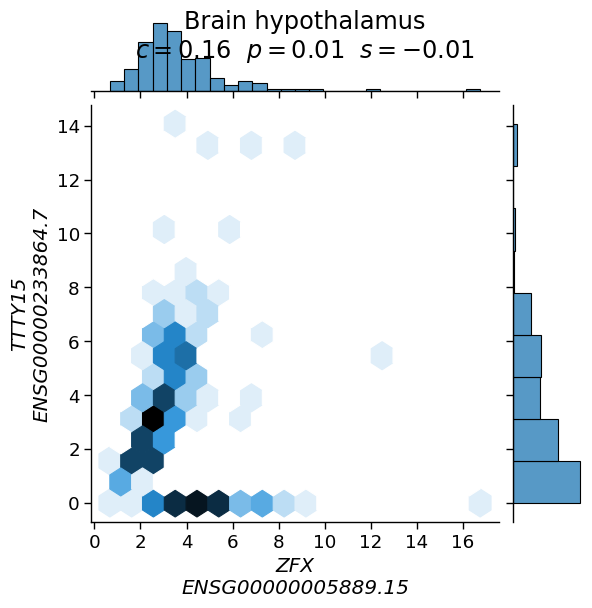

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000177051.5
gene2                                          ENSG00000176728.7
Gene 1 Symbol                                             FBXO46
Gene 2 Symbol                                             TTTY14
ccc                                                     0.156494
pearson                                                 0.001119
spearman                                                0.018906
ccc_pearson_diff                                        0.155375
ccc_spearman_diff                                       0.137589
ccc_combined_distance                                   0.292964
ccc_mean_distance                                       0.146482
ccc_max_distance                                        0.155375
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.302296
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('FBXO46', 'TTTY14')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-FBXO46_vs_TTTY14.svg')

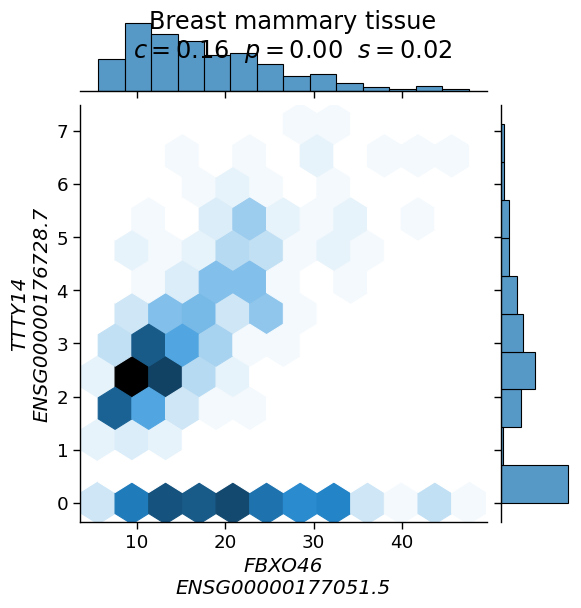

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000243943.9
gene2                                          ENSG00000233864.7
Gene 1 Symbol                                             ZNF512
Gene 2 Symbol                                             TTTY15
ccc                                                     0.155884
pearson                                                 0.002306
spearman                                                0.000252
ccc_pearson_diff                                        0.153578
ccc_spearman_diff                                       0.155631
ccc_combined_distance                                   0.309209
ccc_mean_distance                                       0.154605
ccc_max_distance                                        0.155631
gene1_top1_metadata                                     SMNTRART
gene1_top1_ccc                                          0.321857
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('ZNF512', 'TTTY15')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-ZNF512_vs_TTTY15.svg')

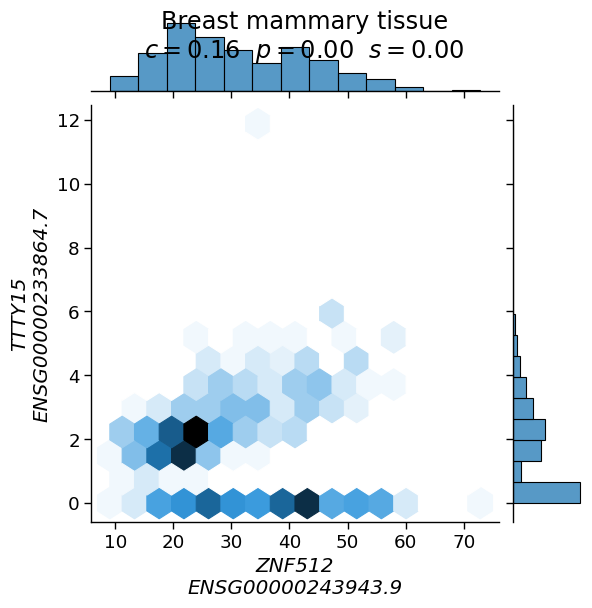

tissue                                        brain_amygdala
gene1                                     ENSG00000126012.11
gene2                                      ENSG00000154620.5
Gene 1 Symbol                                          KDM5C
Gene 2 Symbol                                         TMSB4Y
ccc                                                 0.155151
pearson                                             0.039215
spearman                                             0.02153
ccc_pearson_diff                                    0.115936
ccc_spearman_diff                                   0.133621
ccc_combined_distance                               0.249557
ccc_mean_distance                                   0.124779
ccc_max_distance                                    0.133621
gene1_top1_metadata                                 SMRRNART
gene1_top1_ccc                                      0.330748
gene1_top1_pvalue                                     0.0001
gene1_top2_metadata     

'Tissue data: (152, 2)'

('KDM5C', 'TMSB4Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_amygdala-KDM5C_vs_TMSB4Y.svg')

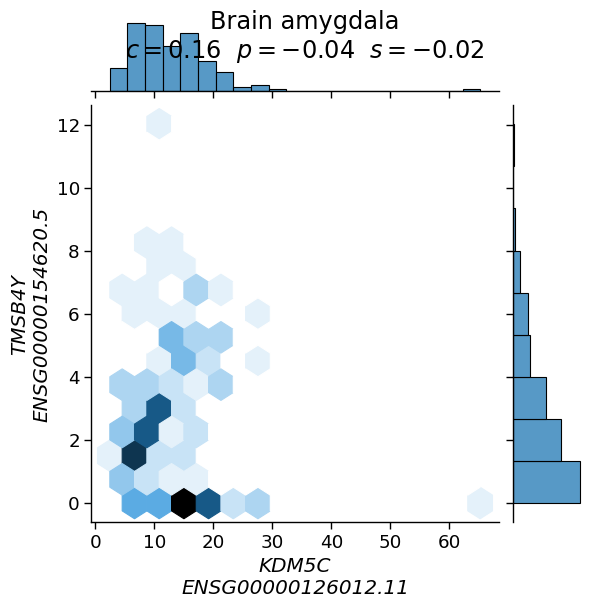

tissue                                     breast_mammary_tissue
gene1                                          ENSG00000164715.5
gene2                                         ENSG00000099725.14
Gene 1 Symbol                                              LMTK2
Gene 2 Symbol                                               PRKY
ccc                                                     0.155029
pearson                                                 0.002705
spearman                                                0.010017
ccc_pearson_diff                                        0.152325
ccc_spearman_diff                                       0.145012
ccc_combined_distance                                   0.297337
ccc_mean_distance                                       0.148668
ccc_max_distance                                        0.152325
gene1_top1_metadata                                     SMGNSDTC
gene1_top1_ccc                                          0.316909
gene1_top1_pvalue        

'Tissue data: (459, 2)'

('LMTK2', 'PRKY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-LMTK2_vs_PRKY.svg')

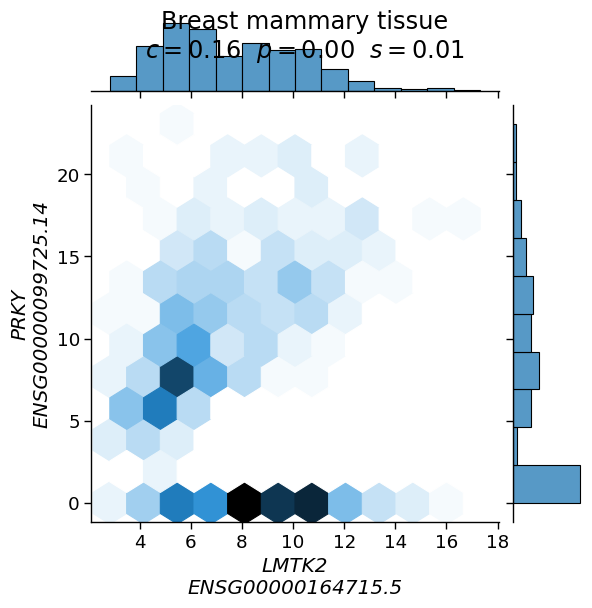

In [175]:
for index, gp_i in gp.iloc[0:50].iterrows():
    gp_i_tissue = gp_i["tissue"]
    gene0_id, gene1_id = gp_i["gene1"], gp_i["gene2"]
    display(gp_i)

    _tissue_data, p = plot_gene_pair(
        gp_i_tissue,
        gene0_id,
        gene1_id,
        # hue="DTHRFGD",
        # hue_is_categorical=True,
        # hue_include_categories=[0.0, 97.0],
        # kind="scatter",
    )

    plt.show(p.fig)
    plt.close(p.fig)
    # display(p)

# **Gene pair 2**: Breast mammary tissue, RAD18 - UTY

In [182]:
gene0_id, gene1_id = "ENSG00000070950.9", "ENSG00000183878.15"
tissue = "breast_mammary_tissue"

In [183]:
_tissue_data, _p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    plot=False,
    hue="SEX", # force getting metadata
)

'Tissue data: (459, 2)'

'Tissue data with metadata: (459, 264)'

('RAD18', 'UTY')

In [184]:
_tissue_data["SEX"].value_counts()

SEX
Male      291
Female    168
Name: count, dtype: int64

'Tissue data: (459, 2)'

'Tissue data with metadata: (459, 264)'

('RAD18', 'UTY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-RAD18_vs_UTY.svg')

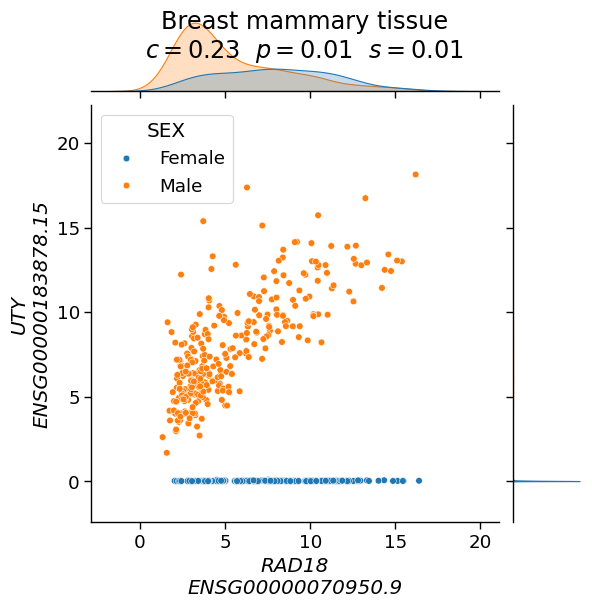

In [185]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue="SEX",
    hue_is_categorical=True,
    # hue_include_categories=["Organ Donor (OPO)", "Postmortem"],
    kind="scatter",
)

'Tissue data: (459, 2)'

'Tissue data with metadata: (459, 264)'

('RAD18', 'UTY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_breast_mammary_tissue-RAD18_vs_UTY.svg')

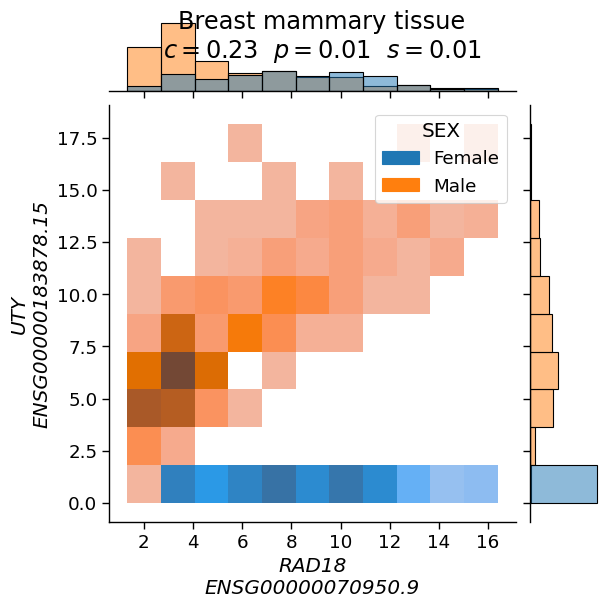

In [186]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue="SEX",
    hue_is_categorical=True,
    # hue_include_categories=["Organ Donor (OPO)", "Postmortem"],
    kind="hist",
)

## Top

In [288]:
# look for specific metadata variables
gp = gene_pairs[
    # (~gene_pairs["common_metadata"].str.contains("SMRRNART|SMALTALG"))
    (~gene_pairs["tissue"].isin(low_sample_size_tissues + ("whole_blood", "breast_mammary_tissue")))
].drop(columns=[
    f"{c} ({hl})" for c in ("Clustermatch", "Pearson", "Spearman") for hl in ("high", "low")
]).sort_values("ccc", ascending=False)
display(gp)

tissue               gene1               gene2  \
2100  cells_cultured_fibroblasts   ENSG00000169188.4  ENSG00000167325.14   
2101  cells_cultured_fibroblasts   ENSG00000169188.4  ENSG00000149636.15   
2102  cells_cultured_fibroblasts   ENSG00000169188.4   ENSG00000100206.9   
2103  cells_cultured_fibroblasts  ENSG00000102974.14  ENSG00000147536.11   
2104  cells_cultured_fibroblasts   ENSG00000169188.4  ENSG00000198176.12   
...                          ...                 ...                 ...   
4558  skin_sun_exposed_lower_leg   ENSG00000243314.1   ENSG00000252581.1   
4586  skin_sun_exposed_lower_leg   ENSG00000277301.1   ENSG00000228040.1   
4577  skin_sun_exposed_lower_leg   ENSG00000218472.2   ENSG00000263970.1   
4564  skin_sun_exposed_lower_leg   ENSG00000248771.5   ENSG00000251168.1   
4599  skin_sun_exposed_lower_leg   ENSG00000232519.2   ENSG00000255928.1   

      Gene 1 Symbol  Gene 2 Symbol       ccc   pearson  spearman  \
2100          APEX2           RRM1  0.388672  0.009811  0.018188   
2101          APEX2           DSN1  0.378418  0.006233  0.002731   
2102          APEX2           DMC1  0.328369  0.002590  0.003607   
2103           CTCF          GINS4  0.323975  0.007496  0.002243   
2104          APEX2          TFDP1  0.319336  0.008453  0.013519   
...             ...            ...       ...       ...       ...   
4558  RP11-538P18.1     RNU6-1098P  0.042206  0.001311  0.000267   
4586   RP5-1184F4.7    RP3-522D1.2  0.042175  0.001608  0.002754   
4577    RP1-140K8.2  RP11-789C17.5  0.042023  0.001617  0.001645   
4564      LINC01207  CTD-2072I24.1  0.041809  0.000420  0.000814   
4599   RP11-29H23.4  RP11-456I15.2  0.041016  0.001261  0.001761   

      ccc_pearson_diff  ccc_spearman_diff  ...  gene2_top3_metadata  \
2100          0.378860           0.370483  ...             SMEXNCRT   
2101          0.372185           0.375687  ...             SMEXNCRT   
2102          0.325779           0.324762  ...             SMEXNCRT   
2103          0.316479           0.321732  ...             SMEXPEFF   
2104          0.310883           0.305817  ...            DTHLUCODD   
...                ...                ...  ...                  ...   
4558          0.040895           0.041939  ...             TRCCLMPD   
4586          0.040567           0.039421  ...             MHABNWBC   
4577          0.040405           0.040378  ...             MHHRTDIS   
4564          0.041389           0.040995  ...             SMEXPEFF   
4599          0.039755           0.039254  ...             SME2SNSE   

      gene2_top3_ccc  gene2_top3_pvalue gene2_top4_metadata  gene2_top4_ccc  \
2100        0.162167           0.000100            SMEXPEFF        0.162167   
2101        0.141984           0.000100            SMEXPEFF        0.141877   
2102        0.155792           0.000100            SMSPLTRD        0.150684   
2103        0.155792           0.000100            SMEXNCRT        0.149544   
2104        0.168667           0.000100            SMEXPEFF        0.162167   
...              ...                ...                 ...             ...   
4558        0.043209           0.000900            MHHRTATT        0.039116   
4586        0.033835           0.003200            LBEBVMAB        0.030592   
4577        0.055949           0.005899            LBEBVGAB        0.052659   
4564        0.007136           0.003000            SMNTERRT        0.006435   
4599        0.044014           0.000100            SME1SNSE        0.043590   

      gene2_top4_pvalue gene2_top5_metadata  gene2_top5_ccc  \
2100           0.000100            SMSPLTRD        0.154410   
2101           0.000100            SMSPLTRD        0.136221   
2102           0.000100            SMEXPEFF        0.149544   
2103           0.000100            SMSPLTRD        0.142158   
2104           0.000100            SMSPLTRD        0.142158   
...                 ...                 ...             ...   
4558           0.022598            SME1ANTI        0.

tissue                                                        spleen
gene1                                              ENSG00000253862.1
gene2                                              ENSG00000211862.1
Gene 1 Symbol                                           IGHVIII-47-1
Gene 2 Symbol                                                 TRAJ27
ccc                                                         0.076721
pearson                                                     0.010307
spearman                                                    0.003426
ccc_pearson_diff                                            0.066414
ccc_spearman_diff                                           0.073296
ccc_combined_distance                                       0.139709
ccc_mean_distance                                           0.069855
ccc_max_distance                                            0.073296
gene1_top1_metadata                                             RACE
gene1_top1_ccc                    

'Tissue data: (241, 2)'

('IGHVIII-47-1', 'TRAJ27')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_spleen-IGHVIII-47-1_vs_TRAJ27.svg')

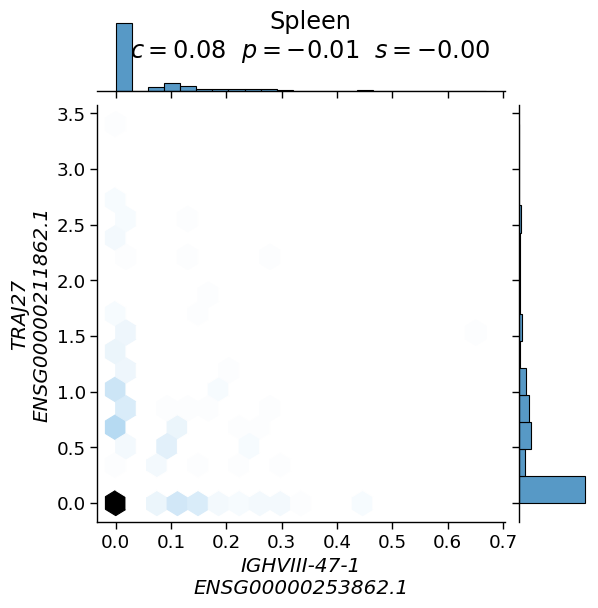

tissue                           esophagus_gastroesophageal_junction
gene1                                              ENSG00000251664.3
gene2                                              ENSG00000154620.5
Gene 1 Symbol                                                PCDHA12
Gene 2 Symbol                                                 TMSB4Y
ccc                                                         0.076721
pearson                                                     0.014938
spearman                                                    0.006874
ccc_pearson_diff                                            0.061783
ccc_spearman_diff                                           0.069847
ccc_combined_distance                                        0.13163
ccc_mean_distance                                           0.065815
ccc_max_distance                                            0.069847
gene1_top1_metadata                                            SMRIN
gene1_top1_ccc                    

'Tissue data: (375, 2)'

('PCDHA12', 'TMSB4Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-PCDHA12_vs_TMSB4Y.svg')

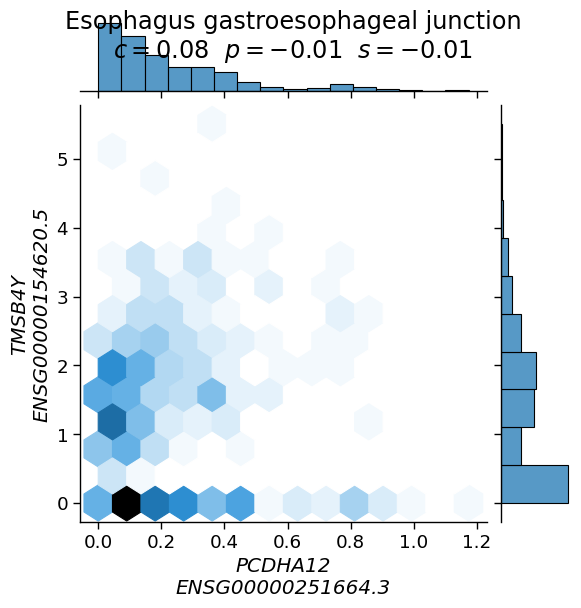

tissue                                             artery_coronary
gene1                                            ENSG00000251235.3
gene2                                            ENSG00000256542.2
Gene 1 Symbol                                              SNRPCP2
Gene 2 Symbol                                         RP13-895J2.3
ccc                                                       0.076721
pearson                                                   0.001419
spearman                                                  0.012367
ccc_pearson_diff                                          0.075302
ccc_spearman_diff                                         0.064354
ccc_combined_distance                                     0.139656
ccc_mean_distance                                         0.069828
ccc_max_distance                                          0.075302
gene1_top1_metadata                                       MHSTRDLT
gene1_top1_ccc                                            0.06

'Tissue data: (240, 2)'

('SNRPCP2', 'RP13-895J2.3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_artery_coronary-SNRPCP2_vs_RP13-895J2.3.svg')

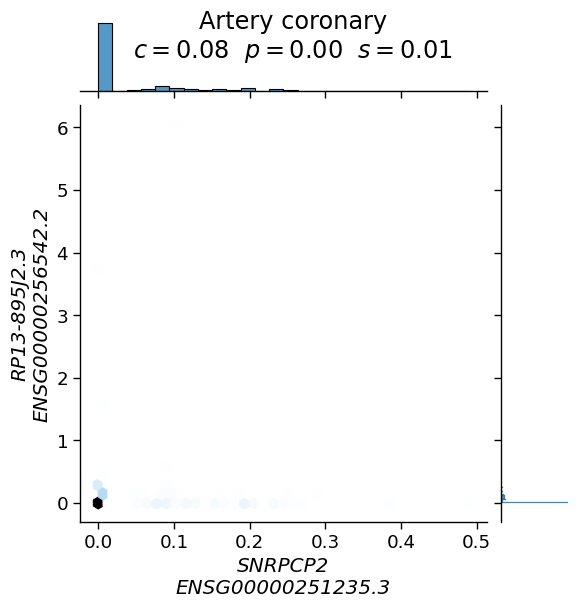

tissue                                                       pancreas
gene1                                               ENSG00000280474.1
gene2                                               ENSG00000271952.1
Gene 1 Symbol                                            RP11-216B9.8
Gene 2 Symbol                                               LINC01954
ccc                                                          0.076721
pearson                                                      0.003975
spearman                                                     0.023682
ccc_pearson_diff                                             0.072746
ccc_spearman_diff                                             0.05304
ccc_combined_distance                                        0.125786
ccc_mean_distance                                            0.062893
ccc_max_distance                                             0.072746
gene1_top1_metadata                                              RACE
gene1_top1_ccc      

'Tissue data: (328, 2)'

('RP11-216B9.8', 'LINC01954')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pancreas-RP11-216B9.8_vs_LINC01954.svg')

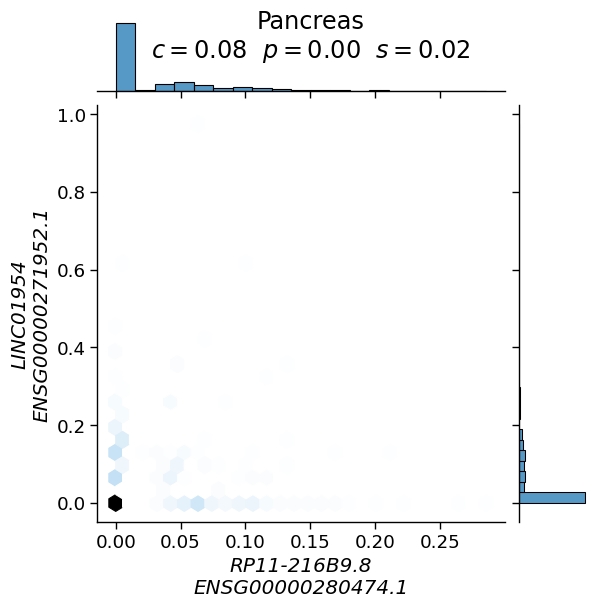

tissue                   skin_not_sun_exposed_suprapubic
gene1                                 ENSG00000112290.12
gene2                                 ENSG00000067646.11
Gene 1 Symbol                                      WASF1
Gene 2 Symbol                                        ZFY
ccc                                              0.07666
pearson                                         0.016144
spearman                                        0.000822
ccc_pearson_diff                                0.060516
ccc_spearman_diff                               0.075839
ccc_combined_distance                           0.136355
ccc_mean_distance                               0.068177
ccc_max_distance                                0.075839
gene1_top1_metadata                              DTHHRDY
gene1_top1_ccc                                  0.042227
gene1_top1_pvalue                                 0.0001
gene1_top2_metadata                                  SEX
gene1_top2_ccc                 

'Tissue data: (604, 2)'

('WASF1', 'ZFY')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_skin_not_sun_exposed_suprapubic-WASF1_vs_ZFY.svg')

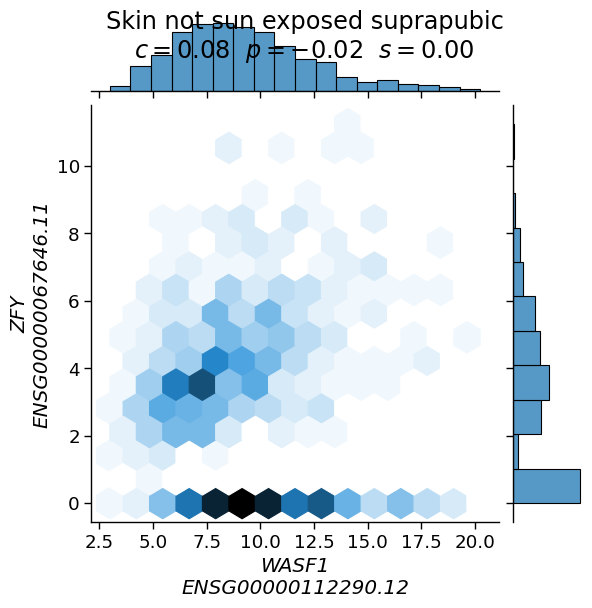

tissue                                                       testis
gene1                                             ENSG00000248444.1
gene2                                             ENSG00000232590.1
Gene 1 Symbol                                            HNRNPA1P65
Gene 2 Symbol                                          RP11-128I7.1
ccc                                                         0.07666
pearson                                                    0.003736
spearman                                                   0.029449
ccc_pearson_diff                                           0.072924
ccc_spearman_diff                                          0.047211
ccc_combined_distance                                      0.120134
ccc_mean_distance                                          0.060067
ccc_max_distance                                           0.072924
gene1_top1_metadata                                        MHRNLFLR
gene1_top1_ccc                                  

'Tissue data: (361, 2)'

('HNRNPA1P65', 'RP11-128I7.1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_testis-HNRNPA1P65_vs_RP11-128I7.1.svg')

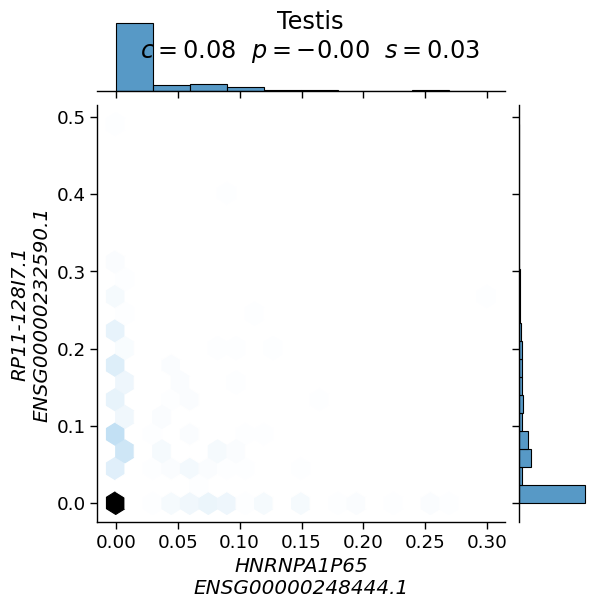

tissue                                                      testis
gene1                                            ENSG00000200095.1
gene2                                            ENSG00000200842.1
Gene 1 Symbol                                            RNU6-181P
Gene 2 Symbol                                                Y_RNA
ccc                                                        0.07666
pearson                                                   0.001965
spearman                                                  0.030807
ccc_pearson_diff                                          0.074696
ccc_spearman_diff                                         0.045853
ccc_combined_distance                                     0.120548
ccc_mean_distance                                         0.060274
ccc_max_distance                                          0.074696
gene1_top1_metadata                                        LBHBSAB
gene1_top1_ccc                                            0.07

'Tissue data: (361, 2)'

('RNU6-181P', 'Y_RNA')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_testis-RNU6-181P_vs_Y_RNA.svg')

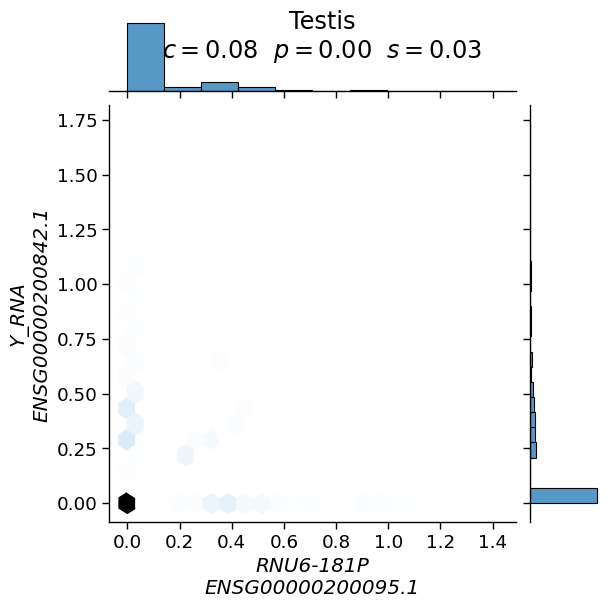

tissue                                 brain_caudate_basal_ganglia
gene1                                           ENSG00000150275.17
gene2                                            ENSG00000197756.9
Gene 1 Symbol                                               PCDH15
Gene 2 Symbol                                               RPL37A
ccc                                                        0.07666
pearson                                                   0.008789
spearman                                                  0.014328
ccc_pearson_diff                                          0.067871
ccc_spearman_diff                                         0.062332
ccc_combined_distance                                     0.130203
ccc_mean_distance                                         0.065102
ccc_max_distance                                          0.067871
gene1_top1_metadata                                          SMRIN
gene1_top1_ccc                                            0.10

'Tissue data: (246, 2)'

('PCDH15', 'RPL37A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-PCDH15_vs_RPL37A.svg')

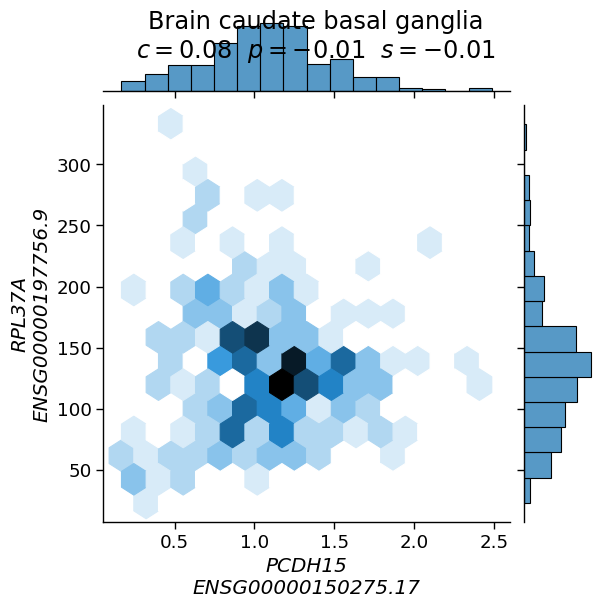

tissue                                                      testis
gene1                                            ENSG00000229985.2
gene2                                            ENSG00000255431.1
Gene 1 Symbol                                         RP11-40H20.5
Gene 2 Symbol                                              OR5B19P
ccc                                                        0.07666
pearson                                                   0.012344
spearman                                                  0.003326
ccc_pearson_diff                                          0.064316
ccc_spearman_diff                                         0.073334
ccc_combined_distance                                      0.13765
ccc_mean_distance                                         0.068825
ccc_max_distance                                          0.073334
gene1_top1_metadata                                     MHCANCERNM
gene1_top1_ccc                                            0.05

'Tissue data: (361, 2)'

('RP11-40H20.5', 'OR5B19P')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_testis-RP11-40H20.5_vs_OR5B19P.svg')

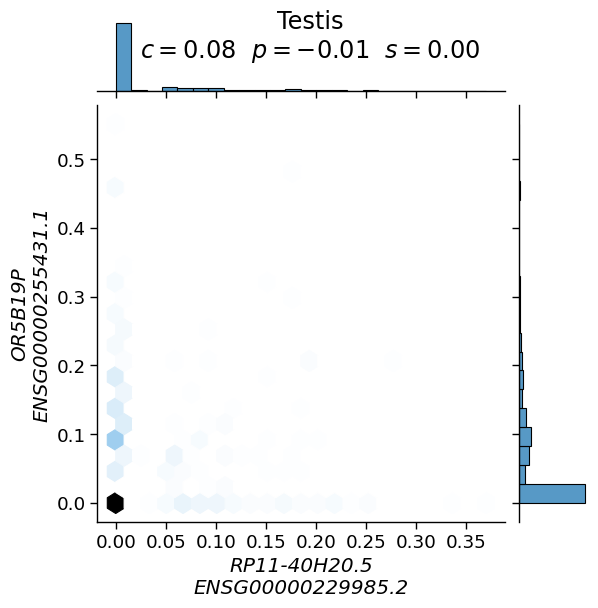

tissue                              spleen
gene1                    ENSG00000227852.1
gene2                    ENSG00000200135.1
Gene 1 Symbol                     RPS29P17
Gene 2 Symbol                        Y_RNA
ccc                               0.076599
pearson                           0.008461
spearman                          0.005356
ccc_pearson_diff                  0.068138
ccc_spearman_diff                 0.071243
ccc_combined_distance             0.139381
ccc_mean_distance                 0.069691
ccc_max_distance                  0.071243
gene1_top1_metadata               SMSFLGTH
gene1_top1_ccc                    0.056103
gene1_top1_pvalue                   0.0003
gene1_top2_metadata              DTHPRNINT
gene1_top2_ccc                    0.050123
gene1_top2_pvalue                   0.0001
gene1_top3_metadata               SMMFLGTH
gene1_top3_ccc                    0.045754
gene1_top3_pvalue                   0.0006
gene1_top4_metadata               SMRRNANM
gene1_top4_

'Tissue data: (241, 2)'

('RPS29P17', 'Y_RNA')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_spleen-RPS29P17_vs_Y_RNA.svg')

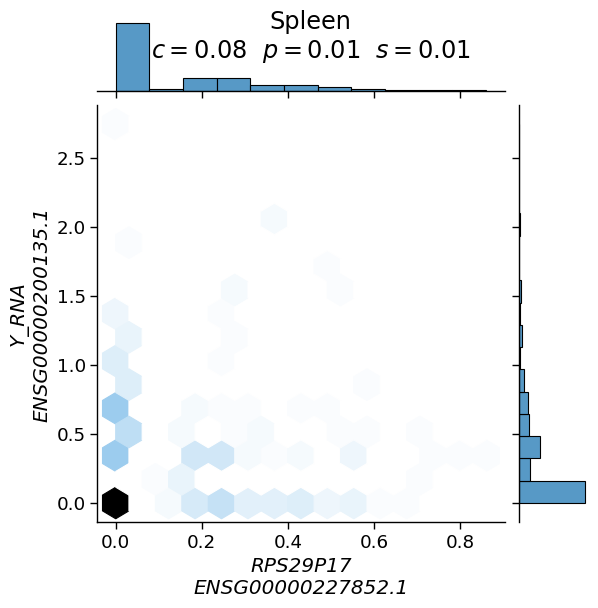

tissue                                     brain_frontal_cortex_ba9
gene1                                            ENSG00000118418.14
gene2                                            ENSG00000145708.10
Gene 1 Symbol                                                 HMGN3
Gene 2 Symbol                                                 CRHBP
ccc                                                        0.076599
pearson                                                    0.005615
spearman                                                   0.002092
ccc_pearson_diff                                           0.070984
ccc_spearman_diff                                          0.074507
ccc_combined_distance                                      0.145491
ccc_mean_distance                                          0.072745
ccc_max_distance                                           0.074507
gene1_top1_metadata                                        SMEXNCRT
gene1_top1_ccc                                  

'Tissue data: (209, 2)'

('HMGN3', 'CRHBP')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_frontal_cortex_ba9-HMGN3_vs_CRHBP.svg')

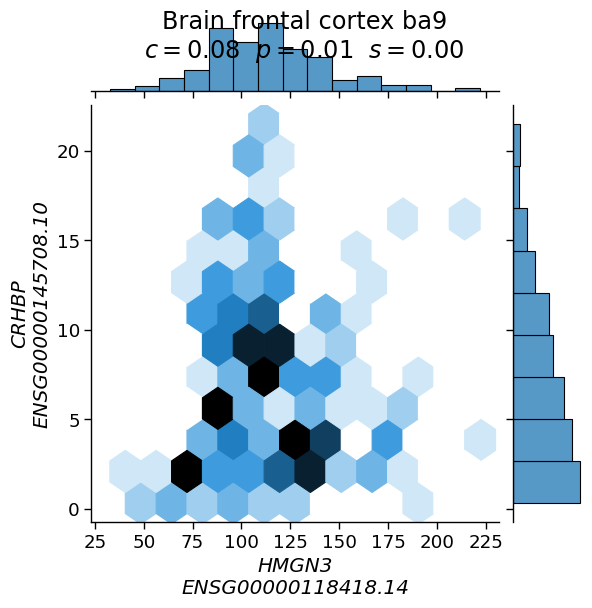

tissue                        brain_cortex
gene1                    ENSG00000267735.1
gene2                    ENSG00000283766.1
Gene 1 Symbol                CTD-2265O21.7
Gene 2 Symbol                   AC141930.3
ccc                               0.076538
pearson                           0.010681
spearman                           0.00072
ccc_pearson_diff                  0.065857
ccc_spearman_diff                 0.075818
ccc_combined_distance             0.141675
ccc_mean_distance                 0.070837
ccc_max_distance                  0.075818
gene1_top1_metadata              DTHPRNINT
gene1_top1_ccc                    0.151076
gene1_top1_pvalue                   0.0029
gene1_top2_metadata               MHORGNTP
gene1_top2_ccc                    0.114535
gene1_top2_pvalue                 0.026297
gene1_top3_metadata               MHHRTDIS
gene1_top3_ccc                    0.093046
gene1_top3_pvalue                 0.008199
gene1_top4_metadata               MHUK8096
gene1_top4_

'Tissue data: (255, 2)'

('CTD-2265O21.7', 'AC141930.3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_cortex-CTD-2265O21.7_vs_AC141930.3.svg')

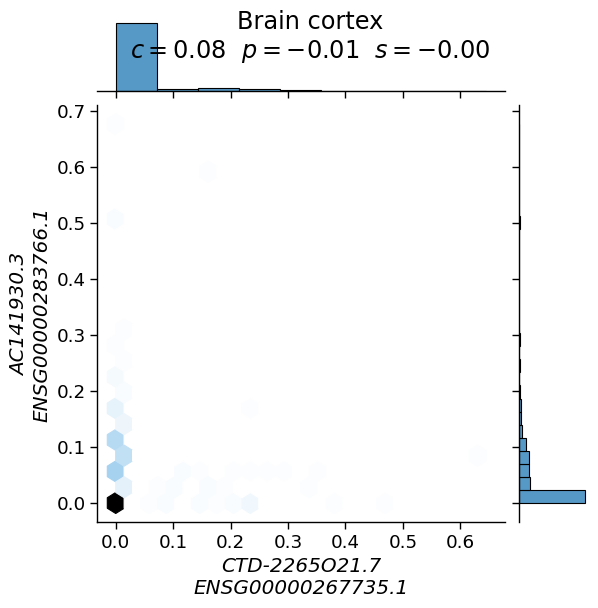

tissue                        esophagus_gastroesophageal_junction
gene1                                          ENSG00000152642.10
gene2                                          ENSG00000165246.13
Gene 1 Symbol                                               GPD1L
Gene 2 Symbol                                              NLGN4Y
ccc                                                      0.076538
pearson                                                  0.020309
spearman                                                 0.005733
ccc_pearson_diff                                         0.056229
ccc_spearman_diff                                        0.070805
ccc_combined_distance                                    0.127033
ccc_mean_distance                                        0.063517
ccc_max_distance                                         0.070805
gene1_top1_metadata                                      LBEBVGAB
gene1_top1_ccc                                           0.330205
gene1_top1

'Tissue data: (375, 2)'

('GPD1L', 'NLGN4Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-GPD1L_vs_NLGN4Y.svg')

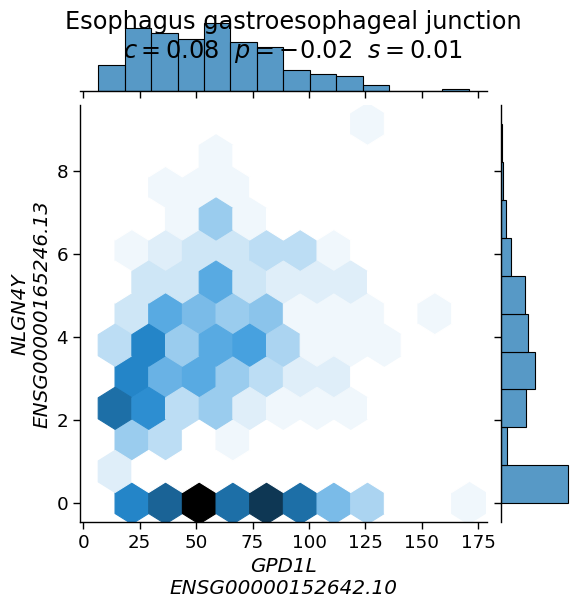

tissue                                          esophagus_mucosa
gene1                                         ENSG00000099341.11
gene2                                          ENSG00000099624.7
Gene 1 Symbol                                              PSMD8
Gene 2 Symbol                                              ATP5D
ccc                                                     0.076538
pearson                                                 0.013382
spearman                                                 0.00824
ccc_pearson_diff                                        0.063156
ccc_spearman_diff                                       0.068298
ccc_combined_distance                                   0.131454
ccc_mean_distance                                       0.065727
ccc_max_distance                                        0.068298
gene1_top1_metadata                                     SMRRNART
gene1_top1_ccc                                           0.18397
gene1_top1_pvalue        

'Tissue data: (555, 2)'

('PSMD8', 'ATP5D')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_mucosa-PSMD8_vs_ATP5D.svg')

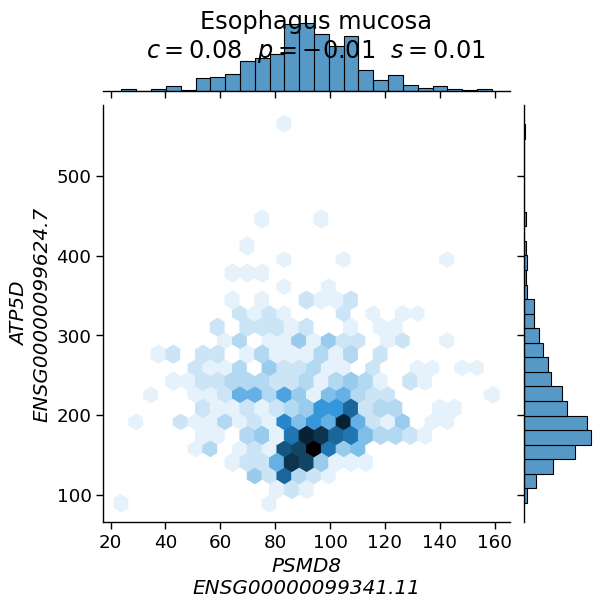

tissue                   brain_caudate_basal_ganglia
gene1                              ENSG00000279011.1
gene2                              ENSG00000259907.1
Gene 1 Symbol                           RP11-191F9.4
Gene 2 Symbol                             RP6-91H8.2
ccc                                         0.076538
pearson                                     0.010124
spearman                                     0.01503
ccc_pearson_diff                            0.066414
ccc_spearman_diff                           0.061508
ccc_combined_distance                       0.127922
ccc_mean_distance                           0.063961
ccc_max_distance                            0.066414
gene1_top1_metadata                         MHSTRDLT
gene1_top1_ccc                               0.10087
gene1_top1_pvalue                           0.011699
gene1_top2_metadata                         MHBLDDND
gene1_top2_ccc                              0.079451
gene1_top2_pvalue                           0.

'Tissue data: (246, 2)'

('RP11-191F9.4', 'RP6-91H8.2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-RP11-191F9.4_vs_RP6-91H8.2.svg')

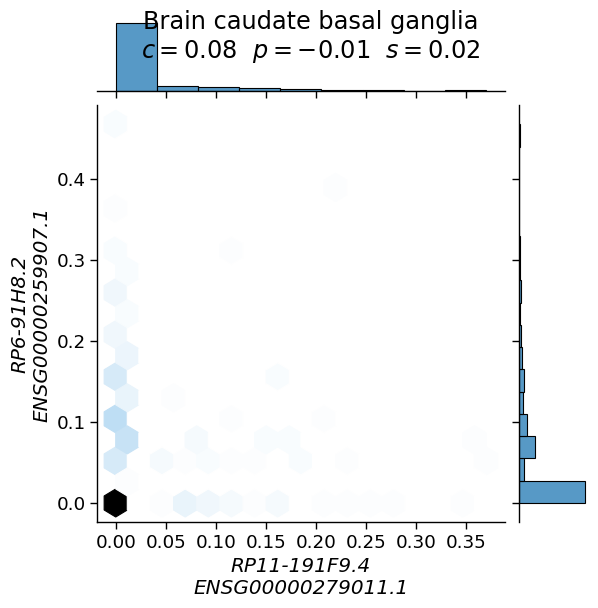

tissue                                           brain_hippocampus
gene1                                            ENSG00000253190.3
gene2                                            ENSG00000257677.1
Gene 1 Symbol                                           AC084082.3
Gene 2 Symbol                                          RP1-81P11.1
ccc                                                       0.076538
pearson                                                   0.002003
spearman                                                  0.001113
ccc_pearson_diff                                          0.074535
ccc_spearman_diff                                         0.075425
ccc_combined_distance                                     0.149961
ccc_mean_distance                                          0.07498
ccc_max_distance                                          0.075425
gene1_top1_metadata                                       MHBLDDND
gene1_top1_ccc                                            0.09

'Tissue data: (197, 2)'

('AC084082.3', 'RP1-81P11.1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hippocampus-AC084082.3_vs_RP1-81P11.1.svg')

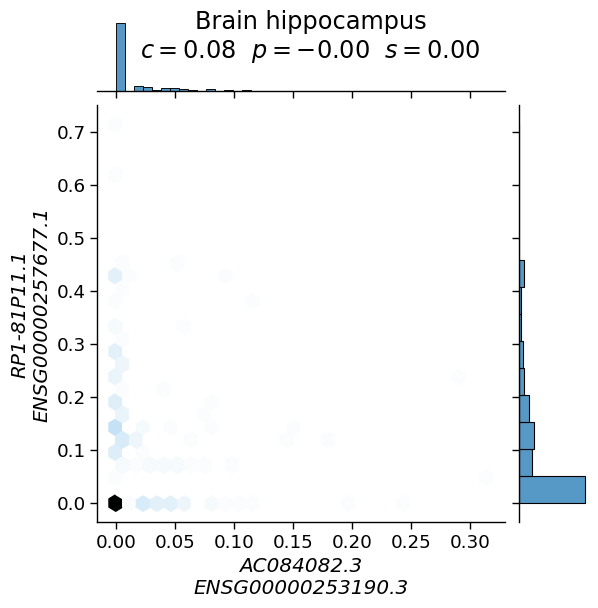

tissue                         esophagus_gastroesophageal_junction
gene1                                            ENSG00000196453.7
gene2                                            ENSG00000198695.2
Gene 1 Symbol                                               ZNF777
Gene 2 Symbol                                               MT-ND6
ccc                                                       0.076477
pearson                                                   0.013817
spearman                                                  0.014259
ccc_pearson_diff                                           0.06266
ccc_spearman_diff                                         0.062218
ccc_combined_distance                                     0.124878
ccc_mean_distance                                         0.062439
ccc_max_distance                                           0.06266
gene1_top1_metadata                                       SMRRNART
gene1_top1_ccc                                            0.14

'Tissue data: (375, 2)'

('ZNF777', 'MT-ND6')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-ZNF777_vs_MT-ND6.svg')

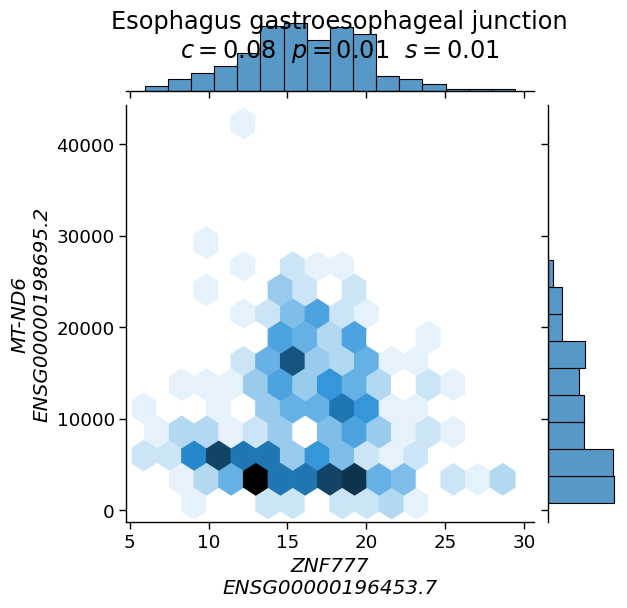

tissue                                                        testis
gene1                                              ENSG00000236874.1
gene2                                              ENSG00000232951.1
Gene 1 Symbol                                            RP1-66N13.1
Gene 2 Symbol                                                 IPO7P1
ccc                                                         0.076477
pearson                                                     0.016769
spearman                                                    0.003162
ccc_pearson_diff                                            0.059708
ccc_spearman_diff                                           0.073315
ccc_combined_distance                                       0.133022
ccc_mean_distance                                           0.066511
ccc_max_distance                                            0.073315
gene1_top1_metadata                                         SMSPLTRD
gene1_top1_ccc                    

'Tissue data: (361, 2)'

('RP1-66N13.1', 'IPO7P1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_testis-RP1-66N13.1_vs_IPO7P1.svg')

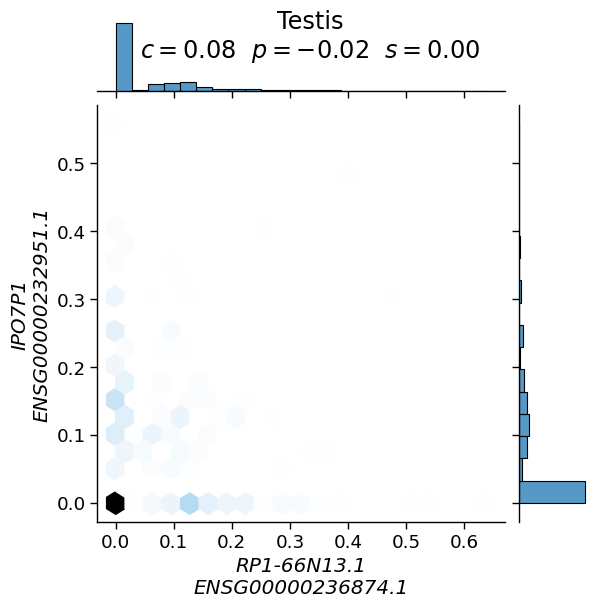

tissue                                       brain_hippocampus
gene1                                        ENSG00000257443.1
gene2                                        ENSG00000273805.1
Gene 1 Symbol                                    RP11-150C16.1
Gene 2 Symbol                                    RP11-620J15.4
ccc                                                   0.076477
pearson                                               0.002996
spearman                                              0.000045
ccc_pearson_diff                                      0.073481
ccc_spearman_diff                                     0.076432
ccc_combined_distance                                 0.149913
ccc_mean_distance                                     0.074956
ccc_max_distance                                      0.076432
gene1_top1_metadata                                  MHDRNKYRS
gene1_top1_ccc                                        0.059051
gene1_top1_pvalue                                     0

'Tissue data: (197, 2)'

('RP11-150C16.1', 'RP11-620J15.4')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hippocampus-RP11-150C16.1_vs_RP11-620J15.4.svg')

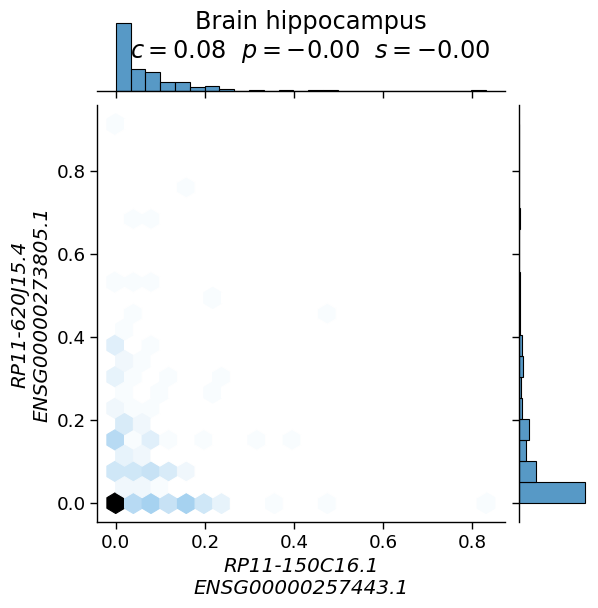

tissue                                                        lung
gene1                                           ENSG00000136936.10
gene2                                            ENSG00000269967.1
Gene 1 Symbol                                                  XPA
Gene 2 Symbol                                         RP11-84A19.4
ccc                                                       0.076416
pearson                                                   0.002502
spearman                                                  0.008499
ccc_pearson_diff                                          0.073914
ccc_spearman_diff                                         0.067917
ccc_combined_distance                                      0.14183
ccc_mean_distance                                         0.070915
ccc_max_distance                                          0.073914
gene1_top1_metadata                                       LBEBVMAB
gene1_top1_ccc                                            0.06

'Tissue data: (578, 2)'

('XPA', 'RP11-84A19.4')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-XPA_vs_RP11-84A19.4.svg')

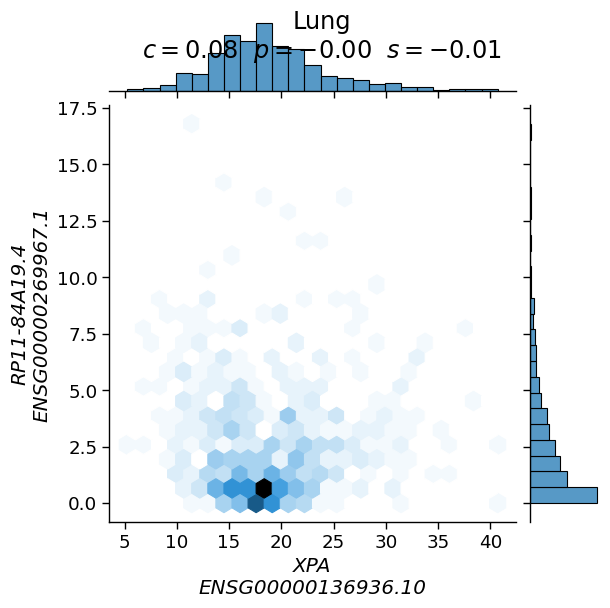

tissue                                           esophagus_mucosa
gene1                                           ENSG00000145425.9
gene2                                           ENSG00000147437.9
Gene 1 Symbol                                               RPS3A
Gene 2 Symbol                                               GNRH1
ccc                                                      0.076416
pearson                                                  0.007805
spearman                                                 0.010086
ccc_pearson_diff                                         0.068611
ccc_spearman_diff                                         0.06633
ccc_combined_distance                                    0.134941
ccc_mean_distance                                        0.067471
ccc_max_distance                                         0.068611
gene1_top1_metadata                                      SMRRNART
gene1_top1_ccc                                            0.12959
gene1_top1

'Tissue data: (555, 2)'

('RPS3A', 'GNRH1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_mucosa-RPS3A_vs_GNRH1.svg')

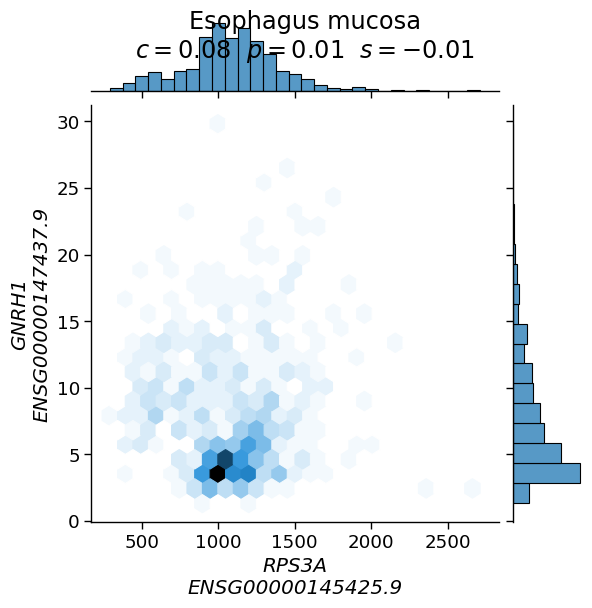

tissue                                     brain_frontal_cortex_ba9
gene1                                             ENSG00000261336.1
gene2                                             ENSG00000262855.1
Gene 1 Symbol                                               EIF4BP5
Gene 2 Symbol                                           RP11-46I8.4
ccc                                                        0.076355
pearson                                                    0.000565
spearman                                                   0.011681
ccc_pearson_diff                                            0.07579
ccc_spearman_diff                                          0.064674
ccc_combined_distance                                      0.140464
ccc_mean_distance                                          0.070232
ccc_max_distance                                            0.07579
gene1_top1_metadata                                        MHLVRDIS
gene1_top1_ccc                                  

'Tissue data: (209, 2)'

('EIF4BP5', 'RP11-46I8.4')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_frontal_cortex_ba9-EIF4BP5_vs_RP11-46I8.4.svg')

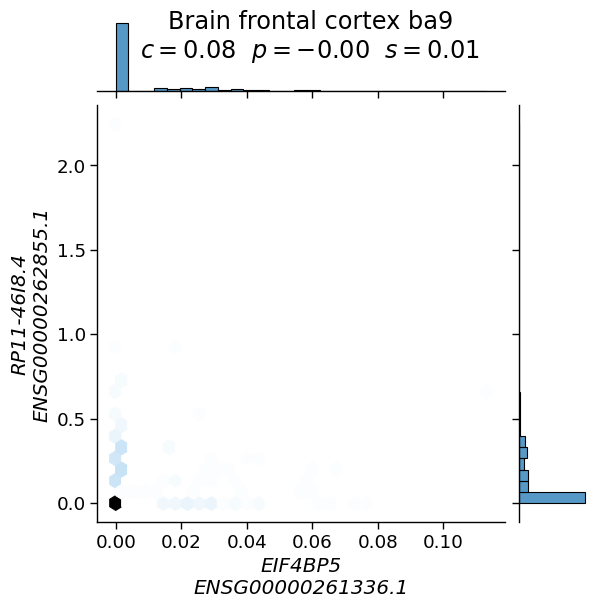

tissue                                         esophagus_mucosa
gene1                                        ENSG00000067955.13
gene2                                        ENSG00000004961.14
Gene 1 Symbol                                              CBFB
Gene 2 Symbol                                              HCCS
ccc                                                    0.076355
pearson                                                0.020157
spearman                                               0.016006
ccc_pearson_diff                                       0.056198
ccc_spearman_diff                                      0.060349
ccc_combined_distance                                  0.116547
ccc_mean_distance                                      0.058273
ccc_max_distance                                       0.060349
gene1_top1_metadata                                   TRCHSTIND
gene1_top1_ccc                                         0.230049
gene1_top1_pvalue                       

'Tissue data: (555, 2)'

('CBFB', 'HCCS')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_mucosa-CBFB_vs_HCCS.svg')

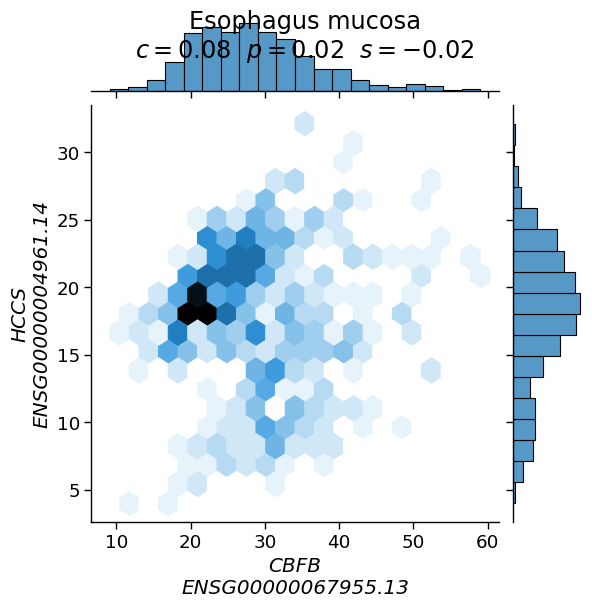

tissue                      esophagus_gastroesophageal_junction
gene1                                        ENSG00000124275.14
gene2                                         ENSG00000198695.2
Gene 1 Symbol                                              MTRR
Gene 2 Symbol                                            MT-ND6
ccc                                                    0.076355
pearson                                                0.010712
spearman                                               0.002279
ccc_pearson_diff                                       0.065643
ccc_spearman_diff                                      0.074076
ccc_combined_distance                                  0.139719
ccc_mean_distance                                       0.06986
ccc_max_distance                                       0.074076
gene1_top1_metadata                                    SMRRNANM
gene1_top1_ccc                                         0.126529
gene1_top1_pvalue                       

'Tissue data: (375, 2)'

('MTRR', 'MT-ND6')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-MTRR_vs_MT-ND6.svg')

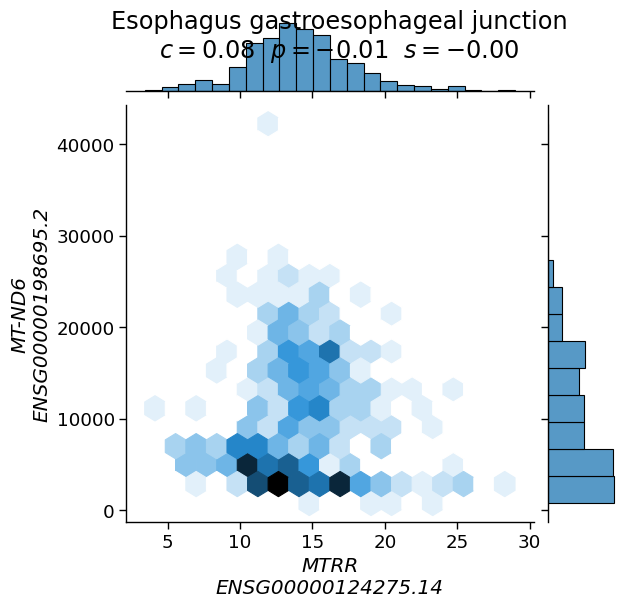

tissue                   brain_caudate_basal_ganglia
gene1                              ENSG00000250572.1
gene2                              ENSG00000209482.1
Gene 1 Symbol                           RP11-529H2.1
Gene 2 Symbol                               SNORD83A
ccc                                         0.076294
pearson                                     0.003092
spearman                                    0.013474
ccc_pearson_diff                            0.073202
ccc_spearman_diff                            0.06282
ccc_combined_distance                       0.136023
ccc_mean_distance                           0.068011
ccc_max_distance                            0.073202
gene1_top1_metadata                           DTHRFG
gene1_top1_ccc                              0.065437
gene1_top1_pvalue                           0.024898
gene1_top2_metadata                            MHCVD
gene1_top2_ccc                              0.048341
gene1_top2_pvalue                           0.

'Tissue data: (246, 2)'

('RP11-529H2.1', 'SNORD83A')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-RP11-529H2.1_vs_SNORD83A.svg')

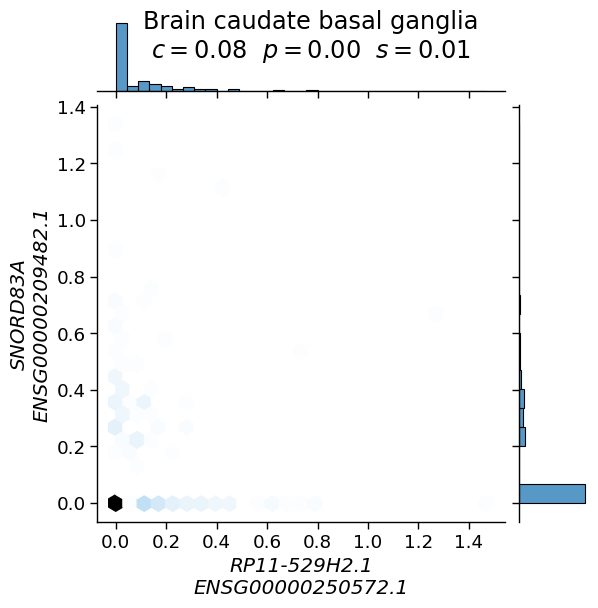

tissue                                                       pancreas
gene1                                               ENSG00000101193.7
gene2                                               ENSG00000204388.6
Gene 1 Symbol                                                    GID8
Gene 2 Symbol                                                  HSPA1B
ccc                                                          0.076294
pearson                                                      0.002651
spearman                                                     0.028503
ccc_pearson_diff                                             0.073643
ccc_spearman_diff                                            0.047791
ccc_combined_distance                                        0.121433
ccc_mean_distance                                            0.060717
ccc_max_distance                                             0.073643
gene1_top1_metadata                                          SMNTRART
gene1_top1_ccc      

'Tissue data: (328, 2)'

('GID8', 'HSPA1B')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pancreas-GID8_vs_HSPA1B.svg')

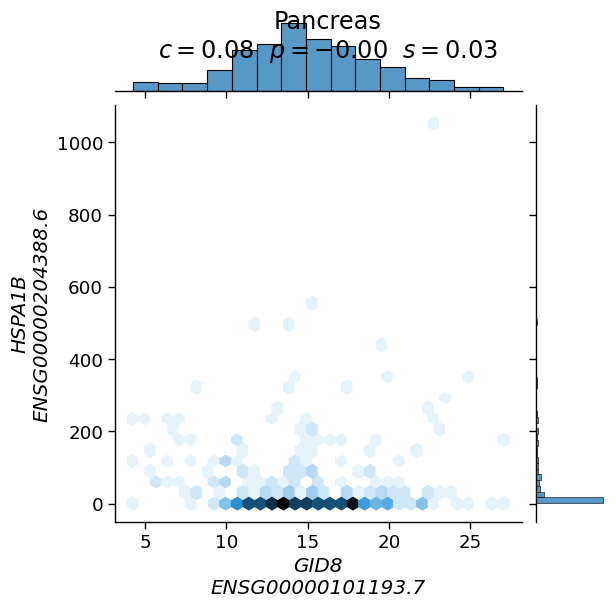

tissue                          esophagus_gastroesophageal_junction
gene1                                             ENSG00000035687.9
gene2                                             ENSG00000198695.2
Gene 1 Symbol                                                  ADSS
Gene 2 Symbol                                                MT-ND6
ccc                                                        0.076294
pearson                                                    0.000792
spearman                                                   0.021088
ccc_pearson_diff                                           0.075502
ccc_spearman_diff                                          0.055206
ccc_combined_distance                                      0.130709
ccc_mean_distance                                          0.065354
ccc_max_distance                                           0.075502
gene1_top1_metadata                                        SMRRNANM
gene1_top1_ccc                                  

'Tissue data: (375, 2)'

('ADSS', 'MT-ND6')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-ADSS_vs_MT-ND6.svg')

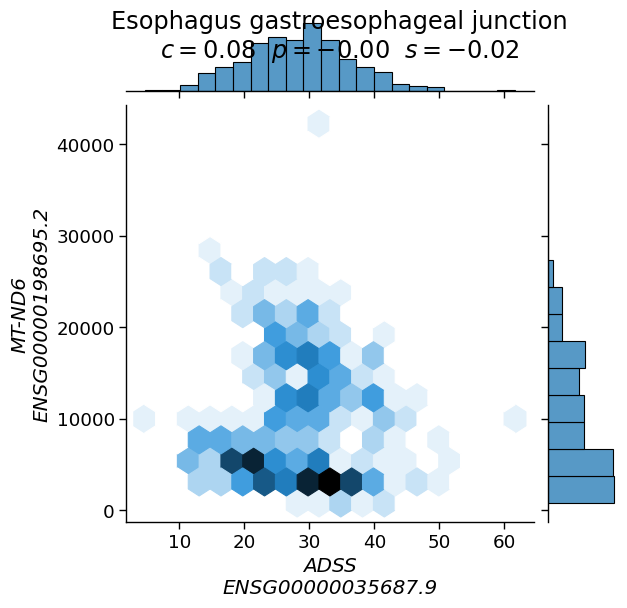

tissue                                                       prostate
gene1                                              ENSG00000156026.14
gene2                                              ENSG00000129993.14
Gene 1 Symbol                                                     MCU
Gene 2 Symbol                                                 CBFA2T3
ccc                                                          0.076294
pearson                                                      0.006424
spearman                                                     0.002928
ccc_pearson_diff                                              0.06987
ccc_spearman_diff                                            0.073366
ccc_combined_distance                                        0.143236
ccc_mean_distance                                            0.071618
ccc_max_distance                                             0.073366
gene1_top1_metadata                                          SMNTRNRT
gene1_top1_ccc      

'Tissue data: (245, 2)'

('MCU', 'CBFA2T3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_prostate-MCU_vs_CBFA2T3.svg')

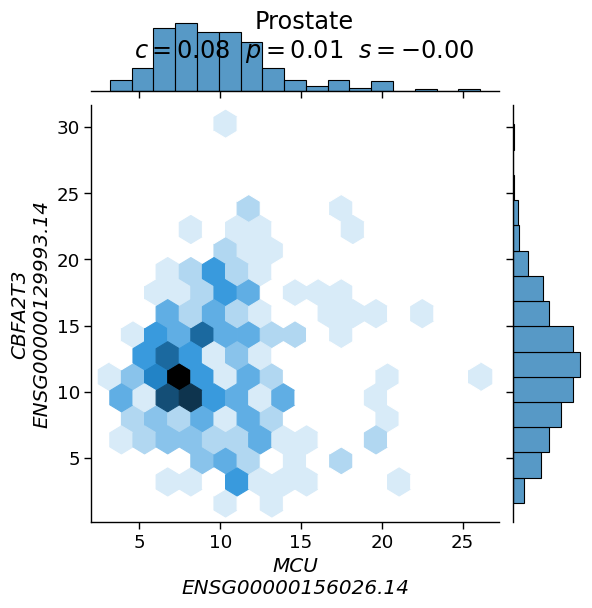

tissue                               esophagus_muscularis
gene1                                   ENSG00000165152.8
gene2                                  ENSG00000165246.13
Gene 1 Symbol                                     TMEM246
Gene 2 Symbol                                      NLGN4Y
ccc                                              0.076294
pearson                                          0.018509
spearman                                         0.004326
ccc_pearson_diff                                 0.057785
ccc_spearman_diff                                0.071968
ccc_combined_distance                            0.129753
ccc_mean_distance                                0.064877
ccc_max_distance                                 0.071968
gene1_top1_metadata                                 SMRIN
gene1_top1_ccc                                   0.105947
gene1_top1_pvalue                                  0.0001
gene1_top2_metadata                             TRCHSTIND
gene1_top2_ccc

'Tissue data: (515, 2)'

('TMEM246', 'NLGN4Y')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_muscularis-TMEM246_vs_NLGN4Y.svg')

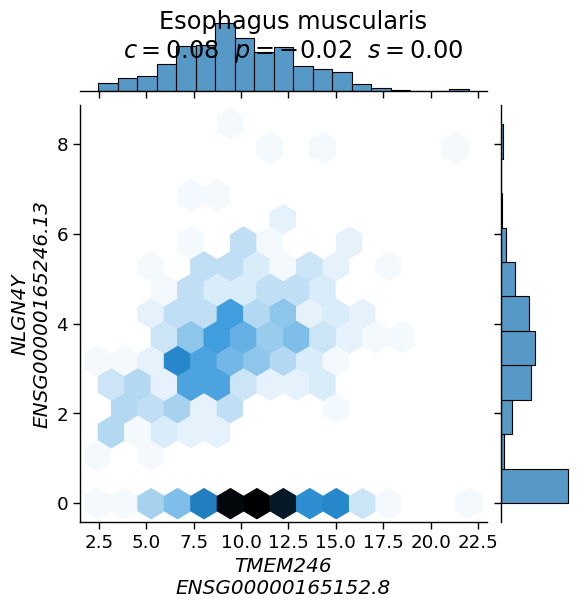

tissue                   brain_caudate_basal_ganglia
gene1                              ENSG00000265843.2
gene2                              ENSG00000236098.1
Gene 1 Symbol                              LINC01029
Gene 2 Symbol                          RP11-148B18.4
ccc                                         0.076233
pearson                                     0.002419
spearman                                    0.001474
ccc_pearson_diff                            0.073814
ccc_spearman_diff                           0.074759
ccc_combined_distance                       0.148573
ccc_mean_distance                           0.074286
ccc_max_distance                            0.074759
gene1_top1_metadata                          DTHPLCE
gene1_top1_ccc                              0.061289
gene1_top1_pvalue                              0.004
gene1_top2_metadata                         MHFNGINF
gene1_top2_ccc                              0.056821
gene1_top2_pvalue                           0.

'Tissue data: (246, 2)'

('LINC01029', 'RP11-148B18.4')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_caudate_basal_ganglia-LINC01029_vs_RP11-148B18.4.svg')

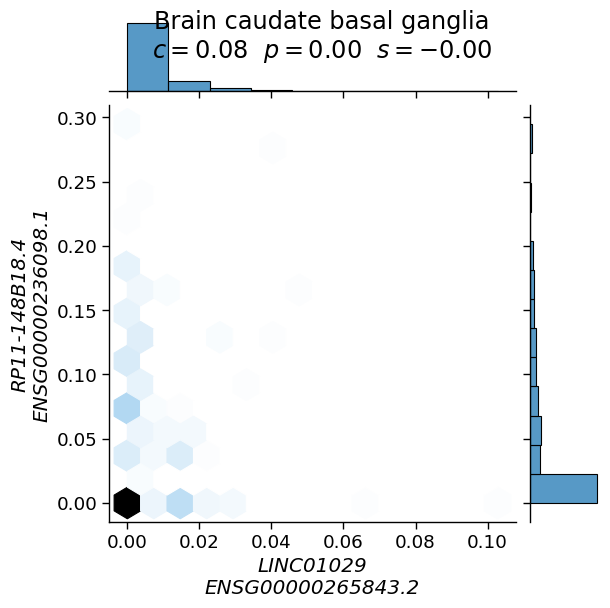

tissue                                               brain_hippocampus
gene1                                                ENSG00000234952.1
gene2                                                ENSG00000199673.1
Gene 1 Symbol                                            RP11-328K15.1
Gene 2 Symbol                                                  SNORD16
ccc                                                           0.076233
pearson                                                       0.001355
spearman                                                      0.010246
ccc_pearson_diff                                              0.074878
ccc_spearman_diff                                             0.065987
ccc_combined_distance                                         0.140864
ccc_mean_distance                                             0.070432
ccc_max_distance                                              0.074878
gene1_top1_metadata                                            LBHIVAB
gene1_

'Tissue data: (197, 2)'

('RP11-328K15.1', 'SNORD16')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hippocampus-RP11-328K15.1_vs_SNORD16.svg')

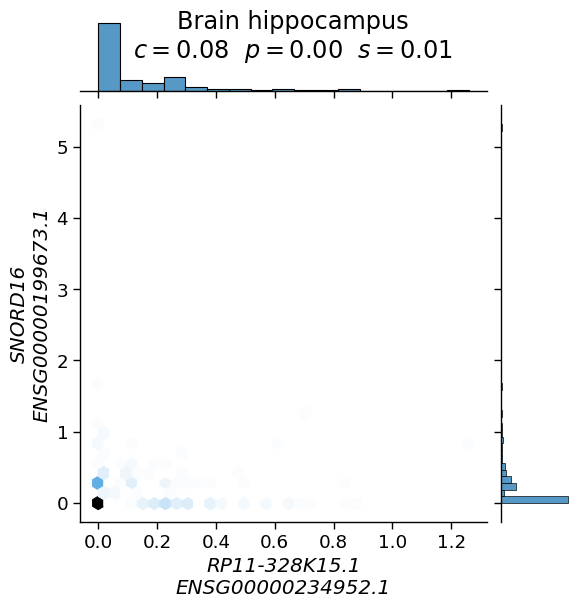

tissue                                                         lung
gene1                                            ENSG00000165516.10
gene2                                            ENSG00000117682.16
Gene 1 Symbol                                                KLHDC2
Gene 2 Symbol                                                 DHDDS
ccc                                                        0.076233
pearson                                                    0.004349
spearman                                                   0.001396
ccc_pearson_diff                                           0.071884
ccc_spearman_diff                                          0.074837
ccc_combined_distance                                      0.146721
ccc_mean_distance                                           0.07336
ccc_max_distance                                           0.074837
gene1_top1_metadata                                        SMNTERRT
gene1_top1_ccc                                  

'Tissue data: (578, 2)'

('KLHDC2', 'DHDDS')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-KLHDC2_vs_DHDDS.svg')

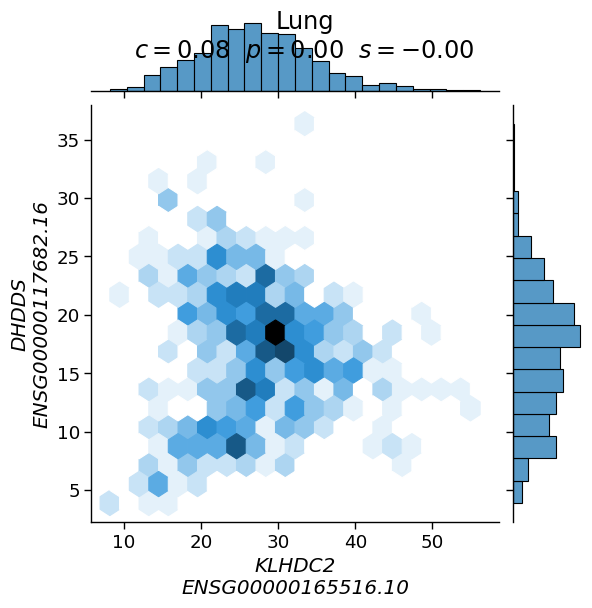

tissue                                                        lung
gene1                                           ENSG00000062598.17
gene2                                           ENSG00000070269.13
Gene 1 Symbol                                                ELMO2
Gene 2 Symbol                                              TMEM260
ccc                                                       0.076233
pearson                                                   0.001565
spearman                                                  0.012482
ccc_pearson_diff                                          0.074668
ccc_spearman_diff                                         0.063751
ccc_combined_distance                                     0.138419
ccc_mean_distance                                          0.06921
ccc_max_distance                                          0.074668
gene1_top1_metadata                                       LBEBVGAB
gene1_top1_ccc                                            0.23

'Tissue data: (578, 2)'

('ELMO2', 'TMEM260')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-ELMO2_vs_TMEM260.svg')

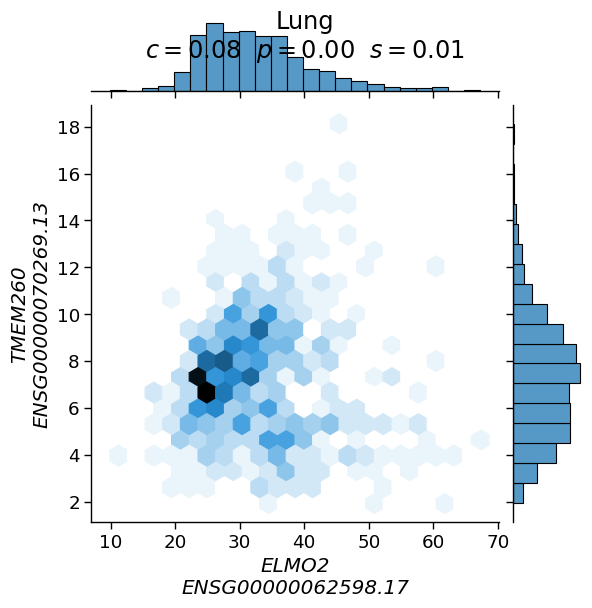

tissue                       brain_nucleus_accumbens_basal_ganglia
gene1                                            ENSG00000267388.1
gene2                                           ENSG00000111832.12
Gene 1 Symbol                                           AF038458.5
Gene 2 Symbol                                                RWDD1
ccc                                                       0.076172
pearson                                                   0.002932
spearman                                                  0.005188
ccc_pearson_diff                                           0.07324
ccc_spearman_diff                                         0.070984
ccc_combined_distance                                     0.144224
ccc_mean_distance                                         0.072112
ccc_max_distance                                           0.07324
gene1_top1_metadata                                       SMEXNCRT
gene1_top1_ccc                                            0.06

'Tissue data: (246, 2)'

('AF038458.5', 'RWDD1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_nucleus_accumbens_basal_ganglia-AF038458.5_vs_RWDD1.svg')

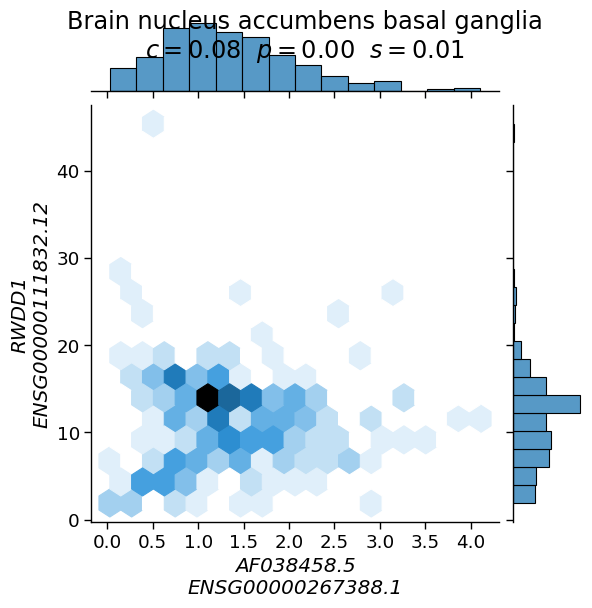

tissue                                                colon_sigmoid
gene1                                            ENSG00000144366.15
gene2                                            ENSG00000118564.14
Gene 1 Symbol                                                 GULP1
Gene 2 Symbol                                                 FBXL5
ccc                                                        0.076172
pearson                                                    0.009148
spearman                                                   0.015869
ccc_pearson_diff                                           0.067024
ccc_spearman_diff                                          0.060303
ccc_combined_distance                                      0.127327
ccc_mean_distance                                          0.063663
ccc_max_distance                                           0.067024
gene1_top1_metadata                                          COHORT
gene1_top1_ccc                                  

'Tissue data: (373, 2)'

('GULP1', 'FBXL5')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_colon_sigmoid-GULP1_vs_FBXL5.svg')

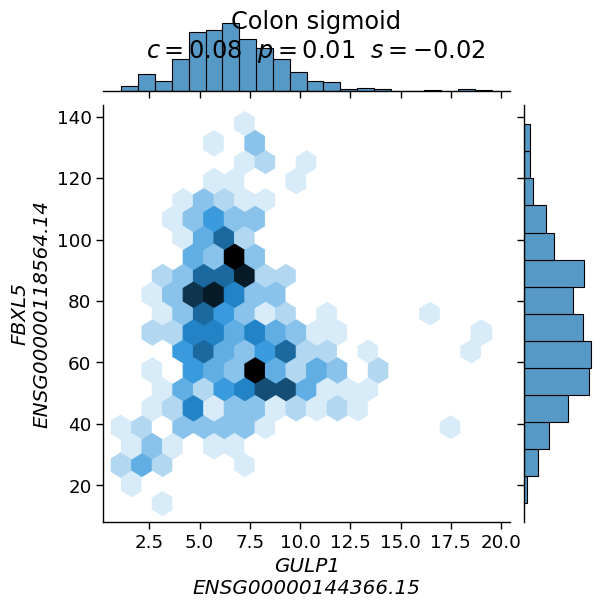

tissue                                            brain_cerebellum
gene1                                           ENSG00000028277.21
gene2                                           ENSG00000163576.17
Gene 1 Symbol                                               POU2F2
Gene 2 Symbol                                                 EFHB
ccc                                                       0.076172
pearson                                                   0.000772
spearman                                                  0.009529
ccc_pearson_diff                                          0.075399
ccc_spearman_diff                                         0.066643
ccc_combined_distance                                     0.142042
ccc_mean_distance                                         0.071021
ccc_max_distance                                          0.075399
gene1_top1_metadata                                       SMRRNART
gene1_top1_ccc                                            0.15

'Tissue data: (241, 2)'

('POU2F2', 'EFHB')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_cerebellum-POU2F2_vs_EFHB.svg')

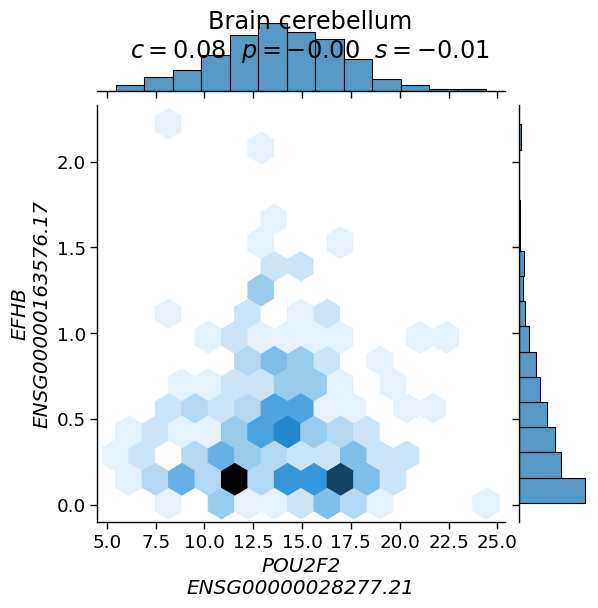

tissue                                            esophagus_mucosa
gene1                                            ENSG00000257704.3
gene2                                            ENSG00000160588.9
Gene 1 Symbol                                               INAFM1
Gene 2 Symbol                                                MPZL3
ccc                                                       0.076172
pearson                                                    0.00745
spearman                                                  0.000785
ccc_pearson_diff                                          0.068722
ccc_spearman_diff                                         0.075387
ccc_combined_distance                                     0.144108
ccc_mean_distance                                         0.072054
ccc_max_distance                                          0.075387
gene1_top1_metadata                                         DTHRFG
gene1_top1_ccc                                            0.46

'Tissue data: (555, 2)'

('INAFM1', 'MPZL3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_mucosa-INAFM1_vs_MPZL3.svg')

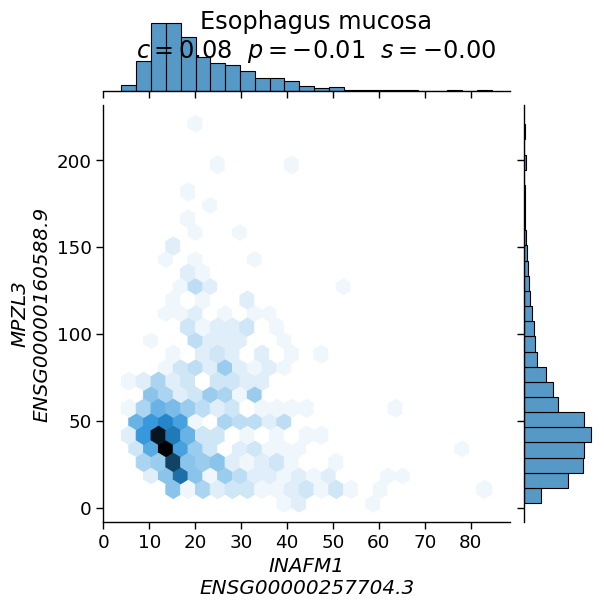

tissue                       brain_nucleus_accumbens_basal_ganglia
gene1                                            ENSG00000227309.1
gene2                                            ENSG00000160472.4
Gene 1 Symbol                                           AC140076.1
Gene 2 Symbol                                              TMEM190
ccc                                                       0.076172
pearson                                                   0.002731
spearman                                                  0.009262
ccc_pearson_diff                                          0.073441
ccc_spearman_diff                                          0.06691
ccc_combined_distance                                      0.14035
ccc_mean_distance                                         0.070175
ccc_max_distance                                          0.073441
gene1_top1_metadata                                       MHWTLSUA
gene1_top1_ccc                                            0.07

'Tissue data: (246, 2)'

('AC140076.1', 'TMEM190')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_nucleus_accumbens_basal_ganglia-AC140076.1_vs_TMEM190.svg')

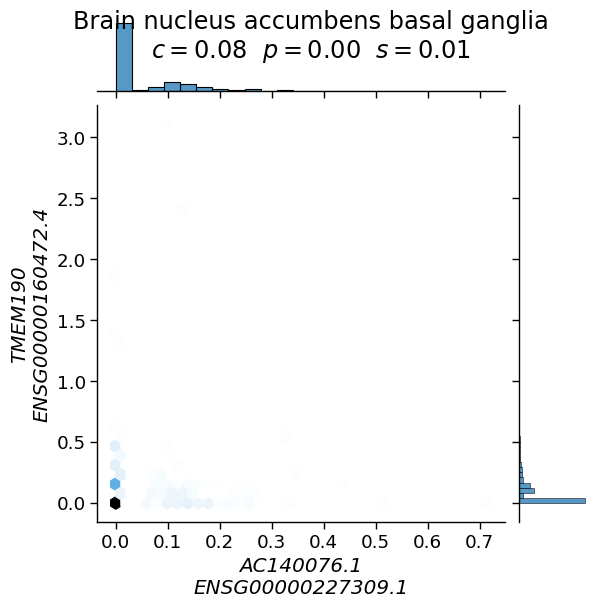

tissue                                                     pituitary
gene1                                             ENSG00000157985.18
gene2                                             ENSG00000151322.18
Gene 1 Symbol                                                  AGAP1
Gene 2 Symbol                                                  NPAS3
ccc                                                         0.076172
pearson                                                     0.003666
spearman                                                    0.002842
ccc_pearson_diff                                            0.072506
ccc_spearman_diff                                            0.07333
ccc_combined_distance                                       0.145836
ccc_mean_distance                                           0.072918
ccc_max_distance                                             0.07333
gene1_top1_metadata                                         SMRRNART
gene1_top1_ccc                    

'Tissue data: (283, 2)'

('AGAP1', 'NPAS3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pituitary-AGAP1_vs_NPAS3.svg')

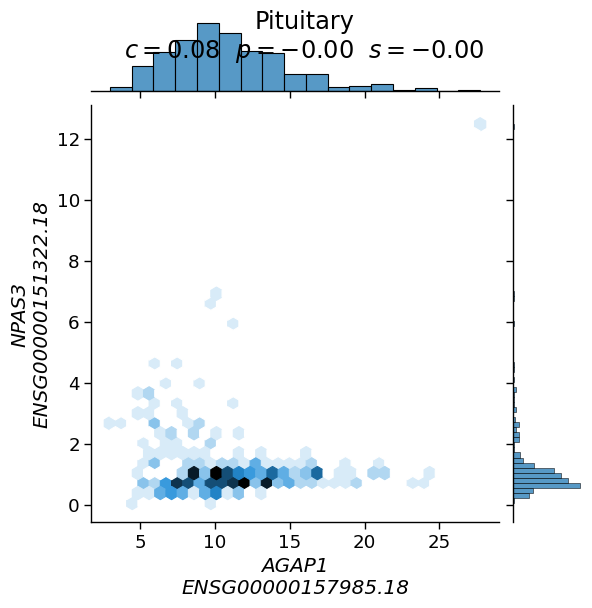

tissue                                          brain_hypothalamus
gene1                                            ENSG00000253805.1
gene2                                           ENSG00000156384.14
Gene 1 Symbol                                        RP11-1049H7.2
Gene 2 Symbol                                                 SFR1
ccc                                                       0.076111
pearson                                                   0.003933
spearman                                                  0.004128
ccc_pearson_diff                                          0.072178
ccc_spearman_diff                                         0.071983
ccc_combined_distance                                     0.144161
ccc_mean_distance                                         0.072081
ccc_max_distance                                          0.072178
gene1_top1_metadata                                       SMRRNART
gene1_top1_ccc                                            0.05

'Tissue data: (202, 2)'

('RP11-1049H7.2', 'SFR1')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_hypothalamus-RP11-1049H7.2_vs_SFR1.svg')

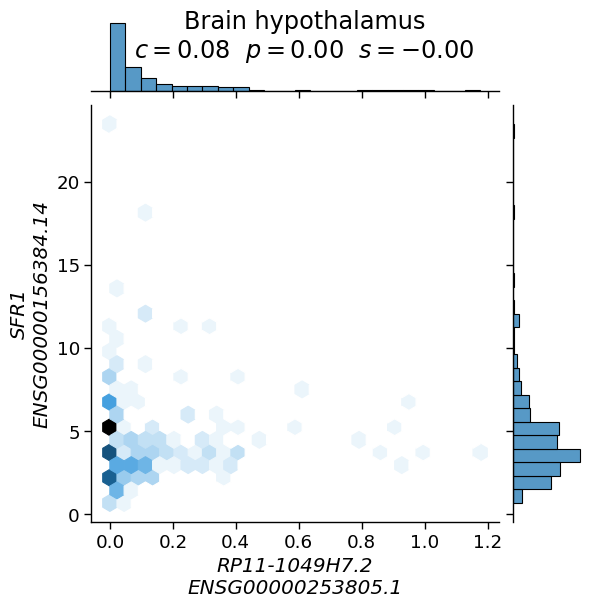

tissue                             esophagus_gastroesophageal_junction
gene1                                               ENSG00000102898.11
gene2                                               ENSG00000100242.15
Gene 1 Symbol                                                    NUTF2
Gene 2 Symbol                                                     SUN2
ccc                                                           0.076111
pearson                                                       0.014626
spearman                                                      0.006748
ccc_pearson_diff                                              0.061485
ccc_spearman_diff                                             0.069363
ccc_combined_distance                                         0.130848
ccc_mean_distance                                             0.065424
ccc_max_distance                                              0.069363
gene1_top1_metadata                                           SMRRNART
gene1_

'Tissue data: (375, 2)'

('NUTF2', 'SUN2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_esophagus_gastroesophageal_junction-NUTF2_vs_SUN2.svg')

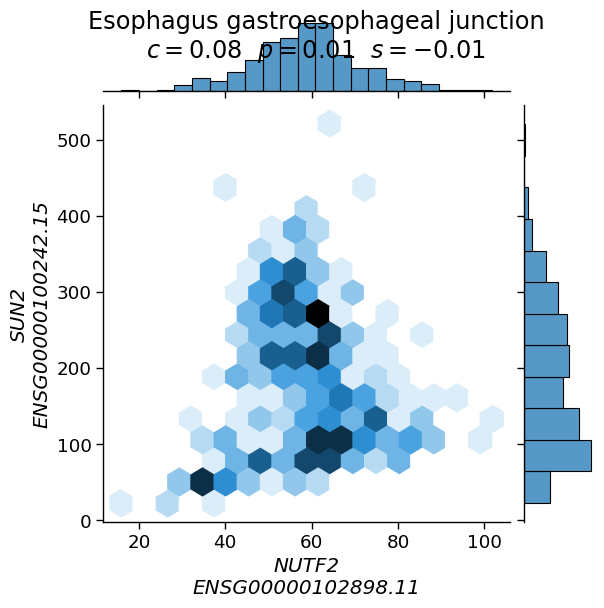

tissue                                                 brain_cortex
gene1                                             ENSG00000218868.1
gene2                                             ENSG00000235126.1
Gene 1 Symbol                                                CNN3P1
Gene 2 Symbol                                            AC128709.3
ccc                                                        0.076111
pearson                                                    0.001912
spearman                                                    0.02446
ccc_pearson_diff                                           0.074199
ccc_spearman_diff                                          0.051651
ccc_combined_distance                                       0.12585
ccc_mean_distance                                          0.062925
ccc_max_distance                                           0.074199
gene1_top1_metadata                                       LBHBHCVAB
gene1_top1_ccc                                  

'Tissue data: (255, 2)'

('CNN3P1', 'AC128709.3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_cortex-CNN3P1_vs_AC128709.3.svg')

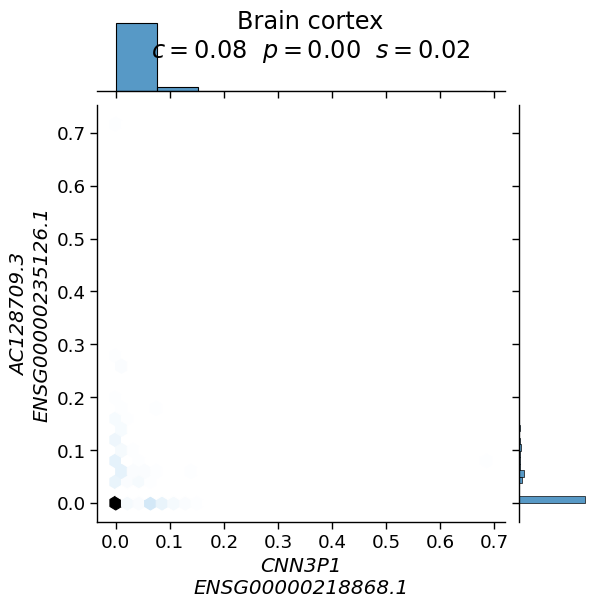

tissue                                                         lung
gene1                                            ENSG00000144559.10
gene2                                             ENSG00000272037.1
Gene 1 Symbol                                                TAMM41
Gene 2 Symbol                                            KB-431C1.5
ccc                                                        0.076111
pearson                                                    0.019043
spearman                                                   0.006401
ccc_pearson_diff                                           0.057068
ccc_spearman_diff                                           0.06971
ccc_combined_distance                                      0.126778
ccc_mean_distance                                          0.063389
ccc_max_distance                                            0.06971
gene1_top1_metadata                                         DTHHRDY
gene1_top1_ccc                                  

'Tissue data: (578, 2)'

('TAMM41', 'KB-431C1.5')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-TAMM41_vs_KB-431C1.5.svg')

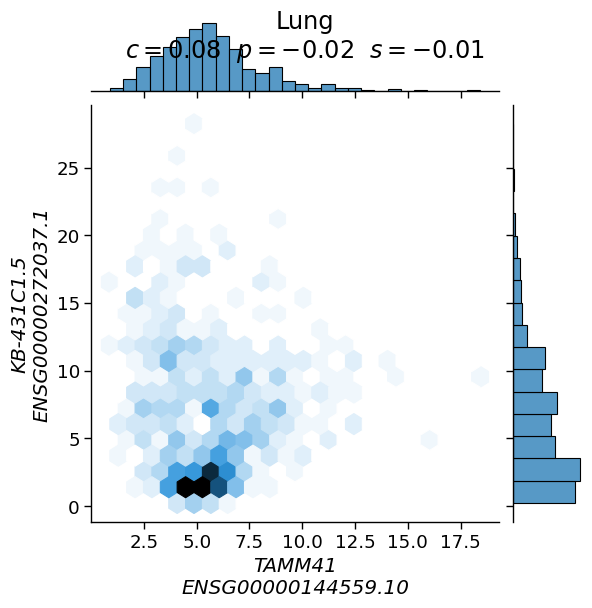

tissue                                                       pancreas
gene1                                              ENSG00000145545.11
gene2                                               ENSG00000204388.6
Gene 1 Symbol                                                  SRD5A1
Gene 2 Symbol                                                  HSPA1B
ccc                                                          0.076111
pearson                                                      0.022186
spearman                                                     0.008179
ccc_pearson_diff                                             0.053925
ccc_spearman_diff                                            0.067932
ccc_combined_distance                                        0.121857
ccc_mean_distance                                            0.060928
ccc_max_distance                                             0.067932
gene1_top1_metadata                                          SMTRSCPT
gene1_top1_ccc      

'Tissue data: (328, 2)'

('SRD5A1', 'HSPA1B')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pancreas-SRD5A1_vs_HSPA1B.svg')

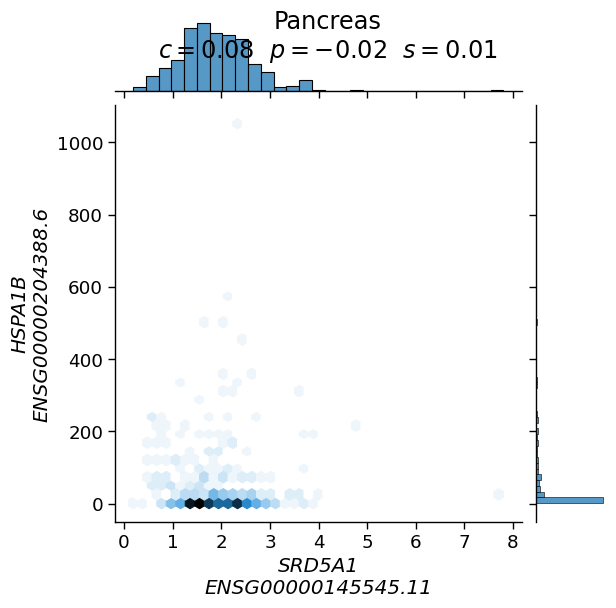

tissue                                                   colon_sigmoid
gene1                                                ENSG00000269228.1
gene2                                                ENSG00000182816.8
Gene 1 Symbol                                                RPS27AP19
Gene 2 Symbol                                                KRTAP13-2
ccc                                                           0.076111
pearson                                                       0.004486
spearman                                                      0.024628
ccc_pearson_diff                                              0.071625
ccc_spearman_diff                                             0.051483
ccc_combined_distance                                         0.123108
ccc_mean_distance                                             0.061554
ccc_max_distance                                              0.071625
gene1_top1_metadata                                             MHCLRD
gene1_

'Tissue data: (373, 2)'

('RPS27AP19', 'KRTAP13-2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_colon_sigmoid-RPS27AP19_vs_KRTAP13-2.svg')

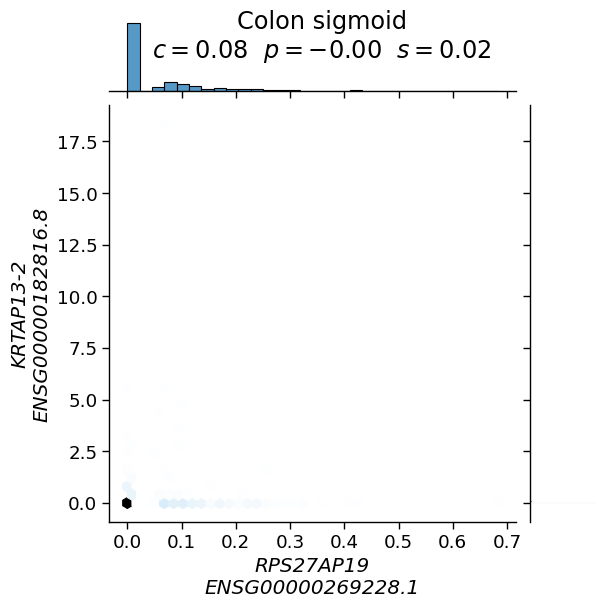

tissue                                                       pancreas
gene1                                              ENSG00000152942.18
gene2                                               ENSG00000204388.6
Gene 1 Symbol                                                   RAD17
Gene 2 Symbol                                                  HSPA1B
ccc                                                          0.076111
pearson                                                      0.008591
spearman                                                      0.00218
ccc_pearson_diff                                              0.06752
ccc_spearman_diff                                            0.073931
ccc_combined_distance                                        0.141451
ccc_mean_distance                                            0.070725
ccc_max_distance                                             0.073931
gene1_top1_metadata                                          SMNTRART
gene1_top1_ccc      

'Tissue data: (328, 2)'

('RAD17', 'HSPA1B')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pancreas-RAD17_vs_HSPA1B.svg')

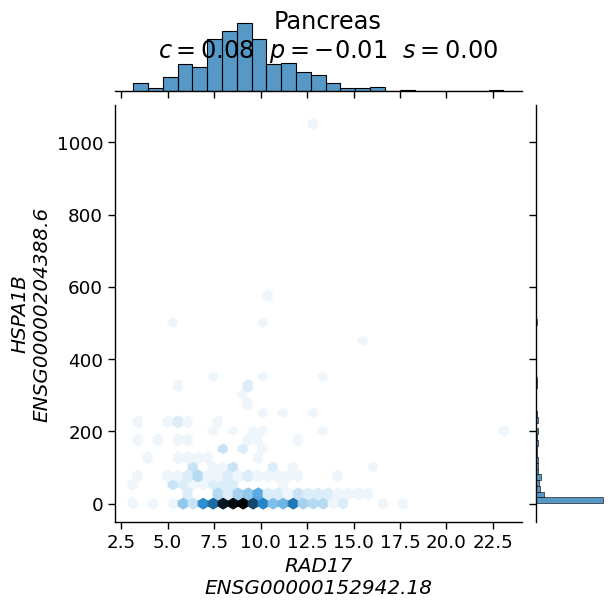

tissue                                                       prostate
gene1                                              ENSG00000166136.15
gene2                                               ENSG00000270015.1
Gene 1 Symbol                                                  NDUFB8
Gene 2 Symbol                                            RP11-540B6.6
ccc                                                           0.07605
pearson                                                      0.002609
spearman                                                     0.012398
ccc_pearson_diff                                             0.073441
ccc_spearman_diff                                            0.063652
ccc_combined_distance                                        0.137093
ccc_mean_distance                                            0.068546
ccc_max_distance                                             0.073441
gene1_top1_metadata                                          SMRRNART
gene1_top1_ccc      

'Tissue data: (245, 2)'

('NDUFB8', 'RP11-540B6.6')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_prostate-NDUFB8_vs_RP11-540B6.6.svg')

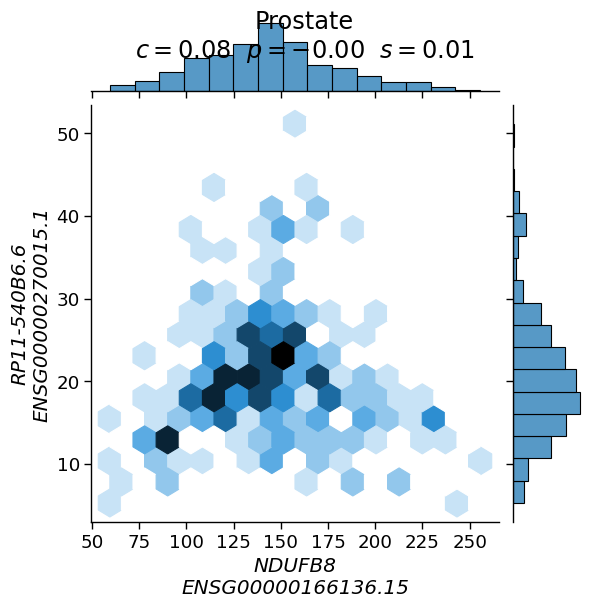

tissue                                                  pituitary
gene1                                           ENSG00000226950.6
gene2                                           ENSG00000279725.1
Gene 1 Symbol                                               DANCR
Gene 2 Symbol                                        RP11-288A5.2
ccc                                                       0.07605
pearson                                                  0.006775
spearman                                                  0.00565
ccc_pearson_diff                                         0.069275
ccc_spearman_diff                                          0.0704
ccc_combined_distance                                    0.139675
ccc_mean_distance                                        0.069838
ccc_max_distance                                           0.0704
gene1_top1_metadata                                       MHBRNPH
gene1_top1_ccc                                           0.063218
gene1_top1

'Tissue data: (283, 2)'

('DANCR', 'RP11-288A5.2')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_pituitary-DANCR_vs_RP11-288A5.2.svg')

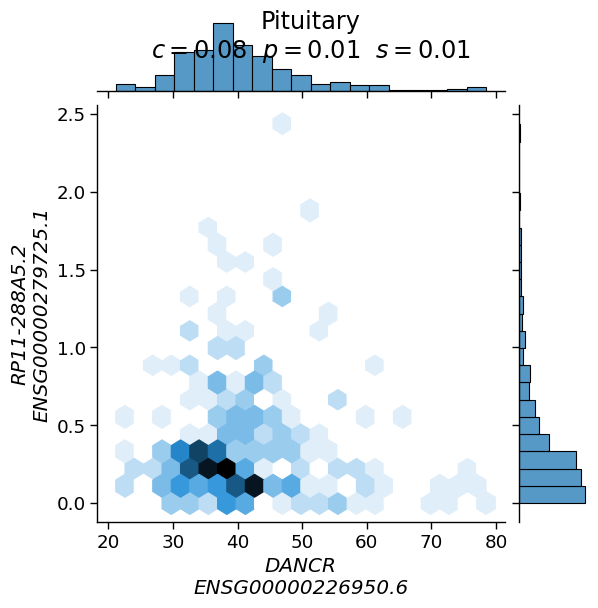

tissue                                                   brain_cortex
gene1                                               ENSG00000276988.1
gene2                                               ENSG00000207375.1
Gene 1 Symbol                                             Metazoa_SRP
Gene 2 Symbol                                             SNORD116-23
ccc                                                          0.075989
pearson                                                      0.003469
spearman                                                      0.01741
ccc_pearson_diff                                             0.072519
ccc_spearman_diff                                            0.058578
ccc_combined_distance                                        0.131098
ccc_mean_distance                                            0.065549
ccc_max_distance                                             0.072519
gene1_top1_metadata                                          MHHRTATT
gene1_top1_ccc      

'Tissue data: (255, 2)'

('Metazoa_SRP', 'SNORD116-23')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_cortex-Metazoa_SRP_vs_SNORD116-23.svg')

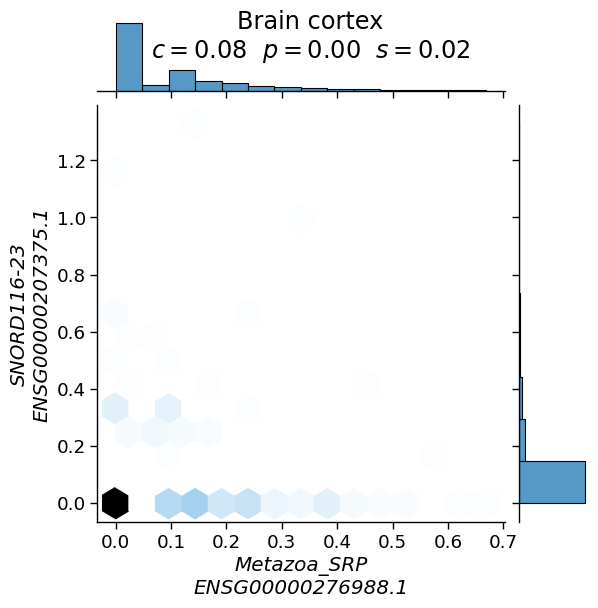

tissue                       brain_nucleus_accumbens_basal_ganglia
gene1                                            ENSG00000248343.1
gene2                                           ENSG00000204387.12
Gene 1 Symbol                                        RP11-556G22.2
Gene 2 Symbol                                              C6orf48
ccc                                                       0.075989
pearson                                                   0.006973
spearman                                                   0.00096
ccc_pearson_diff                                          0.069016
ccc_spearman_diff                                         0.075029
ccc_combined_distance                                     0.144044
ccc_mean_distance                                         0.072022
ccc_max_distance                                          0.075029
gene1_top1_metadata                                       SMEXNCRT
gene1_top1_ccc                                            0.08

'Tissue data: (246, 2)'

('RP11-556G22.2', 'C6orf48')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_brain_nucleus_accumbens_basal_ganglia-RP11-556G22.2_vs_C6orf48.svg')

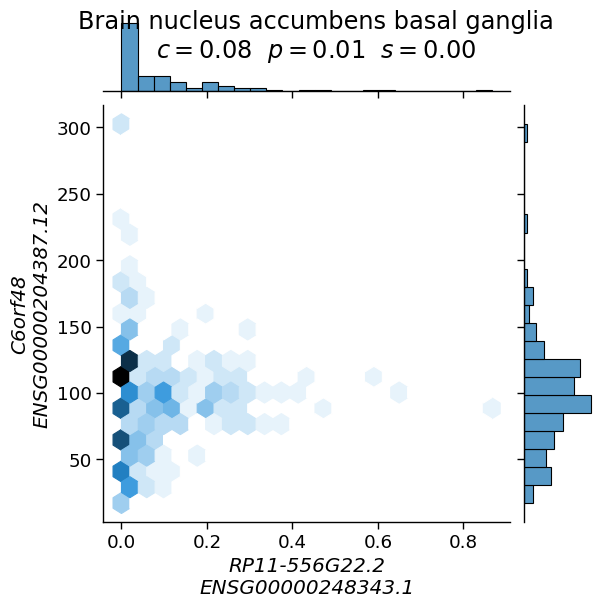

In [357]:
for index, gp_i in gp.iloc[3050:3100].iterrows():
    gp_i_tissue = gp_i["tissue"]
    gene0_id, gene1_id = gp_i["gene1"], gp_i["gene2"]
    display(gp_i)

    _tissue_data, p = plot_gene_pair(
        gp_i_tissue,
        gene0_id,
        gene1_id,
        # hue="DTHRFGD",
        # hue_is_categorical=True,
        # hue_include_categories=[0.0, 97.0],
        # kind="scatter",
    )

    plt.show(p.fig)
    plt.close(p.fig)
    # display(p)

# **Gene pair 3**: Lung, DDX50 - HNRNPA3

In [378]:
gene0_id, gene1_id = "ENSG00000107625.12", "ENSG00000170144.20"
tissue = "lung"

In [379]:
_tissue_data, _p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    plot=False,
    hue="SEX", # force getting metadata
)

'Tissue data: (578, 2)'

'Tissue data with metadata: (578, 264)'

('DDX50', 'HNRNPA3')

In [380]:
_meta_var = "COHORT"

In [381]:
_tissue_data[_meta_var].describe()

count            578
unique             2
top       Postmortem
freq             328
Name: COHORT, dtype: object

'Tissue data: (578, 2)'

'Tissue data with metadata: (578, 264)'

('DDX50', 'HNRNPA3')

PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-DDX50_vs_HNRNPA3.svg')

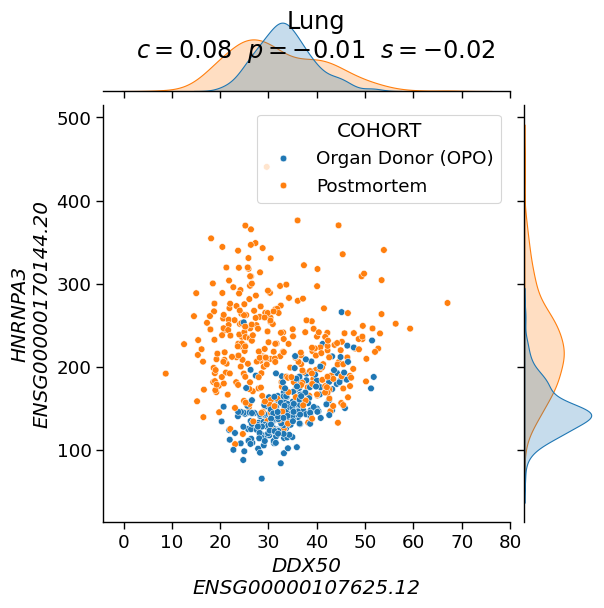

In [382]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue=_meta_var,
    hue_is_categorical=True,
    # hue_include_categories=["Postmortem", "Organ Donor (OPO)"],
    kind="scatter",
)

'Tissue data: (578, 2)'

'Tissue data with metadata: (578, 264)'

('DDX50', 'HNRNPA3')

(578, 264)
(250, 264)


PosixPath('/home/miltondp/projects/ccc/ccc-gpu/ccc-gpu_manuscript/content/images/gene_pairs/gtex_lung-DDX50_vs_HNRNPA3.svg')

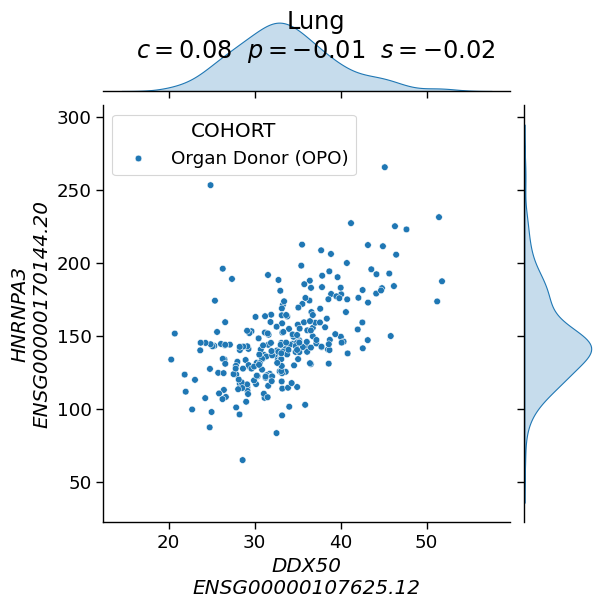

In [383]:
_tissue_data, p = plot_gene_pair(
    tissue,
    gene0_id,
    gene1_id,
    hue=_meta_var,
    hue_is_categorical=True,
    hue_include_categories=["Organ Donor (OPO)"],
    kind="scatter",
)

In [384]:
pearsonr(_tissue_data.iloc[:, 0], _tissue_data.iloc[:, 1])

PearsonRResult(statistic=0.5864198060648329, pvalue=1.7300870261386236e-24)

In [385]:
spearmanr(_tissue_data.iloc[:, 0], _tissue_data.iloc[:, 1])

SignificanceResult(statistic=0.5948060186889855, pvalue=2.586837808795786e-25)

In [387]:
ccc(_tissue_data.iloc[:, 0], _tissue_data.iloc[:, 1], pvalue_n_perms=1000)

/home/miltondp/software/miniconda3/envs/ccc-gpu/lib/python3.10/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


(0.21965006451612903, 0.000999000999000999)

In [393]:
ccc_gpu(_tissue_data.iloc[:, 0], _tissue_data.iloc[:, 1], pvalue_n_perms=1000)

(0.21965006, 0.000999001)